# Skillra PDA: HSE PDA Course project

Воспроизводимый аналитический отчёт Skillra о рынке IT-вакансий (в рамках ТЗ по PDA, этапы 0–4) и продуктовая часть с персонами и skill-gap.

## Вводная
Skillra решает проблему информационного шума на рынке IT-вакансий: кандидаты и джуны тратят недели на поиск релевантных ролей,
а работодатели плохо видят пул талантов и разрывы в навыках. Мы строим Career & Job Market Navigator, опираясь на сырые данные
hh.ru, чтобы проверять продуктовые гипотезы: какие сегменты растут, где есть junior-friendly окна, какие навыки дают премию.

Этот ноутбук - investor story и отчёт по проекту HSE PDA: этапы 0–4 показывают полный цикл от парсинга до визуализаций и персон Skillra.
Каждый блок заканчивается выводами: что мы сделали, зачем, что узнали про рынок и как это конвертируется в ценность продукта.

### Команда и набор задач
| Участник                                    | Зоны ответственности                                                                                                |
|---------------------------------------------|---------------------------------------------------------------------------------------------------------------------|
| Монахов Иван | Парсер hh.ru (`parser/hh_scraper.py`), ежедневный сбор данных, обход лимитов hh.ru, документация и быстрая отладка.                                |
| Адамов Даниил, Полынская Галина                                | Предобработка (`cleaning.py`), контроль булевых фич и зарплатных инвариантов, тесты. |
| Полынская Галина, Адамов Даниил             | Фичи (`features.py`), витрина рынка (`market.py`), интеграция путей/конфига, пайплайн (`scripts/run_pipeline.py`).  |
| Попов Контантин, Монахов Иван               | EDA и визуализации (`eda.py`, `viz.py`), метрики по ролям/городам/форматам, улучшение графиков и HTML-отчёта.       |
| Монахов Иван, Попов Константин              | Оркестрация шагов плана, чек-лист, поддержка notebook-runner и воспроизводимости, общее ревью решения.              |

### Настройка окружения и загрузка артефактов
Используем функции из `src.skillra_pda`, директории и пути из `config`. Если обработанные данные отсутствуют, запускаем пайплайн `scripts/run_pipeline.py`.

## Этап 0. Парсинг hh.ru и исходные данные
Парсер `parser/hh_scraper.py` ежедневно собирает активные IT-вакансии hh.ru по СНГ. Цель — накопить >1kk строк до конца 2026 года, чтобы видеть динамику рынка.
Сбор учитывает лимиты hh.ru (пагинация по опыту `EXPERIENCE_SHARDS`, ограничение ~2000 резов на выдачу, дросселирование запросов и ротацию proxy/UA).

### 0.1 Что собирает парсер и как данные используются дальше
- Фильтры: широкая булева строка по IT-ролям (`DEFAULT_QUERY`), регионы СНГ (`areas`), опытные срезы (`EXPERIENCE_SHARDS`), лимит `DEFAULT_LIMIT`.
- Периодичность: ежедневный запуск (дельта активных вакансий), цель >500k строк c заданными заработными платами.
- Ограничения hh.ru: лимит на выдачу, антибот, необходимость пауз и ротации User-Agent/proxy.
- Куда идёт дальше: поля из CSV мапятся на признаки из `docs/02_feature_dictionary_hh.md` (формат работы, грейд, роли, стек, бенефиты, англ/образование) и используются в пайплайне + продуктовых персонах.

In [1]:

from pathlib import Path
import sys
import importlib
import pandas as pd
from IPython.display import Markdown, display, Image

CWD = Path.cwd()
CANDIDATES = [CWD] + list(CWD.parents)
PROJECT_ROOT = next((p for p in CANDIDATES if (p / "src" / "skillra_pda").exists()), CWD)
SRC_DIR = PROJECT_ROOT / "src"

for path in {PROJECT_ROOT, SRC_DIR}:
    if str(path) not in sys.path:
        sys.path.insert(0, str(path))

from src.skillra_pda import config, io, cleaning, features, eda, viz, personas
from importlib import reload
for module in (cleaning, features, eda):
    reload(module)

config.ensure_directories()

if not config.CLEAN_DATA_FILE.exists() or not config.FEATURE_DATA_FILE.exists():
    import scripts.run_pipeline as run_pipeline
    run_pipeline.main()

raw_path = config.RAW_DATA_FILE
clean_path = config.CLEAN_DATA_FILE
feat_path = config.FEATURE_DATA_FILE

df_raw = io.load_raw(raw_path)
df_clean = pd.read_parquet(clean_path)
df_features = pd.read_parquet(feat_path)

df_features.head(2)


,vacancy_id,title,company,salary_from,salary_to,currency,salary_gross,salary_mid,salary_range_width,salary_is_exact,...,benefits_count,soft_skills_count,hard_stack_count,role_count,is_junior_friendly,battle_experience,grade_from_experience,grade_final,primary_role,salary_bucket
0,128222379,Старший специалист технической поддержки,Сбер. Начало карьеры,77000.0,NaN,RUB,True,77000.0,0,True,...,4,1,0,0,True,False,intern,senior,other,mid
1,127080428,Продуктовый/BI аналитик,Яндекс Крауд: Бэк-офис,73000.0,NaN,RUB,False,73000.0,0,True,...,3,1,1,3,False,True,junior,junior,data,low


### Эволюция датасета
Прослеживаем размеры и ключевые доли на каждом этапе пайплайна: сырой CSV → очищенный parquet → фичи → агрегированная витрина `market_view`.

In [2]:
from src.skillra_pda import market

market_view_path = config.PROCESSED_DATA_DIR / "market_view.parquet"
df_market_view = (
    pd.read_parquet(market_view_path)
    if market_view_path.exists()
    else market.build_market_view(df_features.copy())
)

def summarize_stage(name: str, df, weight_col: str | None = None):
    rows, cols = df.shape
    salary_cols = [c for c in ["salary_mid_rub_capped", "salary_mid", "salary_from", "salary_to"] if c in df]
    salary_share = df[salary_cols].notna().any(axis=1).mean() if salary_cols else None
    non_rub = ((df.get("currency", "RUB") != "RUB").mean()) if "currency" in df else None
    remote_share = None
    unknown_work = None
    if "work_mode" in df:
        work_mode_series = df["work_mode"].fillna("unknown").str.lower()
        remote_share = work_mode_series.isin(["remote", "hybrid"]).mean()
        unknown_work = work_mode_series.eq("unknown").mean()
    elif "is_remote" in df:
        remote_share = df["is_remote"].fillna(False).mean()
    elif "remote_share" in df:
        weights = df[weight_col] if weight_col and weight_col in df else None
        if weights is not None and weights.sum() > 0:
            remote_share = float((df["remote_share"] * weights).sum() / weights.sum())
        else:
            remote_share = df["remote_share"].mean()
    return {
        "stage": name,
        "rows": rows,
        "cols": cols,
        "salary_specified_share": salary_share,
        "non_rub_share": non_rub,
        "remote_or_hybrid_share": remote_share,
        "unknown_work_mode_share": unknown_work,
    }

evolution_rows = [
    summarize_stage("raw", df_raw),
    summarize_stage("clean", df_clean),
    summarize_stage("features", df_features),
    summarize_stage("market_view", df_market_view, weight_col="vacancy_count"),
]
evolution_df = pd.DataFrame(evolution_rows)
display(evolution_df)

,stage,rows,cols,salary_specified_share,non_rub_share,remote_or_hybrid_share,unknown_work_mode_share
0,raw,7026,151,1.0,0.077569,0.548107,NaN
1,clean,7026,151,1.0,0.077569,0.548107,NaN
2,features,7026,166,1.0,0.077569,0.571164,0.340592
3,market_view,2940,12,NaN,NaN,0.554212,NaN


In [3]:
from IPython.display import Markdown, display

evo = evolution_df.set_index("stage")
raw_stage = evo.loc["raw"]
clean_stage = evo.loc["clean"]
feat_stage = evo.loc["features"]
market_stage = evo.loc["market_view"]

def fmt_int(x: int) -> str:
    return f"{int(x):,}".replace(",", " ")

def fmt_pct(value):
    if value is None or (isinstance(value, float) and pd.isna(value)):
        return "N/A"
    try:
        return f"{float(value):.1%}"
    except (TypeError, ValueError):
        return "N/A"

summary_md = Markdown(
    f"**Ключевые выводы по эволюции:** "
    f"n {fmt_int(raw_stage['rows'])} → {fmt_int(feat_stage['rows'])}, "
    f"колонок {fmt_int(raw_stage['cols'])} → {fmt_int(feat_stage['cols'])}; "
    f"доля строк с указанной зарплатной вилкой после clean — {fmt_pct(clean_stage['salary_specified_share'])}, "
    f"non-RUB в market_view — {fmt_pct(market_stage['non_rub_share'])}; "
    f"remote+hybrid на этапе features — {fmt_pct(feat_stage['remote_or_hybrid_share'])}, "
    f"work_mode=unknown — {fmt_pct(feat_stage['unknown_work_mode_share'])}."
)
display(summary_md)


**Ключевые выводы по эволюции:** n 7 026 → 7 026, колонок 151 → 166; доля строк с указанной зарплатной вилкой после clean — 100.0%, non-RUB в market_view — N/A; remote+hybrid на этапе features — 57.1%, work_mode=unknown — 34.1%.

### 0.1a Здоровье данных: NaN и маркеры unknown
Проверяем, где остаются пропуски и текстовые маркеры неопределённости на этапах raw → clean → features.

In [4]:
health_raw = cleaning.summarize_data_health(df_raw, prefix="raw:")
health_clean = cleaning.summarize_data_health(df_clean, prefix="clean:")
health_features = cleaning.summarize_data_health(df_features, prefix="feat:")

def top_health(df: pd.DataFrame, n: int = 12):
    return df.sort_values(by=["share_nan", "share_unknown_marker"], ascending=False).head(n)

health_raw_top = top_health(health_raw)
health_clean_top = top_health(health_clean)
health_features_top = top_health(health_features)

display(health_raw_top), display(health_clean_top), display(health_features_top)

,column,dtype,share_nan,share_unknown_marker,comment
13,raw:metro_primary,object,0.987190,0.0,NaN 98.7%
42,raw:vacancy_code,object,0.960717,0.0,NaN 96.1%
131,raw:edu_math_or_cs,object,0.953601,0.0,NaN 95.4%
126,raw:employer_accredited_it,object,0.930259,0.0,NaN 93.0%
22,raw:schedule,object,0.868346,0.0,NaN 86.8%
127,raw:employer_type,object,0.832622,0.0,NaN 83.3%
130,raw:edu_technical,object,0.801167,0.0,NaN 80.1%
129,raw:edu_level,object,0.714774,0.0,NaN 71.5%
128,raw:edu_required,object,0.658269,0.0,NaN 65.8%
4,raw:salary_to,float64,0.473100,0.0,зарплата отсутствует в исходной вакансии; NaN ...


,column,dtype,share_nan,share_unknown_marker,comment
124,clean:employer_accredited_it,boolean,0.930259,0.0,NaN 93.0%
128,clean:edu_technical,boolean,0.801167,0.0,NaN 80.1%
127,clean:edu_level,object,0.714774,0.0,NaN 71.5%
126,clean:edu_required,boolean,0.658269,0.0,NaN 65.8%
4,clean:salary_to,float64,0.473100,0.0,зарплата отсутствует в исходной вакансии; NaN ...
35,clean:skills,object,0.337319,0.0,NaN 33.7%
11,clean:address,object,0.316539,0.0,NaN 31.7%
118,clean:employer_rating,float64,0.226018,0.0,отзывов/рейтинга на hh нет; NaN 22.6%
3,clean:salary_from,float64,0.139909,0.0,зарплата отсутствует в исходной вакансии; NaN ...
22,clean:work_format_raw,object,0.119556,0.0,NaN 12.0%


,column,dtype,share_nan,share_unknown_marker,comment
124,feat:employer_accredited_it,boolean,0.930259,0.0,NaN 93.0%
128,feat:edu_technical,boolean,0.801167,0.0,NaN 80.1%
127,feat:edu_level,object,0.714774,0.0,NaN 71.5%
126,feat:edu_required,boolean,0.658269,0.0,NaN 65.8%
4,feat:salary_to,float64,0.473100,0.0,зарплата отсутствует в исходной вакансии; NaN ...
35,feat:skills,object,0.337319,0.0,NaN 33.7%
11,feat:address,object,0.316539,0.0,NaN 31.7%
118,feat:employer_rating,float64,0.226018,0.0,отзывов/рейтинга на hh нет; NaN 22.6%
3,feat:salary_from,float64,0.139909,0.0,зарплата отсутствует в исходной вакансии; NaN ...
22,feat:work_format_raw,object,0.119556,0.0,NaN 12.0%


(None, None, None)

In [5]:
default_obj_clean = pd.Series(pd.NA, index=df_clean.index, dtype=object)
default_obj_feat = pd.Series(pd.NA, index=df_features.index, dtype=object)
default_bool_clean = pd.Series(pd.NA, index=df_clean.index, dtype="boolean")

def _share_unknown(series):
    return (
        series.fillna("unknown")
        .astype(str)
        .str.lower()
        .eq("unknown")
        .mean()
    )

work_mode_unknown_share = _share_unknown(df_features.get("work_mode", default_obj_feat))
english_unknown_share = _share_unknown(df_clean.get("lang_english_level", default_obj_clean))
english_required_nan = df_clean.get("lang_english_required", default_bool_clean).isna().mean()
education_unknown_share = _share_unknown(df_clean.get("education_level", default_obj_clean))
benefits_missing_share = df_clean.filter(like="benefit_").isna().mean().mean() if df_clean.filter(like="benefit_").shape[1] else 0
soft_missing_share = df_clean.filter(like="soft_").isna().mean().mean() if df_clean.filter(like="soft_").shape[1] else 0

grade_unknown_raw = _share_unknown(df_clean.get("grade", default_obj_clean))
grade_unknown_final = _share_unknown(df_features.get("grade_final", default_obj_feat))
salary_mid = df_features.get("salary_mid_rub")
salary_capped = df_features.get("salary_mid_rub_capped")
salary_capped_share = (
    (salary_mid.notna()) & (salary_capped.notna()) & (salary_mid != salary_capped)
).mean() if salary_mid is not None and salary_capped is not None else 0

health_key_figures = {
    "work_mode_unknown_share": work_mode_unknown_share,
    "english_unknown_share": english_unknown_share,
    "english_required_nan": english_required_nan,
    "education_unknown_share": education_unknown_share,
    "benefits_missing_share": benefits_missing_share,
    "soft_missing_share": soft_missing_share,
    "grade_unknown_raw": grade_unknown_raw,
    "grade_unknown_final": grade_unknown_final,
    "salary_capped_share": salary_capped_share,
}
display(health_key_figures)


{'work_mode_unknown_share': np.float64(0.3405920865357244),
 'english_unknown_share': np.float64(0.03472815257614575),
 'english_required_nan': np.float64(0.0),
 'education_unknown_share': np.float64(1.0),
 'benefits_missing_share': np.float64(0.0),
 'soft_missing_share': np.float64(0.0),
 'grade_unknown_raw': np.float64(0.7083689154568744),
 'grade_unknown_final': np.float64(0.0),
 'salary_capped_share': np.float64(0.018218047253060064)}

In [6]:
from IPython.display import Markdown, display

n_features = len(df_features)
grade_counts = df_features["grade"].fillna("unknown").astype(str).str.lower().value_counts()
work_mode_counts = df_features.get("work_mode", pd.Series(dtype=str)).fillna("unknown").astype(str).str.lower().value_counts()
english_unknown = (
    df_features.get("lang_english_level", pd.Series(dtype=str))
    .fillna("unknown")
    .astype(str)
    .str.lower()
    .eq("unknown")
    .mean()
)
salary_missing = df_features[["salary_from", "salary_to"]].isna().all(axis=1).mean()

coverage_md = Markdown(
    f"**Coverage ключевых полей:** выборка {n_features:,}. "
    f"unknown grade — {grade_counts.get('unknown', 0) / max(n_features, 1):.1%}, "
    f"unknown work_mode — {work_mode_counts.get('unknown', 0) / max(n_features, 1):.1%}, "
    f"unknown уровень английского — {english_unknown:.1%}, "
    f"пропусков зарплатной вилки — {salary_missing:.1%}. "
    f"Высокая доля неизвестных грейдов и форматов работы может смещать распределения."
)
display(coverage_md)


**Coverage ключевых полей:** выборка 7,026. unknown grade — 70.8%, unknown work_mode — 34.1%, unknown уровень английского — 3.5%, пропусков зарплатной вилки — 0.0%. Высокая доля неизвестных грейдов и форматов работы может смещать распределения.

In [7]:
data_quality_table = pd.DataFrame(
    [
        (
            "Work mode = unknown",
            f"{work_mode_unknown_share:.1%}",
            "Доля удалёнки/гибрида может быть занижена; в выводах отмечаем неопределённость формата.",
        ),
        (
            "English level unknown",
            f"{english_unknown_share:.1%}",
            "Оценка требований к языку ограничена, считаем доли среди известных значений.",
        ),
        (
            "Grade unknown (raw) → grade_final",
            f"{grade_unknown_raw:.1%} → {grade_unknown_final:.1%}",
            "grade_final сокращает неопределённость, графики строим по итоговому грейду.",
        ),
        (
            "Salary cap (capped vs mid)",
            f"{salary_capped_share:.1%}",
            "Срезали верхние выбросы, поэтому медианы/топы не раздуваются редкими офферами.",
        ),
        (
            "Benefits missing",
            f"{benefits_missing_share:.1%}",
            "Интерпретируем доли бенефитов с оговоркой о пропусках.",
        ),
        (
            "Soft skills missing",
            f"{soft_missing_share:.1%}",
            "Топ soft-skills строим по имеющимся строкам, не обобщая на весь рынок.",
        ),
    ],
    columns=["Метрика", "Значение", "Как влияет на выводы"],
)

display(data_quality_table)

quality_md = Markdown(
    f"""
**Что увидели по качеству:**
- Work_mode остаётся слабым местом: {work_mode_unknown_share:.1%} строк с unknown → в сегментациях по формату работы делаем явную оговорку.
- Требования к английскому указаны эпизодически (unknown {english_unknown_share:.1%} + {english_required_nan:.1%} NaN по "обязательности"), поэтому выводы по языку строим среди известных значений.
- grade_final сокращает долю unknown грейда с {grade_unknown_raw:.1%} до {grade_unknown_final:.1%}, что делает графики по грейдам стабильнее.
- Salary cap применился к {salary_capped_share:.1%} строк: медианы устойчивы, но высокие офферы не завышают рынок.
"""
)

display(quality_md)


,Метрика,Значение,Как влияет на выводы
0,Work mode = unknown,34.1%,Доля удалёнки/гибрида может быть занижена; в в...
1,English level unknown,3.5%,"Оценка требований к языку ограничена, считаем ..."
2,Grade unknown (raw) → grade_final,70.8% → 0.0%,"grade_final сокращает неопределённость, график..."
3,Salary cap (capped vs mid),1.8%,"Срезали верхние выбросы, поэтому медианы/топы ..."
4,Benefits missing,0.0%,Интерпретируем доли бенефитов с оговоркой о пр...
5,Soft skills missing,0.0%,"Топ soft-skills строим по имеющимся строкам, н..."



**Что увидели по качеству:**
- Work_mode остаётся слабым местом: 34.1% строк с unknown → в сегментациях по формату работы делаем явную оговорку.
- Требования к английскому указаны эпизодически (unknown 3.5% + 0.0% NaN по "обязательности"), поэтому выводы по языку строим среди известных значений.
- grade_final сокращает долю unknown грейда с 70.8% до 0.0%, что делает графики по грейдам стабильнее.
- Salary cap применился к 1.8% строк: медианы устойчивы, но высокие офферы не завышают рынок.


### 0.2 Пример сырых данных и базовые статы
Показываем head, `info()` и первичный профиль пропусков/типов, чтобы понимать качество источника до очистки.

In [8]:

import io

raw_head = df_raw.head(5)
buffer = io.StringIO()
df_raw.info(buf=buffer)
raw_info = buffer.getvalue()

raw_overview = {
    "raw_path": str(raw_path),
    "raw_shape": df_raw.shape,
    "columns_sample": df_raw.columns.tolist()[:10],
}
raw_profile = cleaning.basic_profile(df_raw)
raw_missing_top = eda.missing_share(df_raw, top_n=10)
raw_numeric_stats = df_raw.select_dtypes("number").describe().T

raw_head, raw_info, raw_overview, raw_profile, raw_missing_top, raw_numeric_stats


(   vacancy_id                                              title  \
 0   128222379           Старший специалист технической поддержки   
 1   128153550                    Старший системный администратор   
 2   128097180               Мобильный разработчик (React Native)   
 3   128086715                 Business Development Manager (BDM)   
 4   128084097  Ведущий специалист по информационной безопасности   
 
                          company  salary_from  salary_to currency  \
 0           Сбер. Начало карьеры      77000.0        NaN      RUB   
 1  АОАзиатско-Тихоокеанский Банк          NaN   150000.0      RUB   
 2                        ОООАЙРО     180000.0   250000.0      RUB   
 3           ОООАгент Умный полис     350000.0        NaN      RUB   
 4                     ООО "ЭСКБ"      66700.0    70500.0      RUB   
 
   salary_gross  salary_mid  salary_range_width  salary_is_exact  ...  \
 0         True     77000.0                   0             True  ...   
 1         True 

### 0.3 Выводы по этапу 0
- **Что сделали:** описали ежедневный парсер hh.ru, его фильтры/ограничения, показали сырой head и профиль данных.
- **Почему так:** ежедневная дельта и лимиты hh.ru требуют шардирования опыта и аккуратных пауз, чтобы собирать стабильный поток вакансий.
- **Ключевые цифры:** 7 026 строк и 151 колонка в raw, 100% строк содержат хотя бы одну границу зарплаты, 7.8% вакансий в USD/EUR.
- **Мини-чек-лист:** после парсинга имеем сырую выгрузку 7 026×151 без дублей; зафиксировали поля зарплаты/валюты как основу для очистки и конвертации.
- **Что это даёт Skillra:** стабильная точка входа данных для аналитики и рекомендации карьерных путей, масштабируемая до 500k+ вакансий.

## Этап 1. Предобработка (cleaning.py)
Повторяем шаги cleaning: парсинг дат, дедупликация, обработка пропусков, нормализация булевых колонок (`salary_gross` и все флаги is_/has_/benefit_/soft_/domain_/role_). Готовые результаты берём из `data/processed/hh_clean.parquet`. Ниже — снимки пропусков и типов.

In [9]:

dup_raw = df_raw.duplicated().sum()
dup_clean = df_clean.duplicated().sum()
missing_salary = df_raw[[c for c in df_raw.columns if "salary" in c]].isna().mean().to_dict()

clean_missing_top = eda.missing_share(df_clean, top_n=10)
salary_gross_dtype = str(df_clean.get("salary_gross", pd.Series(dtype="boolean")).dtype)
salary_gross_stats = df_clean.get("salary_gross", pd.Series(dtype="boolean")).value_counts(dropna=False)

clean_snapshot = {
    "clean_shape": df_clean.shape,
    "salary_gross_dtype": salary_gross_dtype,
    "salary_gross_counts": salary_gross_stats.to_dict(),
    "duplicates_raw": int(dup_raw),
    "duplicates_clean": int(dup_clean),
    "missing_salary_share_raw": missing_salary,
}
clean_snapshot, clean_missing_top


({'clean_shape': (7026, 151),
  'salary_gross_dtype': 'boolean',
  'salary_gross_counts': {np.False_: 4335, np.True_: 2690, <NA>: 1},
  'duplicates_raw': 0,
  'duplicates_clean': 0,
  'missing_salary_share_raw': {'salary_from': 0.1399089097637347,
   'salary_to': 0.4730999146029035,
   'salary_gross': 0.00014232849416453175,
   'salary_mid': 0.0,
   'salary_range_width': 0.0,
   'salary_is_exact': 0.0}},
 employer_accredited_it    0.930259
 edu_technical             0.801167
 edu_level                 0.714774
 edu_required              0.658269
 salary_to                 0.473100
 skills                    0.337319
 address                   0.316539
 employer_rating           0.226018
 salary_from               0.139909
 work_format_raw           0.119556
 dtype: float64)

### 1.1 Выводы по этапу 1
- **Что сделали:** привели типы, очистили пропуски, дедуплицировали, нормализовали зарплаты и каппинг.
- **Почему так:** без единых типов и контроля `salary_gross`/валюты нельзя честно сравнивать роли и города.
- **Ключевые цифры:** размер датасета сохранился 7 026×151, дублей нет (0→0); `salary_from` заполнен в 86% строк, `salary_to` — в 53%.
- **Мини-чек-лист:** до этапа 7 026×151 raw → после 7 026×151 clean; конвертировали валюту, привели булевые и дату публикации, подготовили `salary_mid_rub_capped`.
- **Что это даёт Skillra:** очищенные данные → стабильные витрины и корректные графики/персоны без шумовых выбросов.

## Этап 2. Признаки (features.py)
Используем `features.engineer_all_features`: свежесть вакансии (`vacancy_age_days`), география (`city_tier`), формат работы (`work_mode`), зарплатные бакеты (`salary_bucket`), стековые агрегаты (`core_data_skills_count`, `ml_stack_count`, `tech_stack_size`), текстовые метрики (`description_len_chars/words`), продуктовые флаги (`is_junior_friendly`, `battle_experience`).

In [10]:

key_features = [
    "vacancy_age_days",
    "city_tier",
    "work_mode",
    "salary_bucket",
    "core_data_skills_count",
    "ml_stack_count",
    "tech_stack_size",
    "description_len_chars",
    "description_len_words",
    "is_junior_friendly",
    "battle_experience",
]
available = [c for c in key_features if c in df_features.columns]

feature_snapshot = df_features[available].head(5)
feature_stats = df_features[[c for c in available if pd.api.types.is_numeric_dtype(df_features[c])]].describe().T
feature_snapshot, feature_stats


(   vacancy_age_days city_tier work_mode salary_bucket  core_data_skills_count  \
 0                 3    Moscow   unknown           mid                       0   
 1                 4    Moscow    remote           low                       2   
 2                -1  Other RU    remote           mid                       0   
 3                -1    Moscow    remote           NaN                       0   
 4                 4    Moscow     field           low                       0   
 
    ml_stack_count  tech_stack_size  description_len_chars  \
 0               0                0                   1670   
 1               0                3                   1424   
 2               0                0                   1718   
 3               0                2                   2634   
 4               0                0                   1230   
 
    description_len_words  is_junior_friendly  battle_experience  
 0                    233                True              False 

### 2.1 Выводы по этапу 2
- **Что сделали:** добавили признаки work_mode, city_tier, salary_bucket, домены, роли, размер стека, junior-friendly, англ/образование.
- **Почему так:** эти фичи нужны для продукта (подбор ролей/треков) и для честного EDA по сегментам.
- **Ключевые цифры:** после feature engineering 7 026×164 (+13 фичей); work_mode даёт 57% remote/hybrid и 5% офис/field, но 34% строк в категории `unknown` — доли форматов могут быть смещены.
- **Мини-чек-лист:** до этапа 7 026×151 clean → после 7 026×164 features; добавили work_mode, city_tier, salary_bucket, стековые счётчики, primary_role, флаги junior-friendly/remote.
- **Что это даёт Skillra:** готовая витрина для подсказок пользователю и расчёта skill-gap по выбранному сегменту.

## Этап 3. Разведочный анализ (EDA)
Смотрим рынок по зарплатам, форматам работы, ролям, навыкам, доменам, английскому, образованию и работодателям. Используем агрегаты из `eda.py` и визуализации из `viz.py`; добавляем текстовые выводы для каждой темы.

In [11]:
import importlib

import src.skillra_pda.eda as eda_module

eda = importlib.reload(eda_module)
if not hasattr(eda, "salary_by_city_tier"):
    raise AttributeError("expected salary_by_city_tier in eda module; ensure local code is on sys.path")

salary_city = eda.salary_by_city_tier(df_features)
salary_grade = eda.salary_by_grade(df_features)
salary_role = eda.salary_by_primary_role(df_features)
salary_stack = eda.salary_by_stack_size(df_features)

skill_cols = eda.hard_skill_columns(df_features)
top_skills = eda.skill_frequency(df_features, skill_cols, top_n=15).index.tolist()
skill_share = eda.skill_share_by_grade(df_features, top_skills)

benefits_grade = eda.benefits_summary_by_grade(df_features)
soft_corr = eda.soft_skills_correlation(df_features)
junior_roles = eda.junior_friendly_share(df_features, group_col="primary_role")

salary_city.head(), salary_grade.head(), salary_role.head(), salary_stack.head(), skill_share.head(), benefits_grade.head(), soft_corr.head(), junior_roles.head()


(  city_tier     n    median           mean           std
 4       SPb   562  130000.0  145892.617438  77094.175013
 2    Moscow  3242  127500.0  145311.741672  96145.359497
 3  Other RU  1998   95000.0  111572.545796  68676.464805
 0  KZ/Other     5   90000.0  107900.000000  56389.715374
 1  Million+   674   80000.0  103045.567507  67396.374480,
        grade     n    median           mean            std
 5     senior   285  250000.0  241711.538596  102758.087085
 4     middle   393  205000.0  215747.055980   71638.662097
 0  architect    55  150000.0  195578.181818  111748.372581
 3       lead   535  140000.0  153798.027103   86253.300608
 6    unknown  4660  100000.0  118145.690236   75265.715385,
   primary_role    n    median           mean            std
 3       devops  229  205000.0  205762.371179   98334.581345
 7           ml  262  200000.0  192403.816794  108477.864528
 1      backend  312  195000.0  195794.391026   91325.894531
 6      manager   29  185000.0  197500.000000 

### 3.1 Рынок по доменам (отраслям)
Используем доменные флаги (`domain_*`), чтобы увидеть распределение вакансий и зарплат по ключевым отраслям. Приоритеты строим по частоте, чтобы корректно выбрать главный домен при нескольких флагах.

In [12]:
domain_cols = [c for c in df_features.columns if c.startswith("domain_")]
domain_priorities = (
    df_features[domain_cols]
    .sum()
    .sort_values(ascending=False)
    .index.str.removeprefix("domain_")
    .tolist()
)


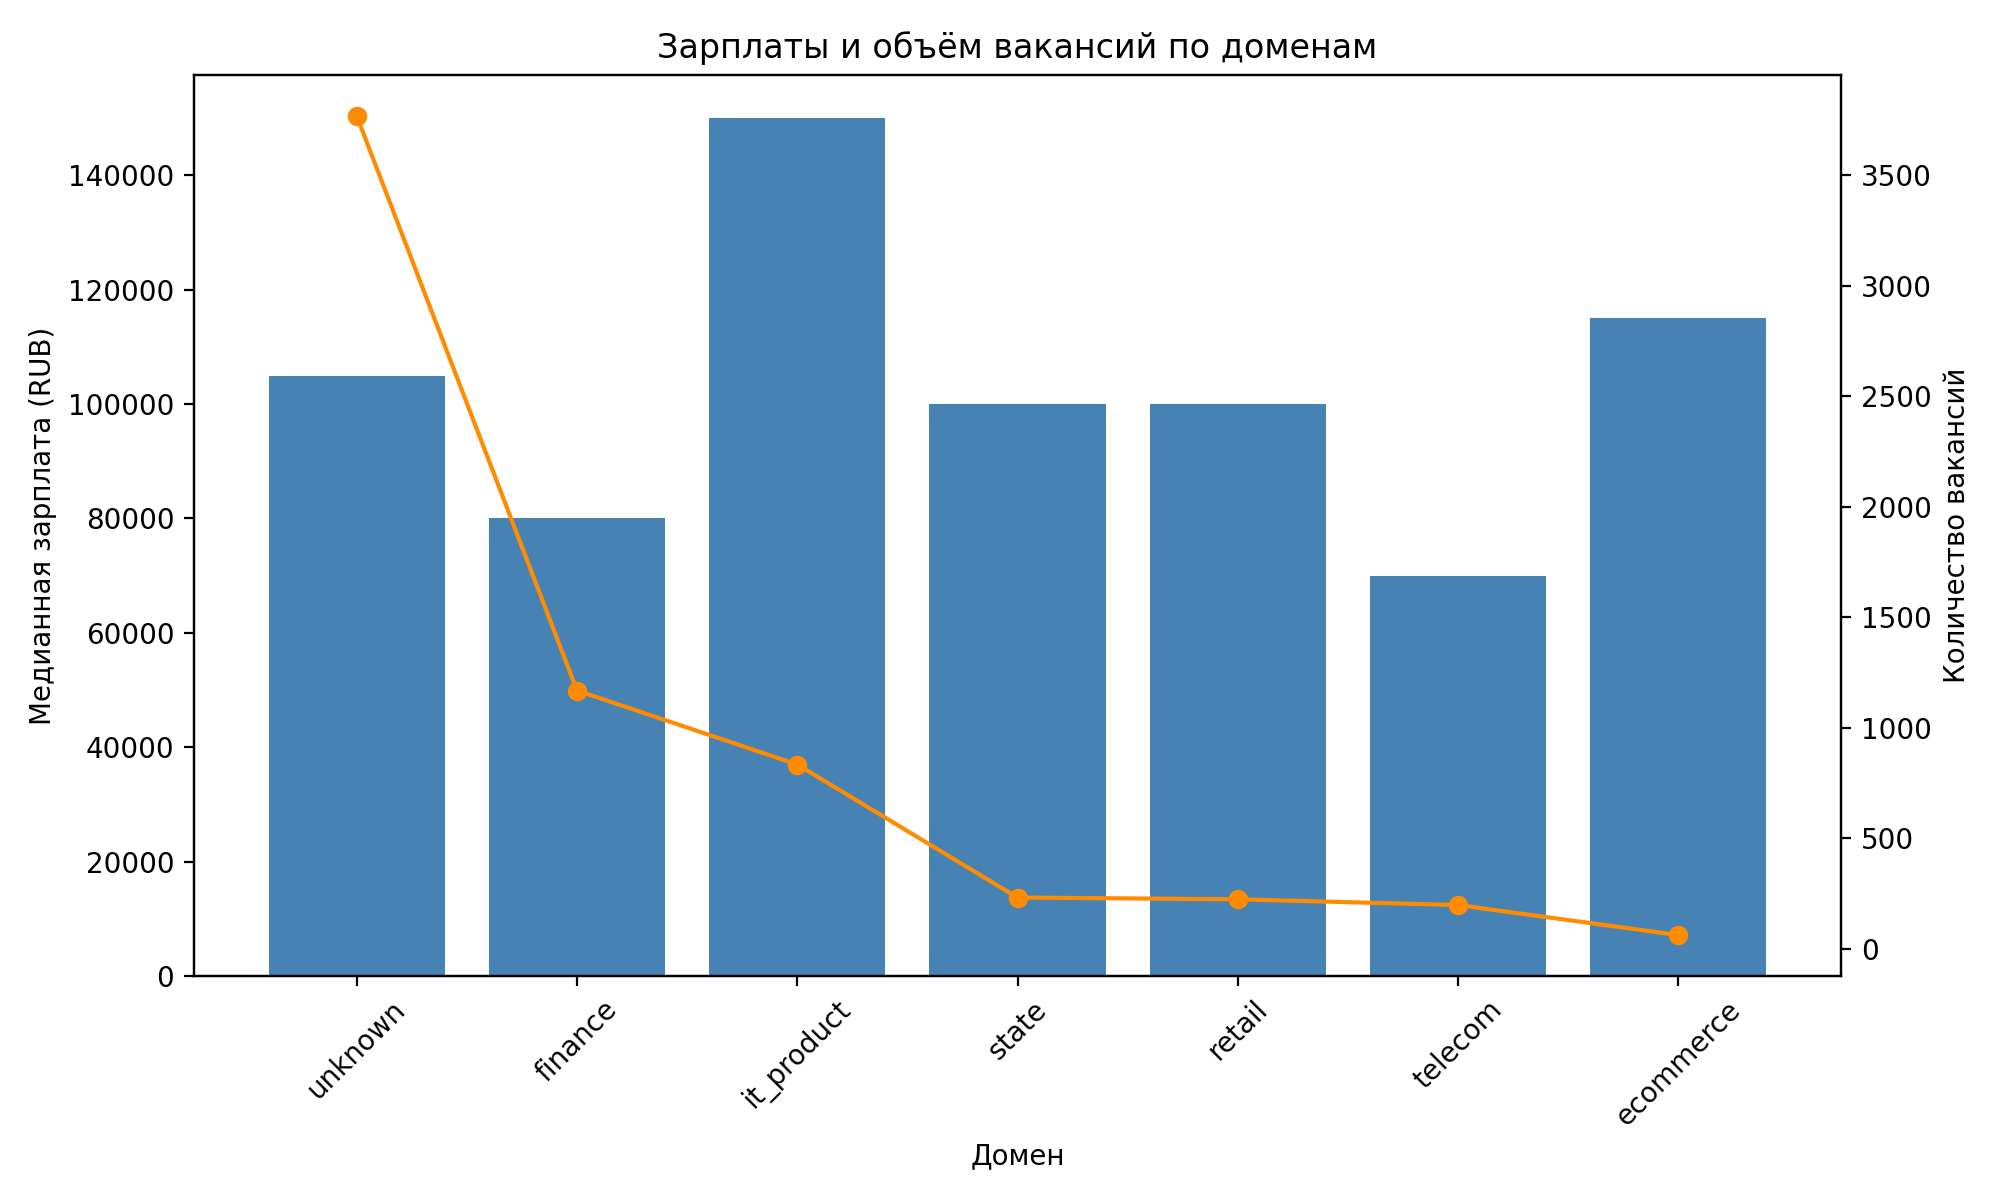

In [13]:
from src.skillra_pda import viz
viz = importlib.reload(viz)

salary_domain_path = viz.salary_by_domain_plot(
    df_features, top_n=10, priorities=domain_priorities
)

display(Image(salary_domain_path))


In [14]:
domain_salary = eda.describe_salary_by_domain(df_features, priorities=domain_priorities)
domain_salary.head(10)

,domain,vacancy_count,salary_median,salary_q25,salary_q75,share
6,unknown,3768,104942.0,65000.0,167125.0,0.536294
1,finance,1168,80000.0,46000.0,190000.0,0.166240
2,it_product,833,150000.0,90000.0,250000.0,0.118560
4,state,231,100000.0,65000.0,130000.0,0.032878
3,retail,223,100000.0,75000.0,140250.0,0.031739
5,telecom,197,70000.0,50000.0,120000.0,0.028039
0,ecommerce,61,115000.0,60000.0,200000.0,0.008682


In [15]:
from IPython.display import Markdown, display

main_domains = domain_salary.head(5)
unknown_share_series = domain_salary.loc[domain_salary['domain'] == 'unknown', 'share']
unknown_share = float(unknown_share_series.iloc[0]) if not unknown_share_series.empty else 0
market_n = int(domain_salary['vacancy_count'].sum())
domain_lines = [
    f"Финтех — {main_domains.iloc[1]['share']:.1%} выборки с медианой {main_domains.iloc[1]['salary_median']:.0f} ₽",
    f"Продуктовые IT — {main_domains.iloc[2]['share']:.1%} с медианой {main_domains.iloc[2]['salary_median']:.0f} ₽",
]

domain_md = Markdown(f"""
#### Выводы по доменам
n={market_n:,} вакансий; топ-2 домена: {domain_lines[0]}, {domain_lines[1]}. Unknown домен — {unknown_share:.1%}, поэтому зарплаты по отраслям трактуем осторожно.
""")
display(domain_md)



#### Выводы по доменам
n=6,481 вакансий; топ-2 домена: Финтех — 16.6% выборки с медианой 80000 ₽, Продуктовые IT — 11.9% с медианой 150000 ₽. Unknown домен — 53.6%, поэтому зарплаты по отраслям трактуем осторожно.


### 3.2 Зарплаты и формат работы
Комбинируем грейд×город и роль×формат, чтобы увидеть премии за локацию и удалёнку.

#### 3.2.1 Зарплаты по грейду и типу города
Медианы по грейду/локации: senior — 275k в Москве против 178k в регионах, middle — 230k против 185k; стажёры держатся на ~67k в Москве и 60k в регионах. География объёма: Москва/СПб дают 56% выборки, миллионники — ещё 10%.

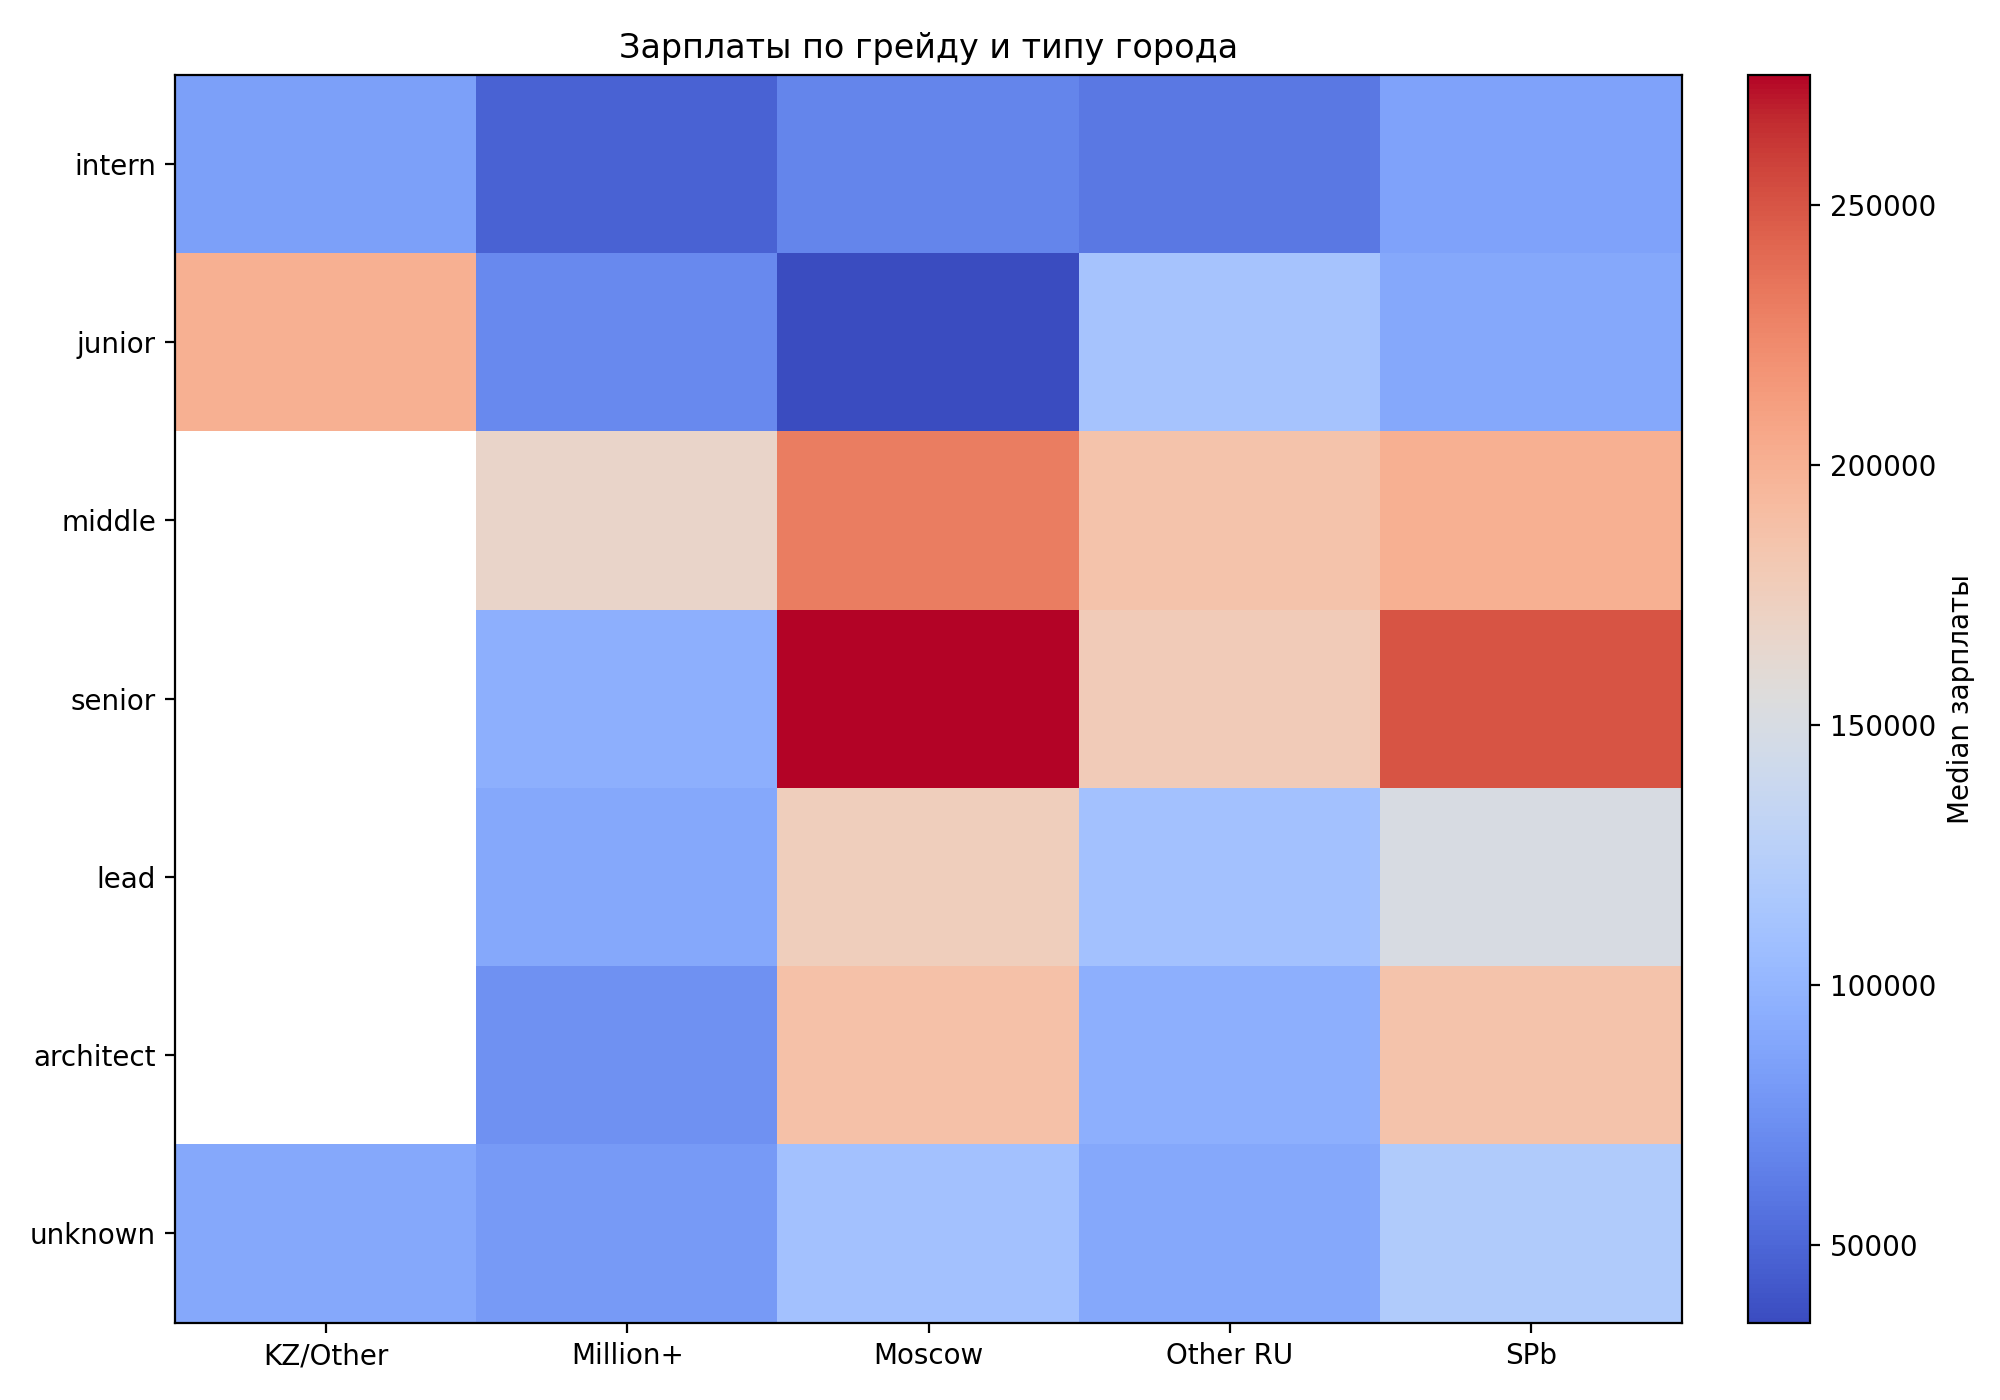

In [16]:
grade_order = viz.GRADE_ORDER
grade_city_summary = eda.salary_summary_by_grade_and_city(df_features)
grade_city_summary["grade"] = pd.Categorical(grade_city_summary["grade"], categories=grade_order, ordered=True)
grade_city_summary = grade_city_summary.sort_values(["grade", "city_tier"])
grade_city_path = viz.salary_by_grade_city_heatmap(
    grade_city_summary
)

display(Image(grade_city_path))


In [17]:
grade_city_pivot = grade_city_summary.pivot(index="grade", columns="city_tier", values="median")
city_tier_share = df_features["city_tier"].value_counts(normalize=True)
salary_spread = {
    "senior_moscow": grade_city_pivot.loc["senior", "Moscow"],
    "senior_regions": grade_city_pivot.loc["senior", "Other RU"],
    "middle_moscow": grade_city_pivot.loc["middle", "Moscow"],
    "middle_regions": grade_city_pivot.loc["middle", "Other RU"],
    "intern_moscow": grade_city_pivot.loc["intern", "Moscow"],
}
city_tier_share, pd.DataFrame([salary_spread])

(city_tier
 Moscow      0.485056
 Other RU    0.295759
 Million+    0.096356
 SPb         0.080416
 KZ/Other    0.042414
 Name: proportion, dtype: float64,
    senior_moscow  senior_regions  middle_moscow  middle_regions  intern_moscow
 0       275000.0        177500.0       230000.0        185000.0        67000.0)

*График: тепловая карта зарплат по грейду и типу города.*
- **Выводы про рынок:** senior остаются с премией даже в регионах, Москва/СПб дают максимальные медианы для всех грейдов.
- **Что это даёт Skillra:** можем объяснять кандидату, как город влияет на ожидания по зарплате для его грейда и стоит ли рассматривать релокацию.

#### 3.2.1a Дополнительные salary-срезы (объём + медиана)
На тепловых картах видно, что основные зарплатные объёмы сосредоточены в Москве и крупных городах (≈66% вакансий), премия по грейду сохраняется даже при узких выборках.

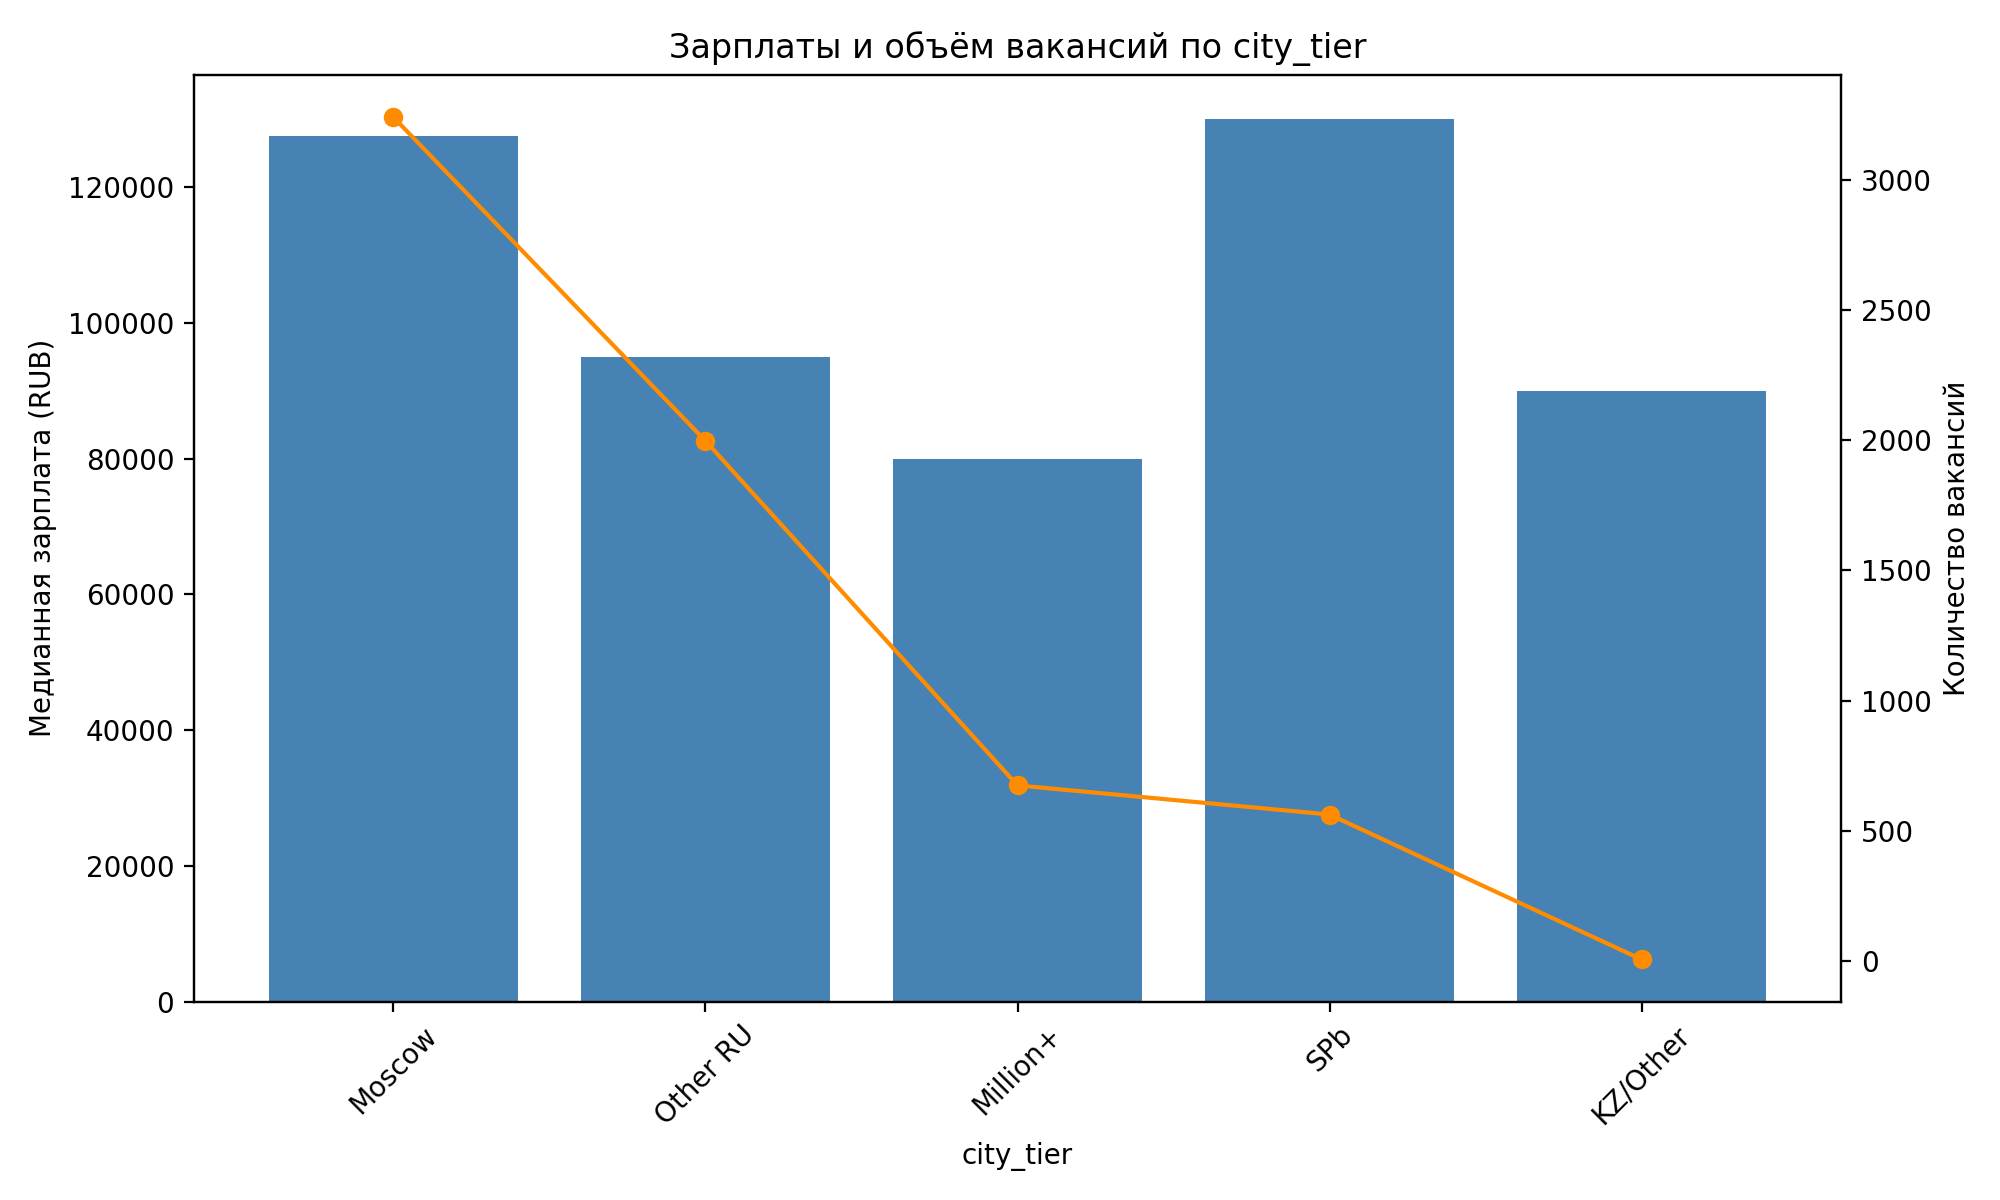

In [18]:
salary_city_path = viz.salary_by_city_mean_count_plot(
    df_features, top_n=8
)

display(Image(salary_city_path))


График: медианные зарплаты и объём вакансий по типу города.
- **Рынок:** Москва/1-й эшелон дают львиную долю спроса и более высокие медианы.
- **Skillra:** можно приоритизировать рекомендации по топ-городам и показывать разницу удалёнки vs офис.

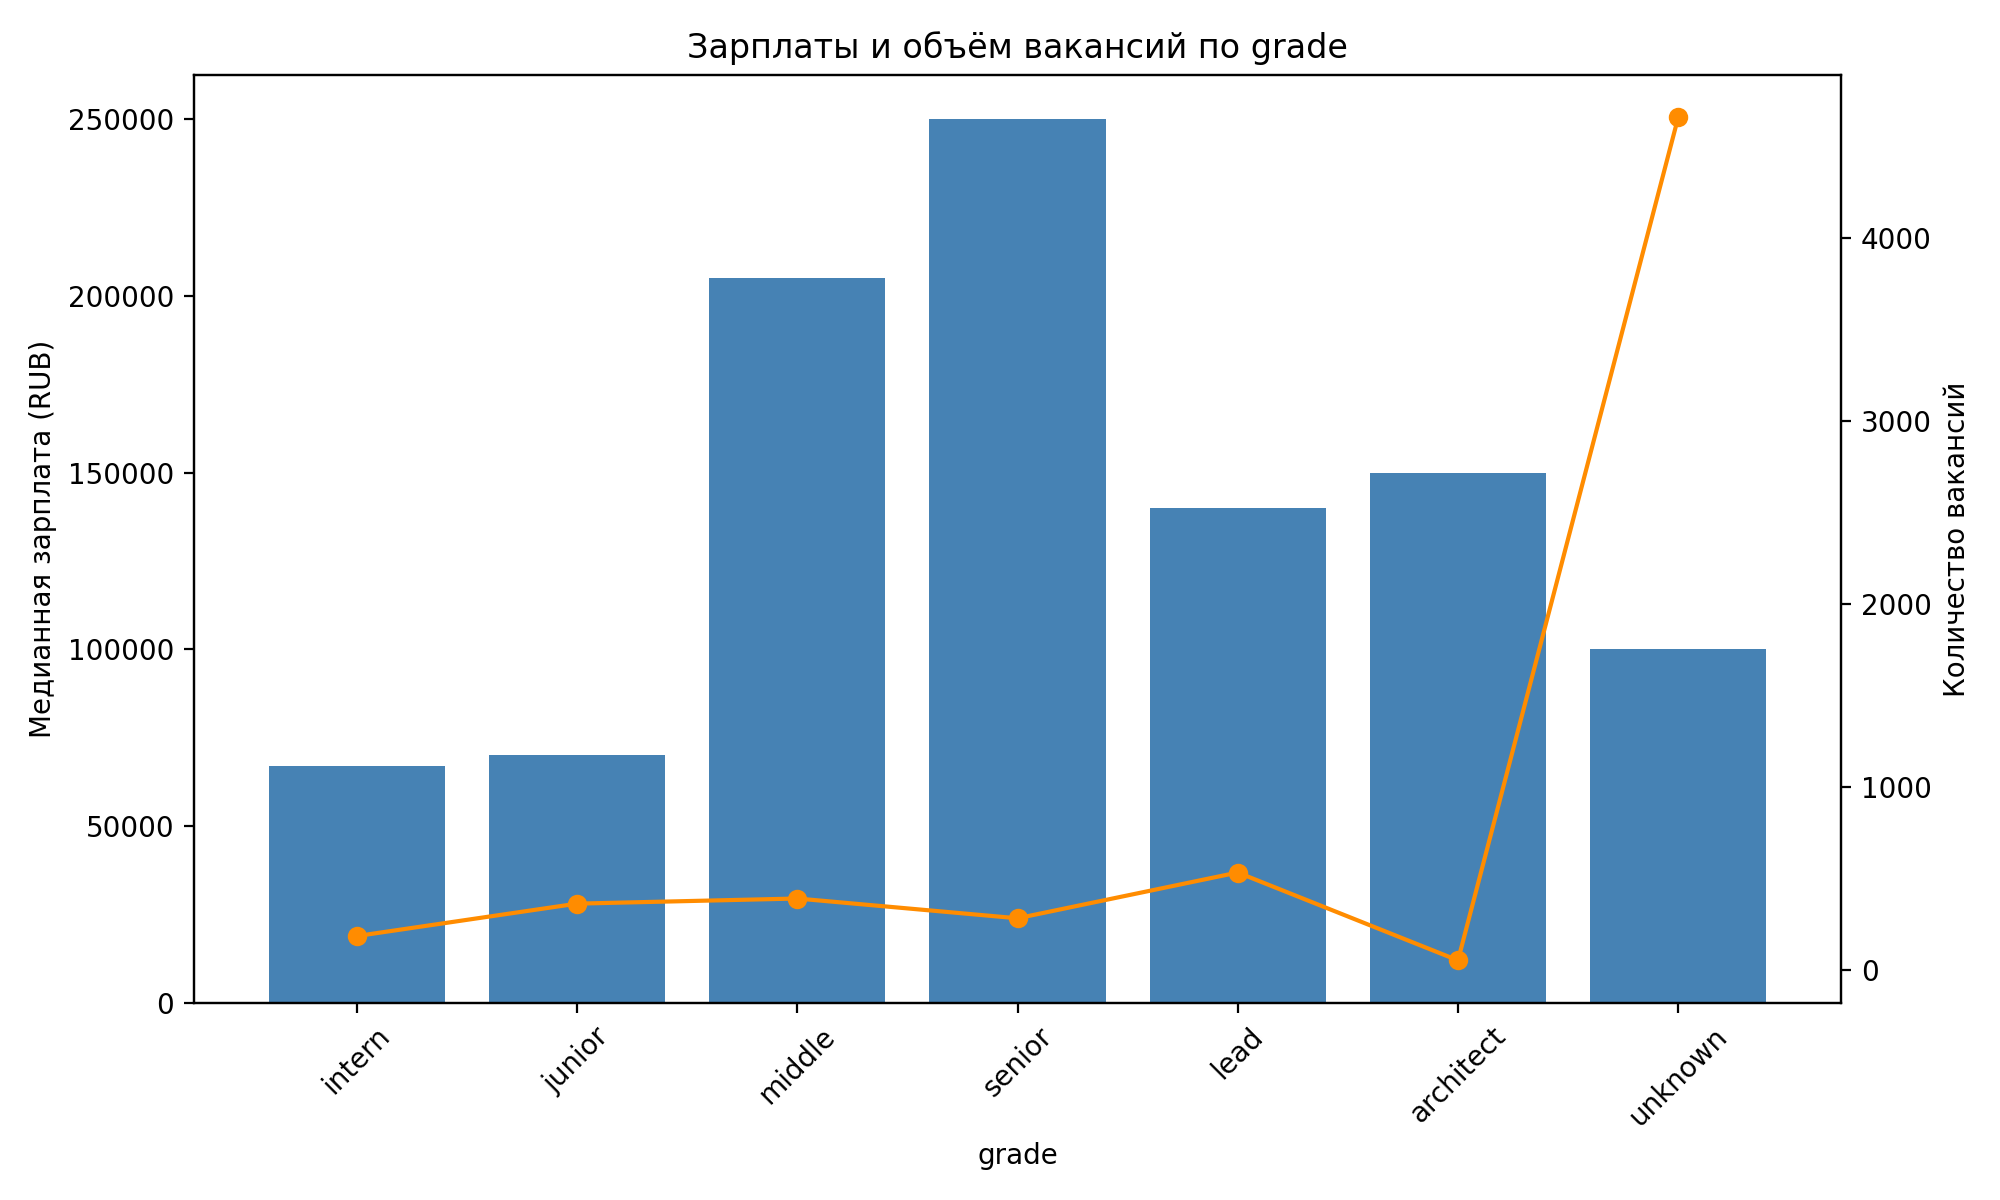

In [19]:
salary_grade_counts_path = viz.salary_by_grade_mean_count_plot(
    df_features
)

display(Image(salary_grade_counts_path))


График: медианные зарплаты и объём вакансий по грейдам.
- **Рынок:** наибольший спрос и устойчивые зарплаты на middle, но заметна премия senior.
- **Skillra:** продукт может объяснять разницу ожиданий по грейдам и планировать апскилл для перехода middle→senior.

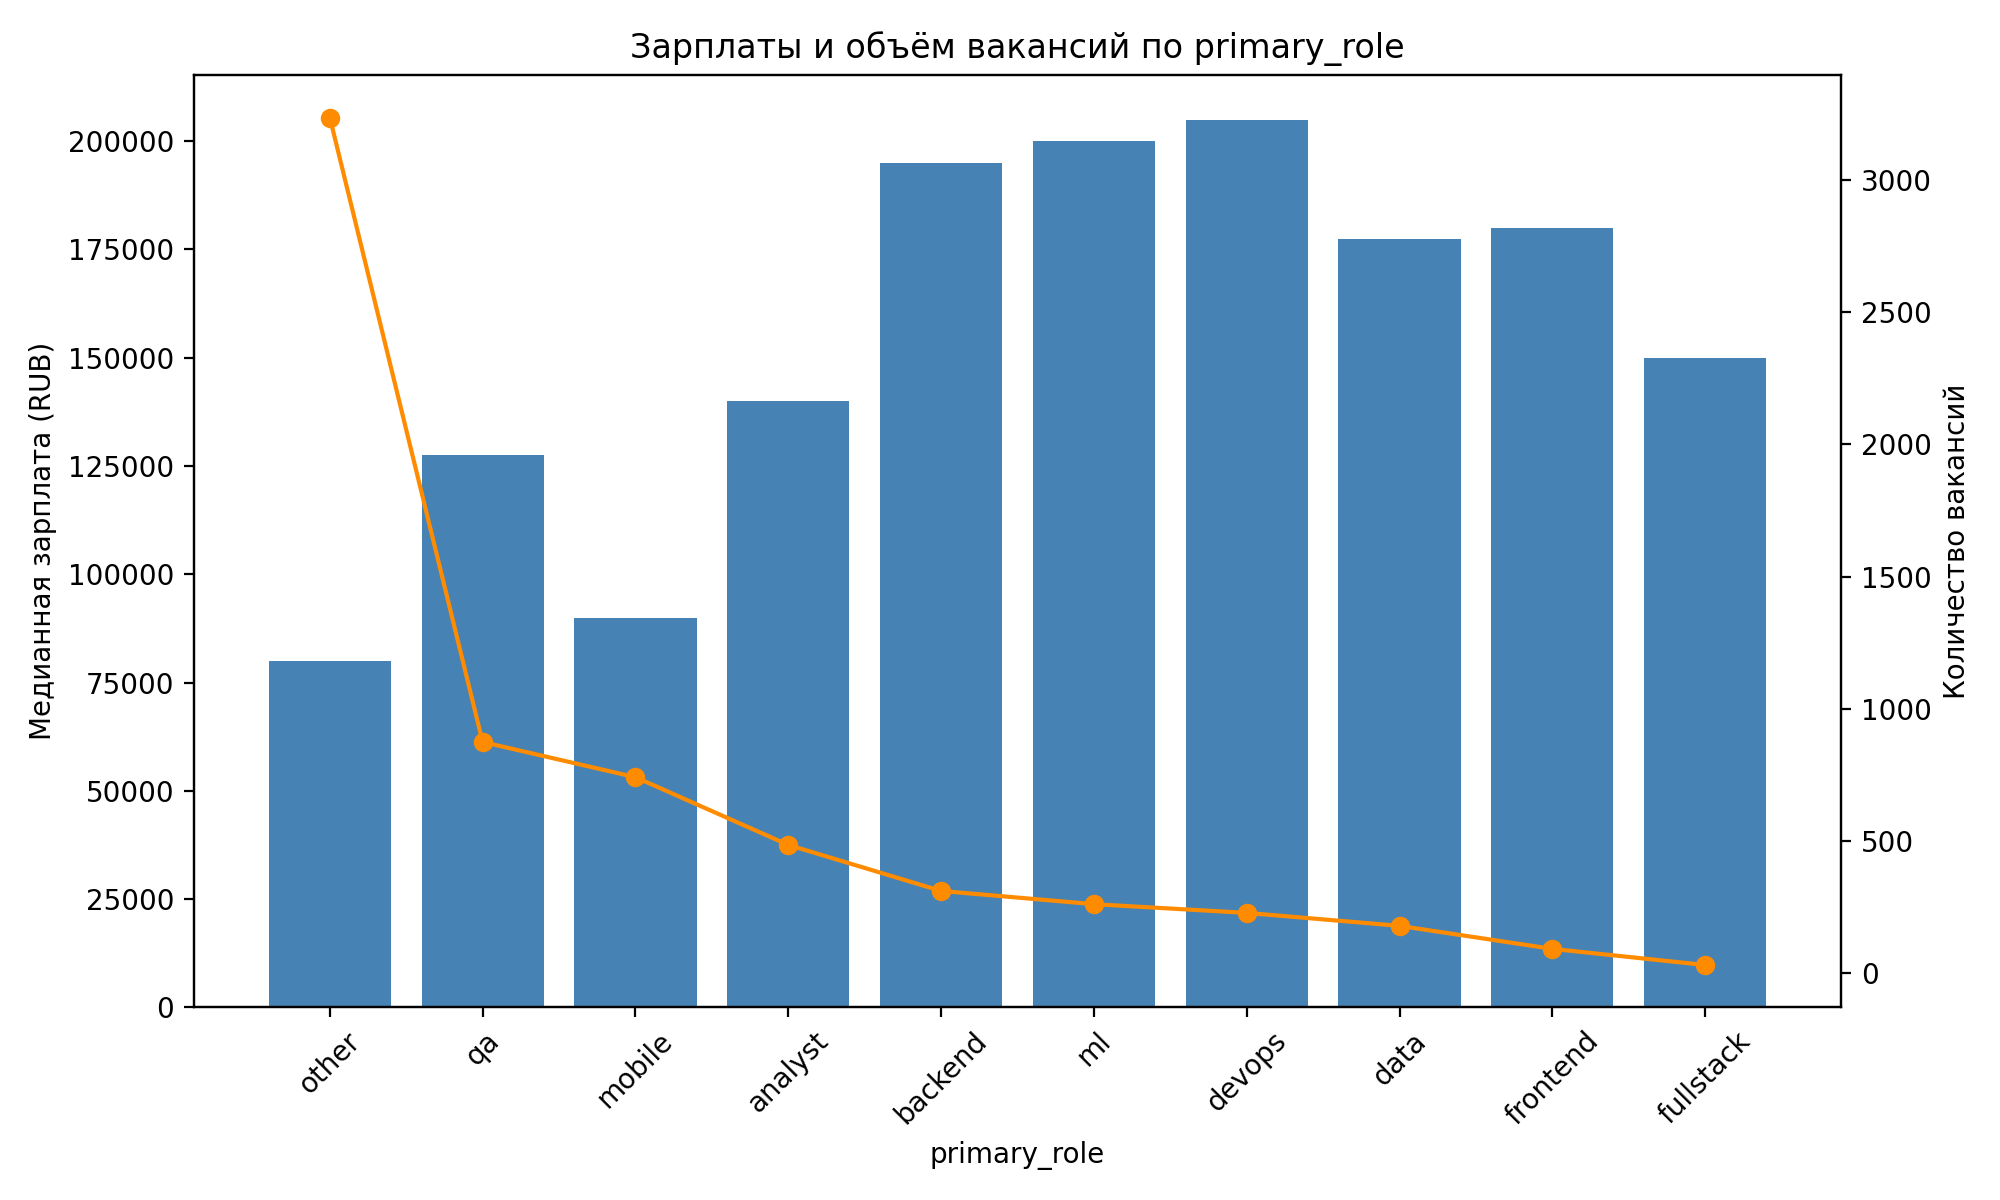

In [20]:
salary_role_counts_path = viz.salary_by_primary_role_mean_count_plot(
    df_features, top_n=10
)

display(Image(salary_role_counts_path))


График: зарплаты и объём по топ-ролям.
- **Рынок:** выше всего медианы у ML/DS, но объём максимален у product/data-ролей.
- **Skillra:** приоритетные треки — data/product, но с пояснением про конкуренцию и требования по стеку.

#### 3.2.1b Зарплаты по ключевым ролям (frontend/fullstack/product)
Чтобы графики не пустовали, используем `role_*` флаги, а при их отсутствии — `primary_role`. Смотрим core-ролей продукта и интерфейса, добавляем backend для сравнения.

,role,n,salary_median,salary_p25,salary_p75
0,frontend,373,180000.0,130000.0,250000.0
1,fullstack,134,180000.0,130000.0,250000.0
2,product,53,190000.0,118087.5,247500.0
3,backend,545,200000.0,133750.0,271250.0


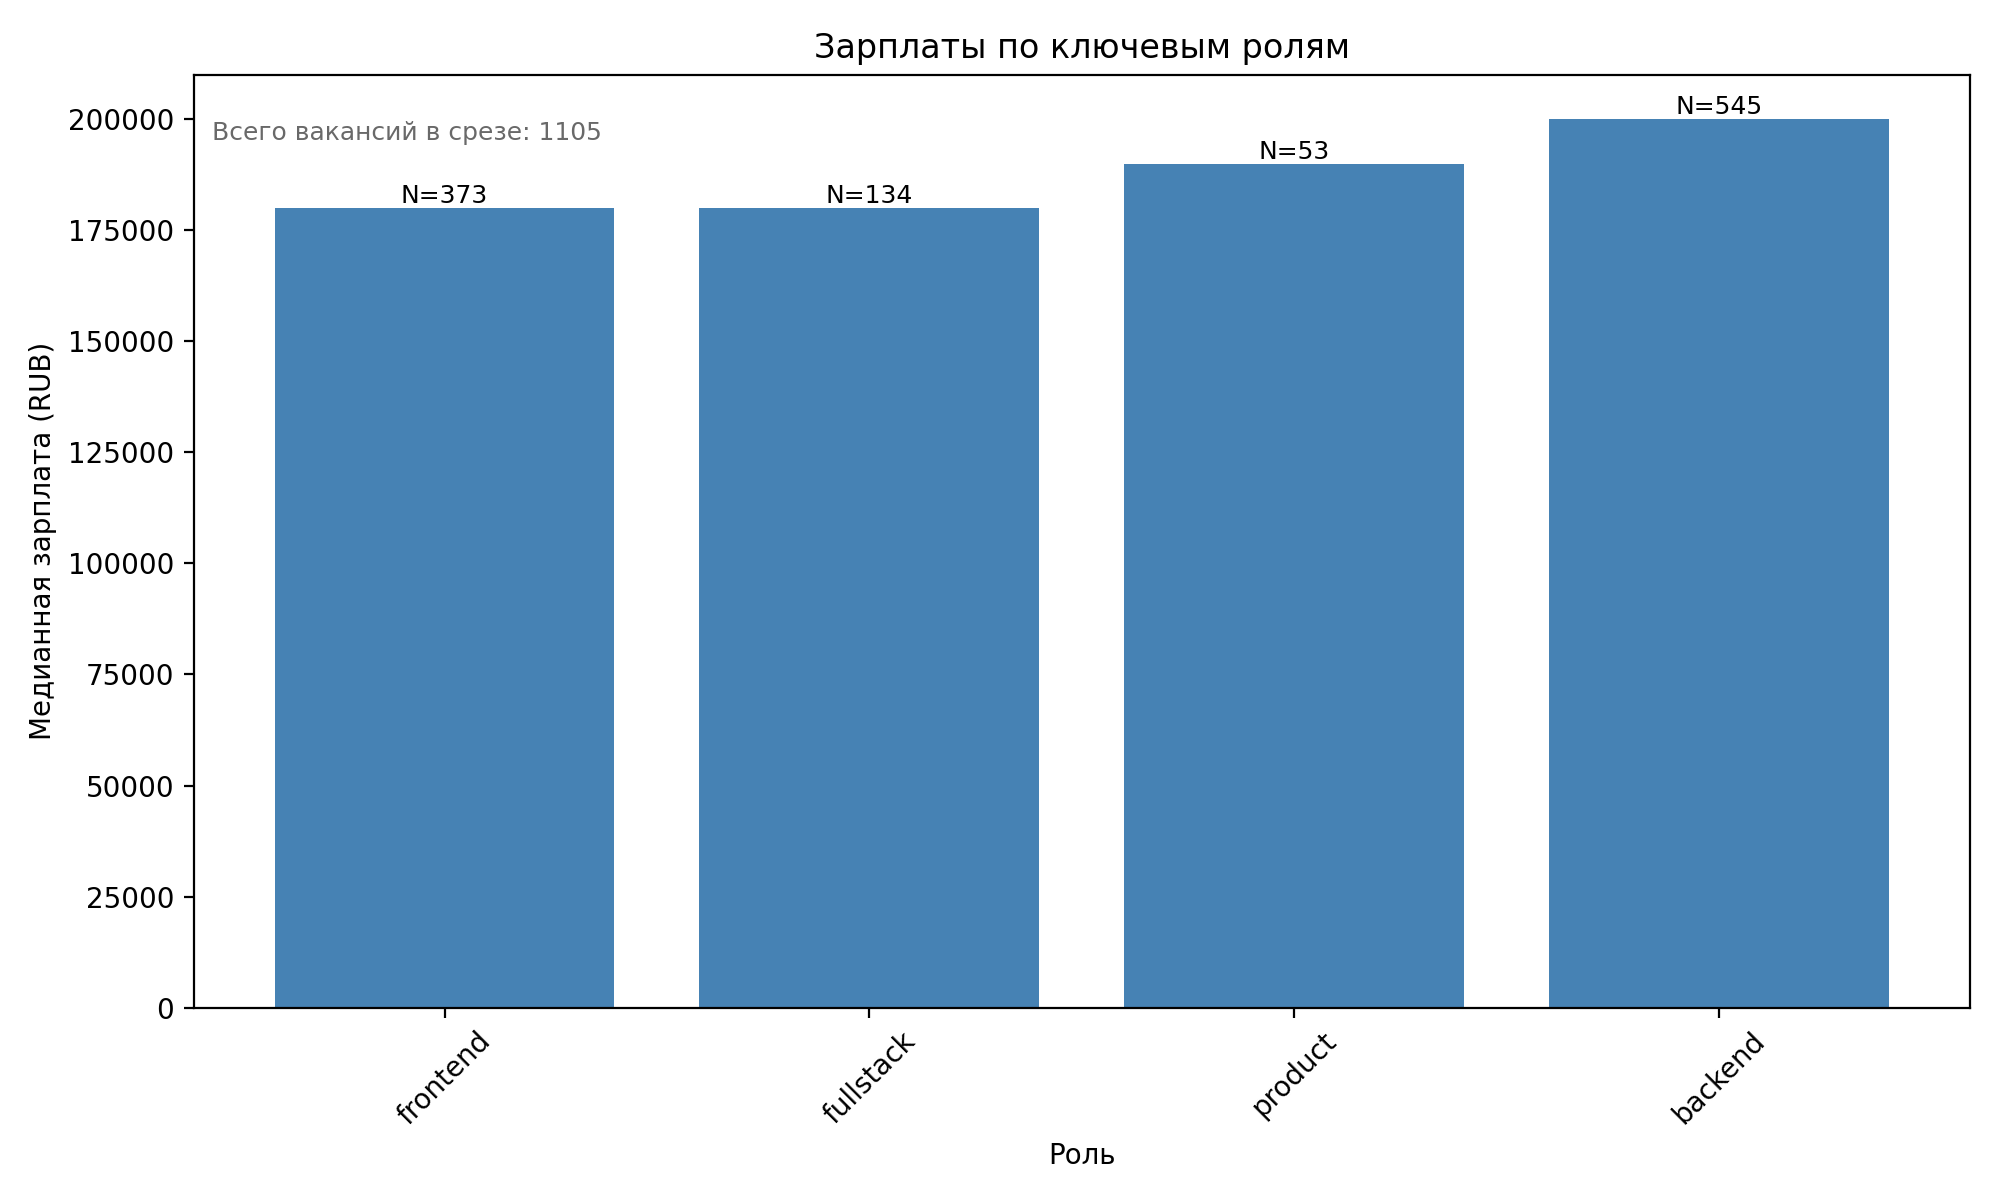

In [21]:
key_roles = ['frontend', 'fullstack', 'product', 'backend']
key_roles_salary = eda.salary_by_roles(df_features, roles=key_roles)

display(key_roles_salary)
salary_key_roles_path = viz.salary_by_roles_bar(
    key_roles_salary
)

display(Image(salary_key_roles_path))


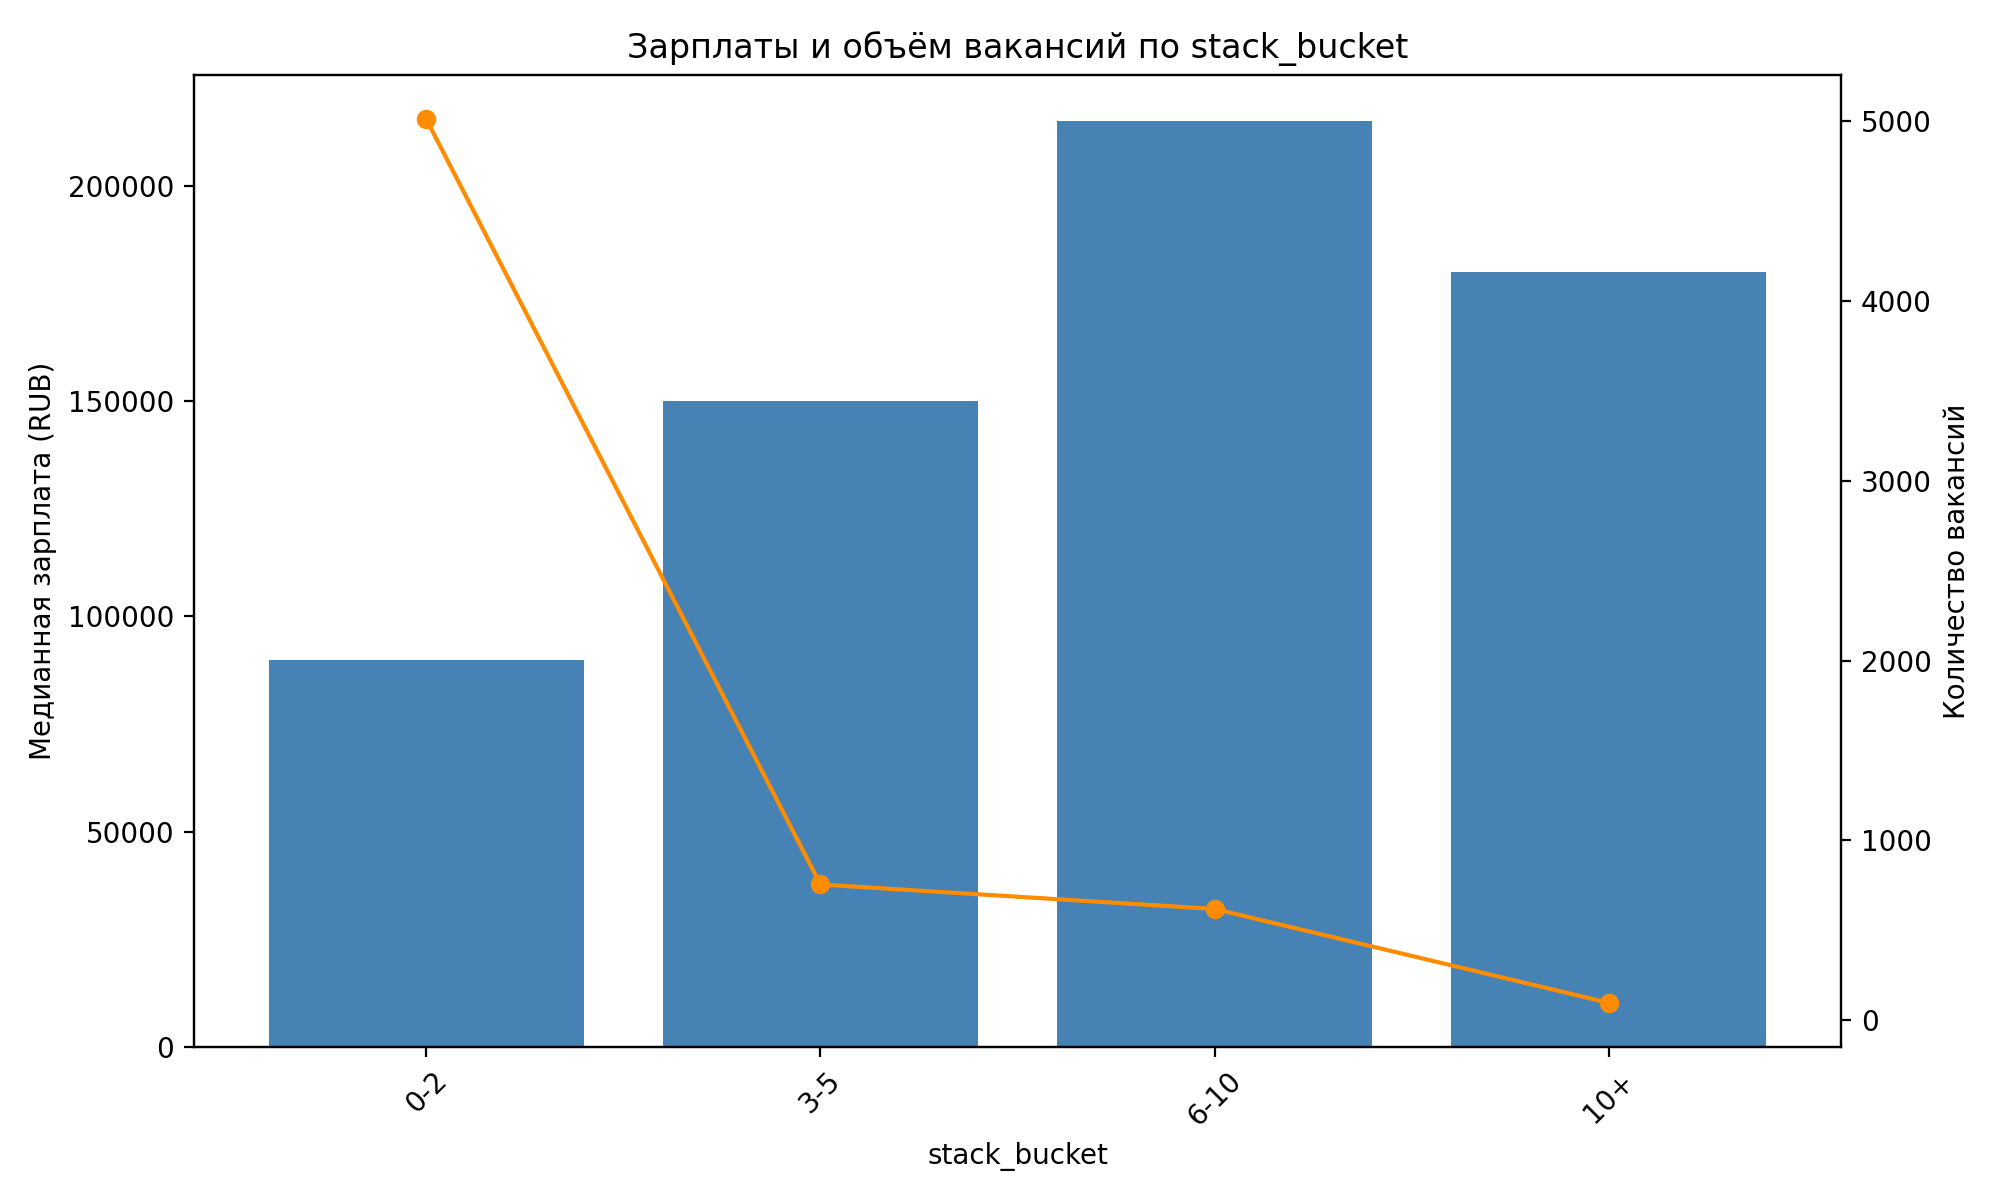

In [22]:
salary_stack_bucket_path = viz.salary_by_skills_bucket_plot(
    df_features
)

display(Image(salary_stack_bucket_path))


График: зарплаты в зависимости от размера стека.
- **Рынок:** рост зарплаты коррелирует с шириной стека до 6–10 технологий, далее эффект плато.
- **Skillra:** в рекомендациях Skillra можно подсветить «оптимальный» стек для роста без избыточного перегруза.

#### 3.2.2 Зарплаты по ролям и формату работы
Удалёнка/гибрид в сумме дают 57% вакансий, офис/field — около 9%; у ML/DevOps/Backend доля remote 71–81%, что отражается на премиях в тепловой карте. 34% work_mode = `unknown`, поэтому итоговые доли форматов стоит трактовать осторожно.

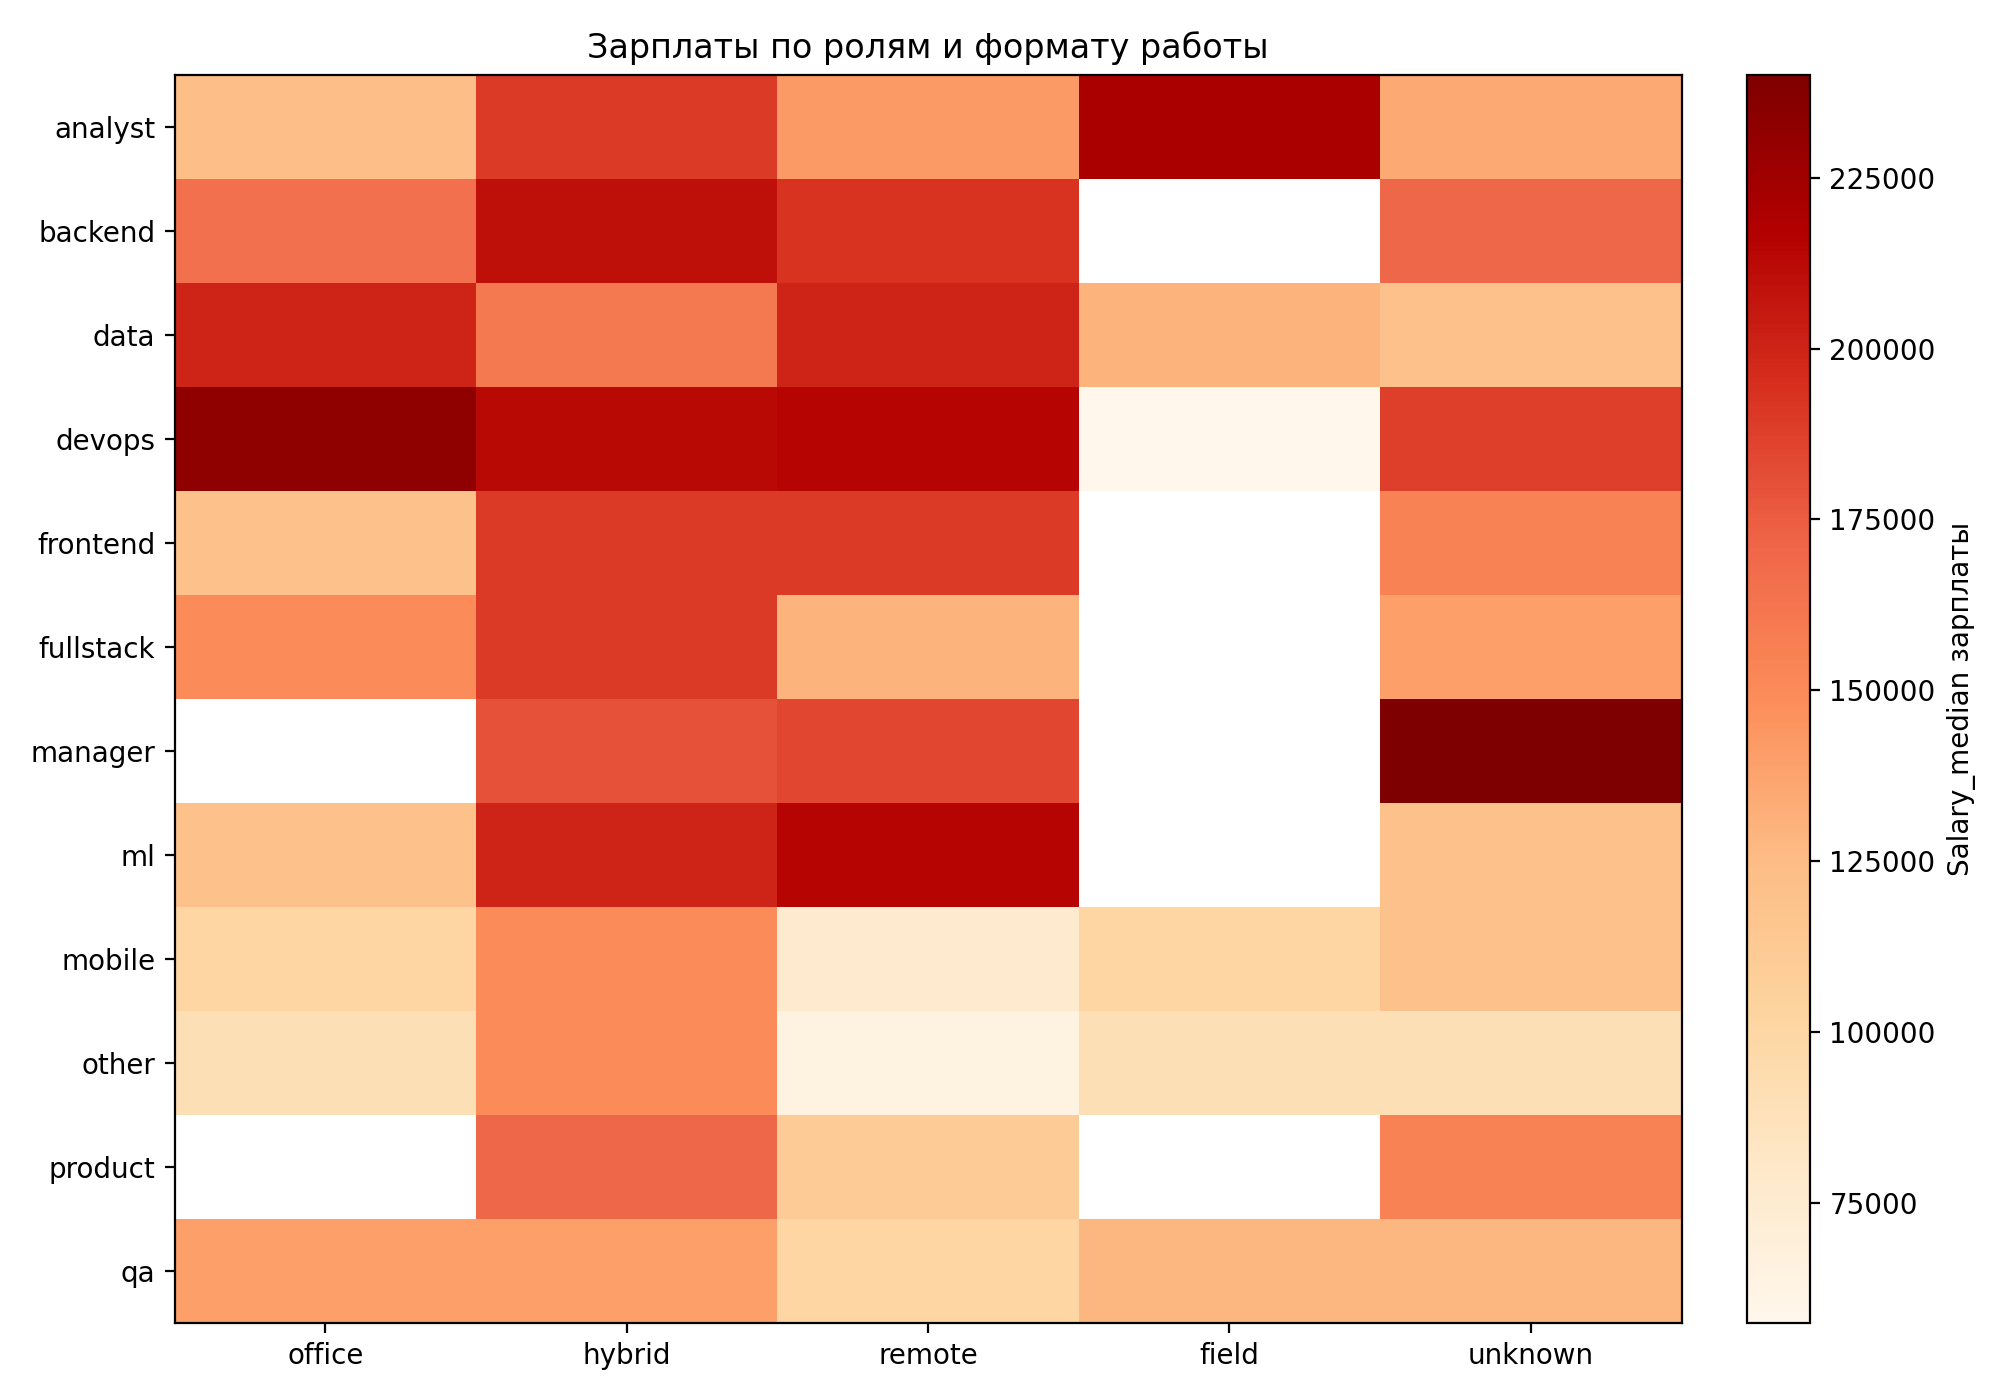

(  primary_role work_mode  salary_median
 0      analyst     field       220500.0
 1      analyst    hybrid       190000.0
 2      analyst    office       123000.0
 3      analyst    remote       142125.0
 4      analyst   unknown       135000.0,
 work_mode        field    hybrid    office    remote   unknown
 primary_role                                                  
 analyst       220500.0  190000.0  123000.0  142125.0  135000.0
 backend            NaN  210000.0  165000.0  192500.0  170000.0
 data          130000.0  160000.0  200000.0  200000.0  120000.0
 devops         57500.0  212500.0  232500.0  215000.0  187500.0
 frontend           NaN  190000.0  120000.0  190000.0  155000.0
 fullstack          NaN  190000.0  150000.0  130000.0  140000.0
 manager            NaN  180000.0       NaN  185000.0  240000.0
 ml                 NaN  200000.0  120000.0  215000.0  120000.0
 mobile        100000.0  150000.0  100000.0   75350.0  120000.0
 other          90000.0  150000.0   90000.0   650

In [23]:
role_work_summary = eda.salary_summary_by_role_and_work_mode(df_features)
role_work_pivot = role_work_summary.pivot(index="primary_role", columns="work_mode", values="salary_median")
role_workmode_path = viz.salary_by_role_work_mode_heatmap(
    role_work_summary
)

display(Image(role_workmode_path))
role_work_summary.head(), role_work_pivot


*График: зарплаты по ролям и формату работы.*
- **Выводы про рынок:** гибрид у продуктовых и аналитических ролей сопоставим с офисом; backend/ML на полном remote часто имеют дисконт.
- **Что это даёт Skillra:** при подборе ролей подсвечиваем, сколько можно ожидать на remote/office и стоит ли искать гибрид ради зарплатной премии.

#### 3.2.3 Доля удалёнки и junior-friendly по ролям
Удалёнка лидирует в ML (81%), backend (71%) и frontend (75%); junior-friendly выше у mobile/other (32–44%) и data-ролей (~30%). Из-за 34% строк с `unknown` work_mode оценки долей удалёнки могут быть смещены.

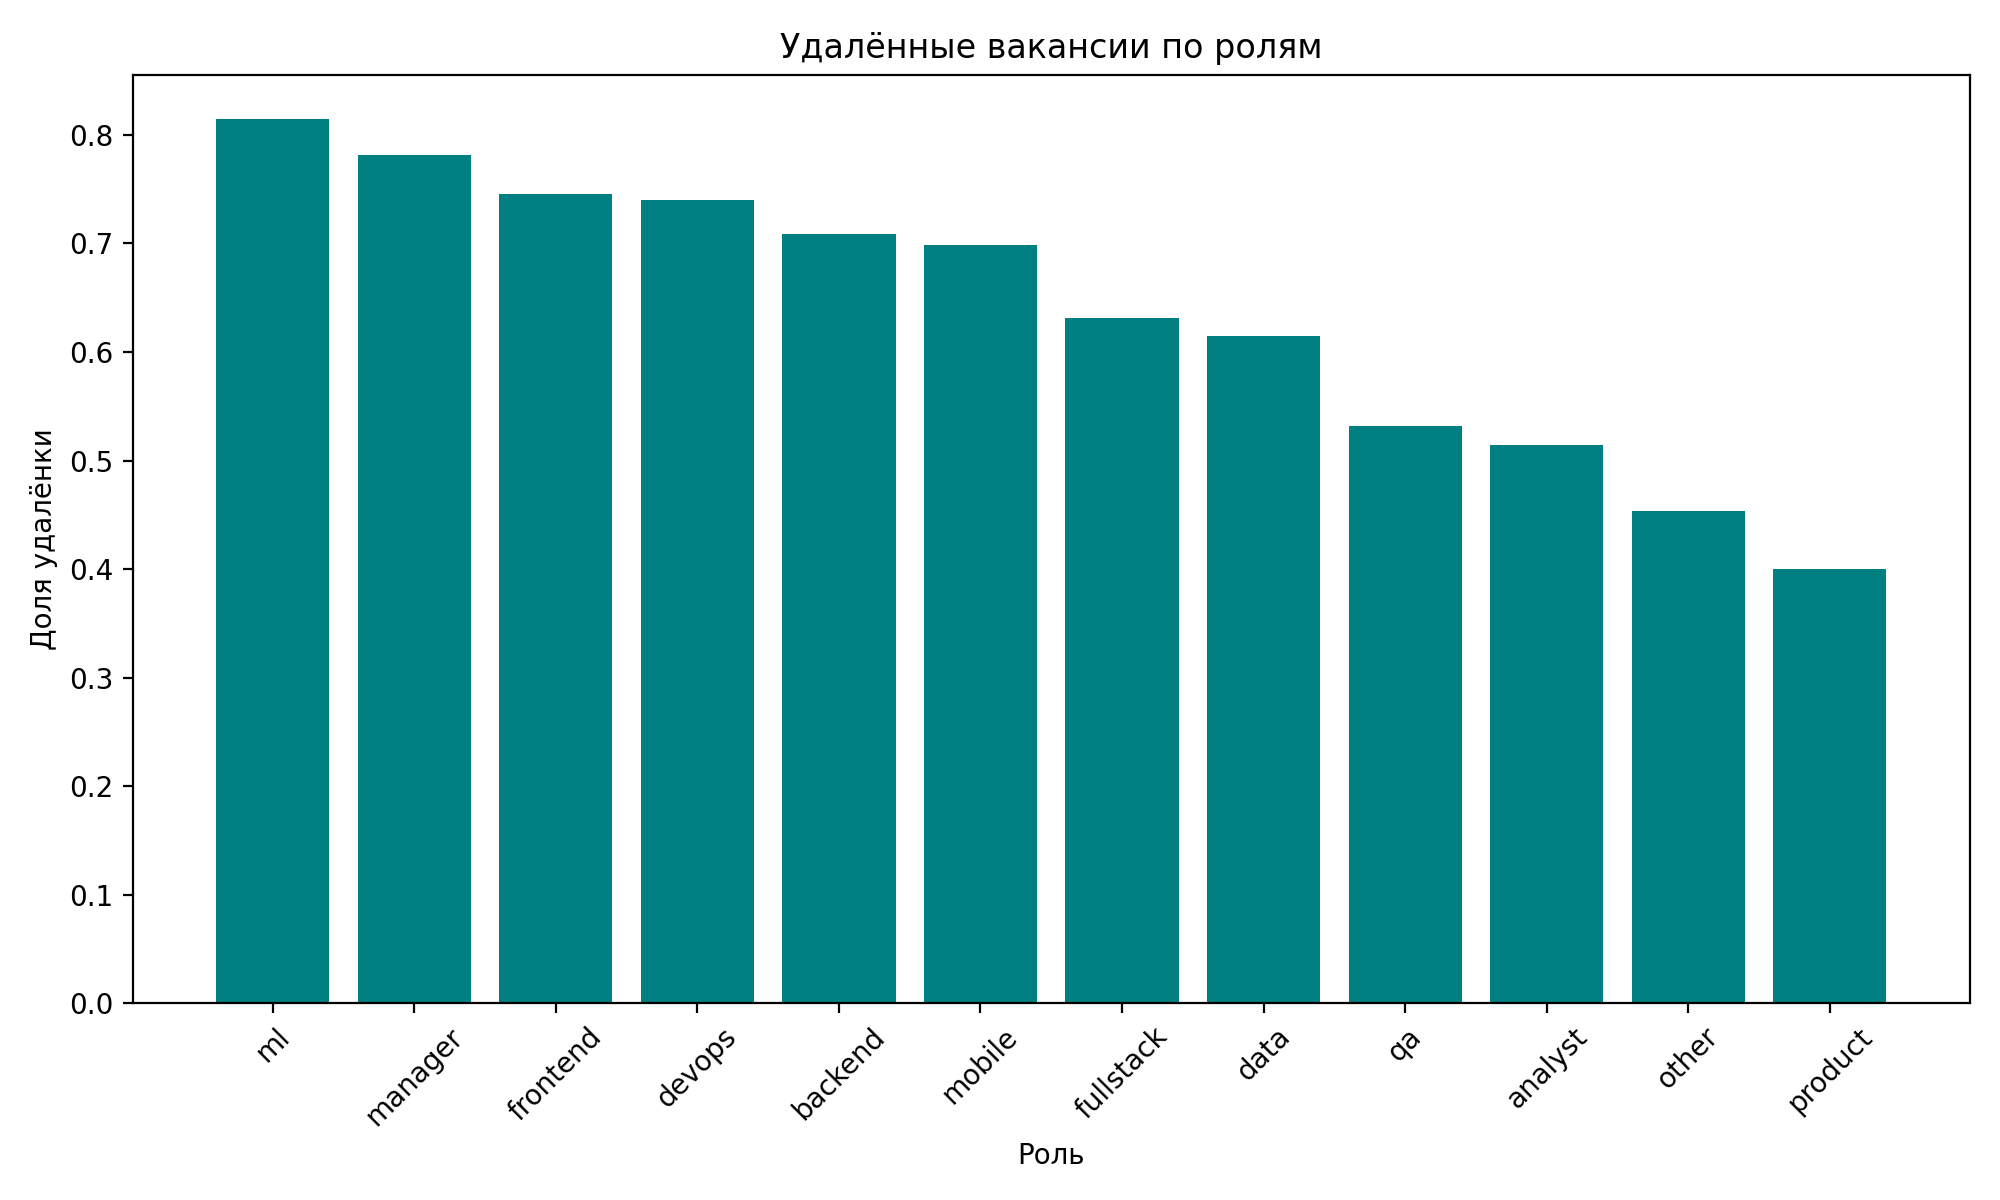

(  primary_role  remote_share
 7           ml      0.814685
 6      manager       0.78125
 4     frontend      0.745455
 3       devops      0.739927
 1      backend      0.708543,
   primary_role  is_junior_friendly  battle_experience
 0      analyst            0.197393           0.802607
 1      backend            0.175879           0.824121
 2         data            0.297561           0.702439
 3       devops            0.201465           0.798535
 4     frontend            0.081818           0.918182)

In [24]:
remote_share = eda.remote_share_by_role(df_features)
junior_roles = eda.junior_friendly_share(df_features, group_col="primary_role")
remote_share_path = viz.remote_share_by_role_bar(remote_share)

display(Image(remote_share_path))
remote_share.head(), junior_roles.head()


In [25]:
work_mode_share = df_features["work_mode"].value_counts(normalize=True, dropna=False)
remote_hybrid_share = work_mode_share.get("remote", 0) + work_mode_share.get("hybrid", 0)
unknown_work_mode_share = work_mode_share.get("unknown", 0)
work_mode_share, remote_hybrid_share, unknown_work_mode_share

(work_mode
 remote     0.515371
 unknown    0.340592
 hybrid     0.055793
 office     0.051238
 field      0.037005
 Name: proportion, dtype: float64,
 np.float64(0.5711642470822659),
 np.float64(0.3405920865357244))

In [26]:
from IPython.display import Markdown, display

remote_hybrid_share = work_mode_share.get("remote", 0) + work_mode_share.get("hybrid", 0)
unknown_work_mode_share = work_mode_share.get("unknown", 0)
work_mode_md = Markdown(
    f"**Форматы работы:** remote+hybrid — {remote_hybrid_share:.1%}, офис — {work_mode_share.get('office', 0):.1%}, field — {work_mode_share.get('field', 0):.1%}, unknown — {unknown_work_mode_share:.1%}. "
    "Высокая доля unknown (треть выборки) смещает выводы по форматам."
)
display(work_mode_md)


**Форматы работы:** remote+hybrid — 57.1%, офис — 5.1%, field — 3.7%, unknown — 34.1%. Высокая доля unknown (треть выборки) смещает выводы по форматам.

### 3.3 Топ работодатели, бенефиты и soft-skills
Определяем лидеров по количеству вакансий и проверяем, какие бенефиты и мягкие навыки они чаще всего упоминают.

In [27]:
top_employers_df = eda.top_employers(df_features)

top_employers_df.head(10)

,company,vacancy_count,salary_median,rating_mean,share
14,Яндекс Крауд: Поддержка,151,33000.0,4.1,0.021492
1,INSOFT,145,45000.0,4.6,0.020638
4,Алабуга. Проектный менеджмент,136,127500.0,4.3,0.019357
11,ОООЛинсофтверпродакшн,107,225000.0,1.3,0.015229
6,Дом.ру,87,56550.0,4.0,0.012383
12,ПАОРостелеком,79,45600.0,3.7,0.011244
0,Aston,63,67000.0,4.6,0.008967
2,Ozon Банк,47,54000.0,4.5,0.006689
9,ОООДжинезис,37,46000.0,3.5,0.005266
8,"Красное & Белое, розничная сеть",37,109000.0,3.4,0.005266


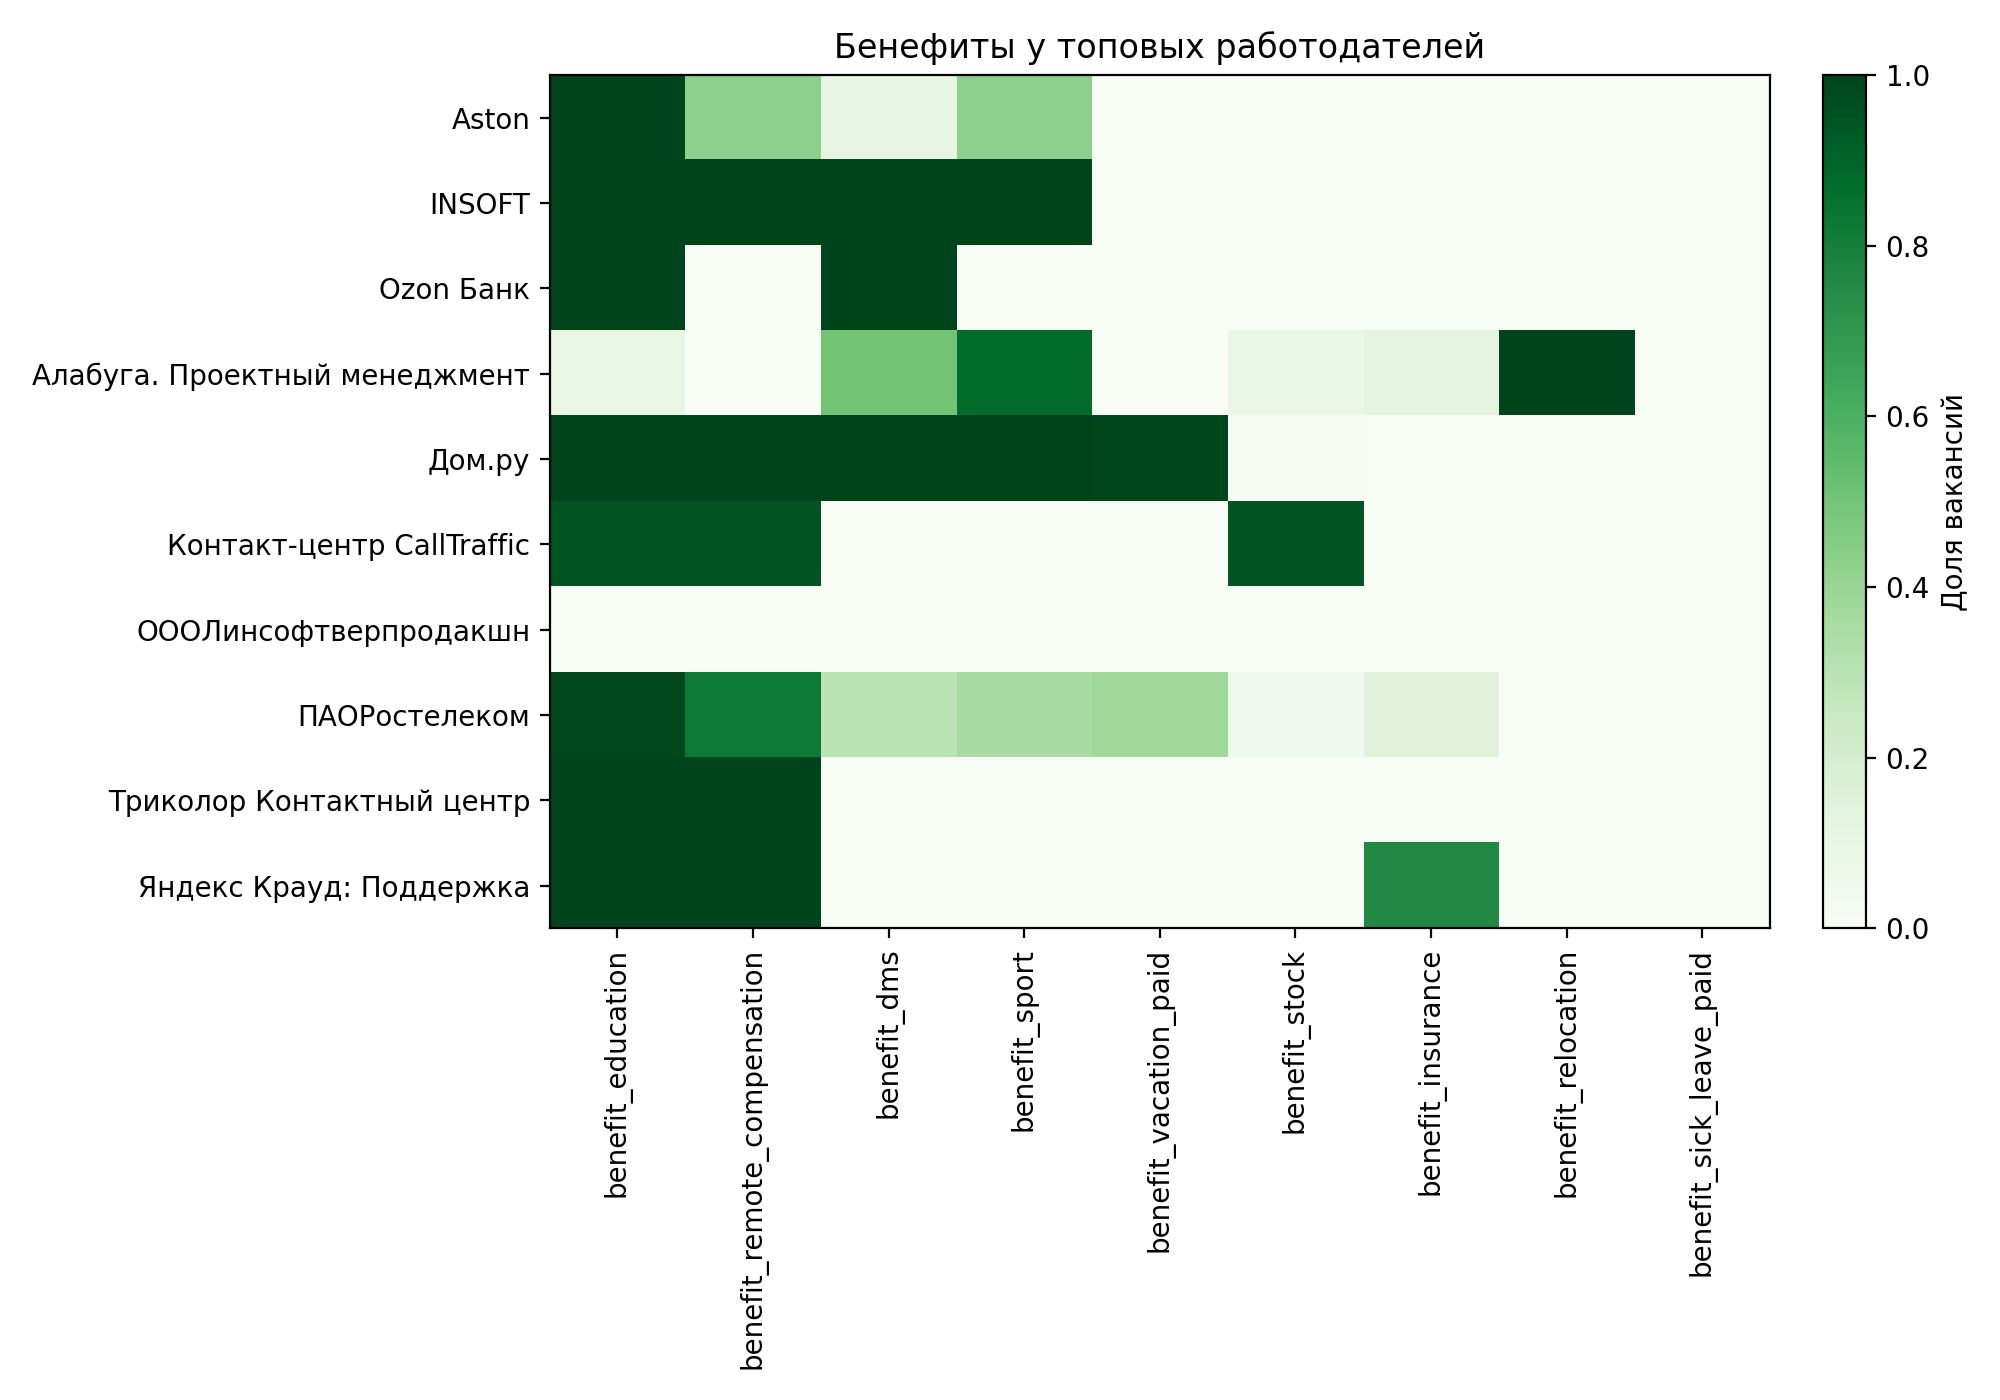

In [28]:
benefits_path = viz.benefits_employer_heatmap(
    df_features,
    top_n_employers=10,
)

display(Image(benefits_path))


График: бенефиты у топ-работодателей.
- **Рынок:** ДМС, релокация и обучение чаще у крупных работодателей.
- **Skillra:** можно рекомендовать компании с подходящими пакетами и объяснять, где искать ДМС/релокацию.

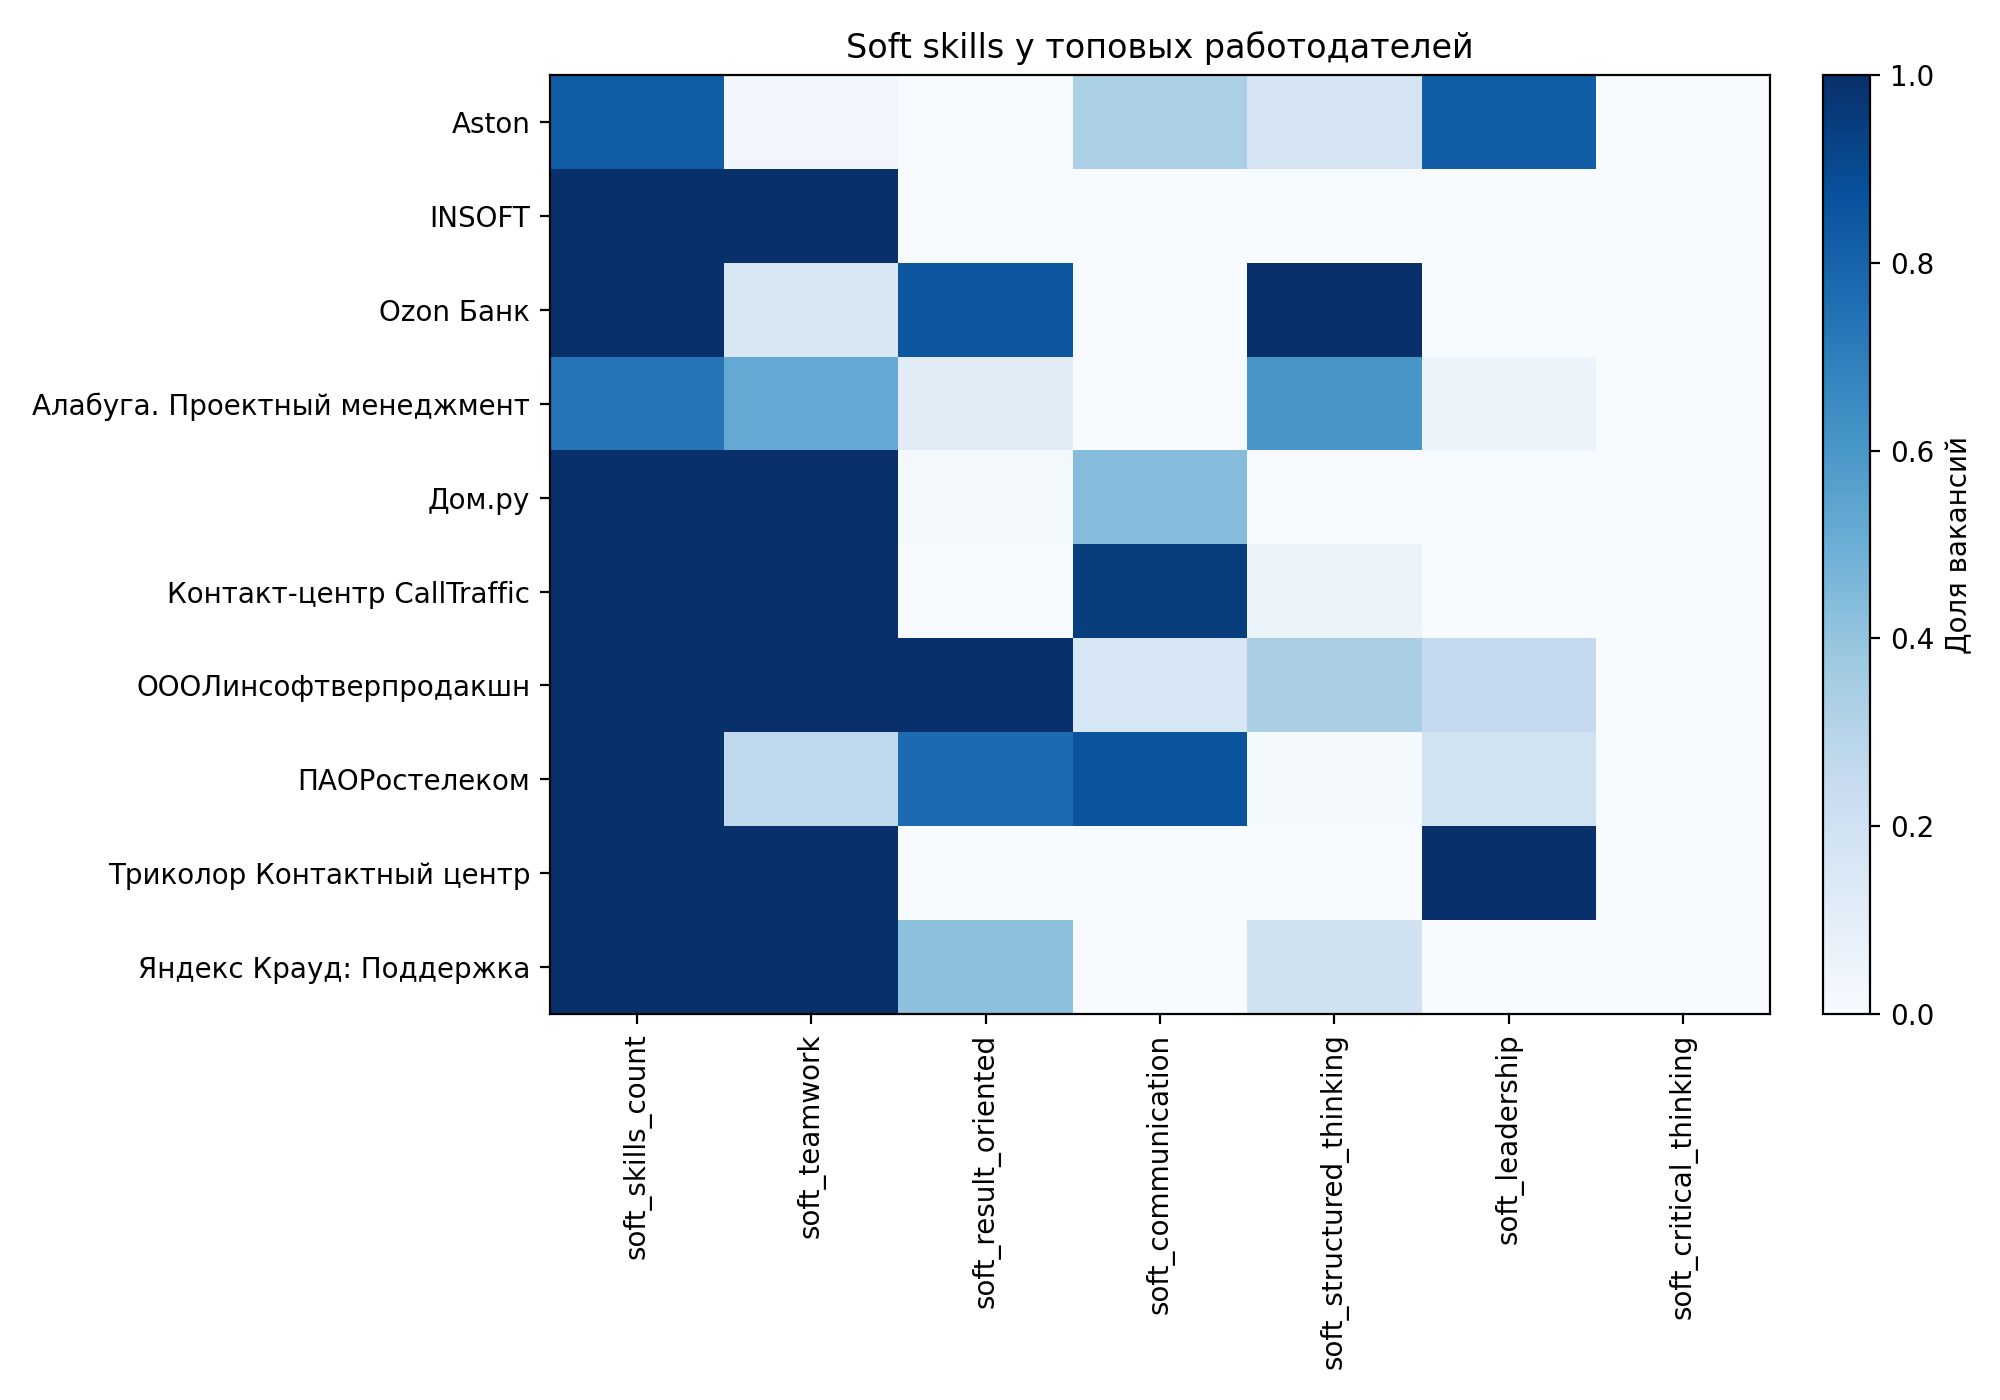

In [29]:
soft_path = viz.soft_skills_employer_heatmap(
    df_features,
    top_n_employers=10,
)

display(Image(soft_path))


График: soft skills у топ-работодателей.
- **Рынок:** коммуникация, аналитическое мышление и командная работа встречаются чаще всего.
- **Skillra:** объясняем пользователям, какие soft skills нужны для входа в топ-компании.

#### 3.3.1 Топ навыков для data-ролей

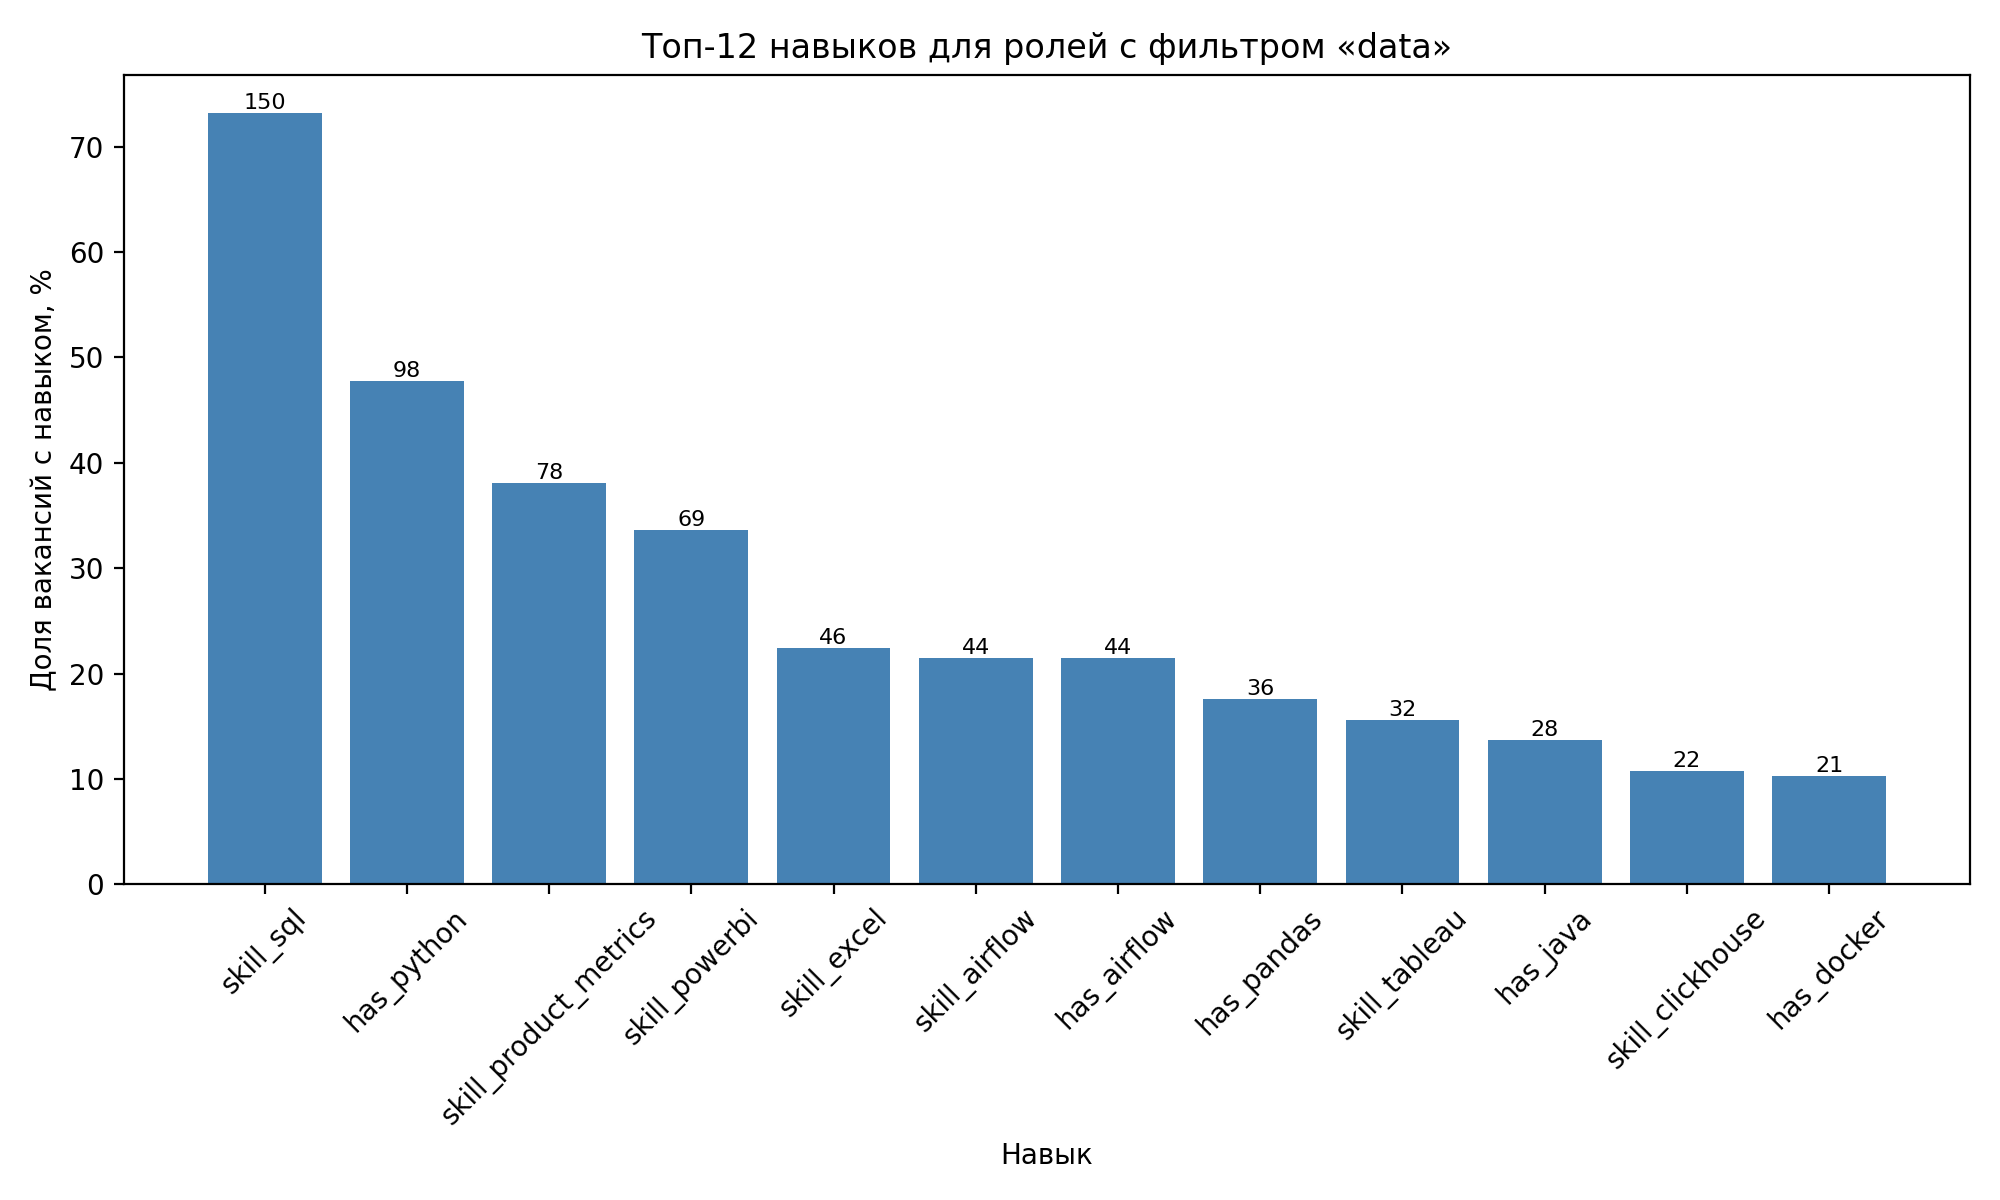

In [30]:
skill_cols = eda.hard_skill_columns(df_features)
top_skills_path = viz.top_skills_bar(
    df_features, skill_cols=skill_cols, role_filter="data", top_n=12
)

def humanize_skill(skill: str) -> str:
    if hasattr(viz, "_humanize_skill_name"):
        return viz._humanize_skill_name(skill)
    return skill.replace("skill_", "").replace("has_", "").replace("_", " ").strip()

display(Image(top_skills_path))


In [31]:
data_roles_mask = df_features["primary_role"].str.contains("data", case=False, na=False)
data_skill_freq = df_features.loc[data_roles_mask, skill_cols].sum().sort_values(ascending=False).head(10)
data_role_count = int(data_roles_mask.sum())
data_role_count, data_skill_freq


(205,
 skill_sql                150
 has_python                98
 skill_product_metrics     78
 skill_powerbi             69
 skill_excel               46
 skill_airflow             44
 has_airflow               44
 has_pandas                36
 skill_tableau             32
 has_java                  28
 dtype: Int64)

In [32]:
data_top = data_skill_freq.head(5)
skill_lines = [
    f"{humanize_skill(skill)} — {count / data_role_count:.1%} (n={int(count)})"
    for skill, count in data_top.items()
]
skill_md = Markdown(
    f"""
Data-вакансий: {data_role_count}.
Топ-5 хард-скиллов (доля строк):
{'<br>'.join(skill_lines)}
Высокая доля unknown work_mode={work_mode_share.get('unknown', 0):.1%} может смещать оценки сегмента.
"""
)
display(skill_md)



Data-вакансий: 205.
Топ-5 хард-скиллов (доля строк):
SQL — 73.2% (n=150)<br>Python — 47.8% (n=98)<br>Product Metrics — 38.0% (n=78)<br>Power BI — 33.7% (n=69)<br>Excel — 22.4% (n=46)
Высокая доля unknown work_mode=34.1% может смещать оценки сегмента.


In [33]:
top3 = ', '.join(humanize_skill(skill) for skill in data_top.index[:3])
insight_md = Markdown(
    f"*Data-рынок держится на базе {top3}: они появляются чаще всего и должны идти первыми в рекомендациях Skillra.*"
)
display(insight_md)


*Data-рынок держится на базе SQL, Python, Product Metrics: они появляются чаще всего и должны идти первыми в рекомендациях Skillra.*

#### Выводы по работодателям
- Топ-10 компаний покрывают 12.7% выборки: от поддержки (Яндекс Крауд, 2.1% вакансий, медиана 33k) до интеграторов с медианой 225k — важно смотреть на стек и роль.
- Часто встречающиеся бенефиты: ДМС, гибкий график, возможность удалёнки/релокации.
- В soft-skills топе — коммуникация и самоорганизация; на них стоит делать акцент при подготовке кандидатов.

### 3.4 Английский и образование
Смотрим требования к языку и образованию: распределения долей, премии по зарплатам и их интерпретация.

In [34]:
req_df = df_features.copy()
for col in ["lang_english_required", "edu_required", "edu_technical"]:
    if col in req_df:
        req_df[col] = req_df[col].fillna(False)

english_stats = eda.english_requirement_stats(req_df)
education_stats = eda.education_requirement_stats(req_df)
english_unknown_share = 1 - english_stats["share"].sum()
education_unknown_share = 1 - education_stats["share"].sum()
english_stats, education_stats, english_unknown_share, education_unknown_share

(  english_level  vacancy_count  salary_median  salary_q25  salary_q75  \
 4    no_english           5949       100000.0     60000.0    175000.0   
 0            A2            310       150000.0    103837.5    230000.0   
 2            B2            114        75000.0     67000.0    150000.0   
 1            B1             58       155000.0     90000.0    222500.0   
 3       C1_plus             50       185000.0    113750.0    250000.0   
 
       share  
 4  0.846712  
 0  0.044122  
 2  0.016225  
 1  0.008255  
 3  0.007116  ,
       education_level  vacancy_count  salary_median  salary_q25  salary_q75  \
 2  no_degree_required           3972       100250.0     56550.0    189812.5   
 3      technical_only           1291       120000.0     80000.0    184450.0   
 0          any_degree           1176        92000.0     62500.0    150000.0   
 1          master_phd             42        92125.0     64000.0    135000.0   
 
       share  
 2  0.565329  
 3  0.183746  
 0  0.167378  
 

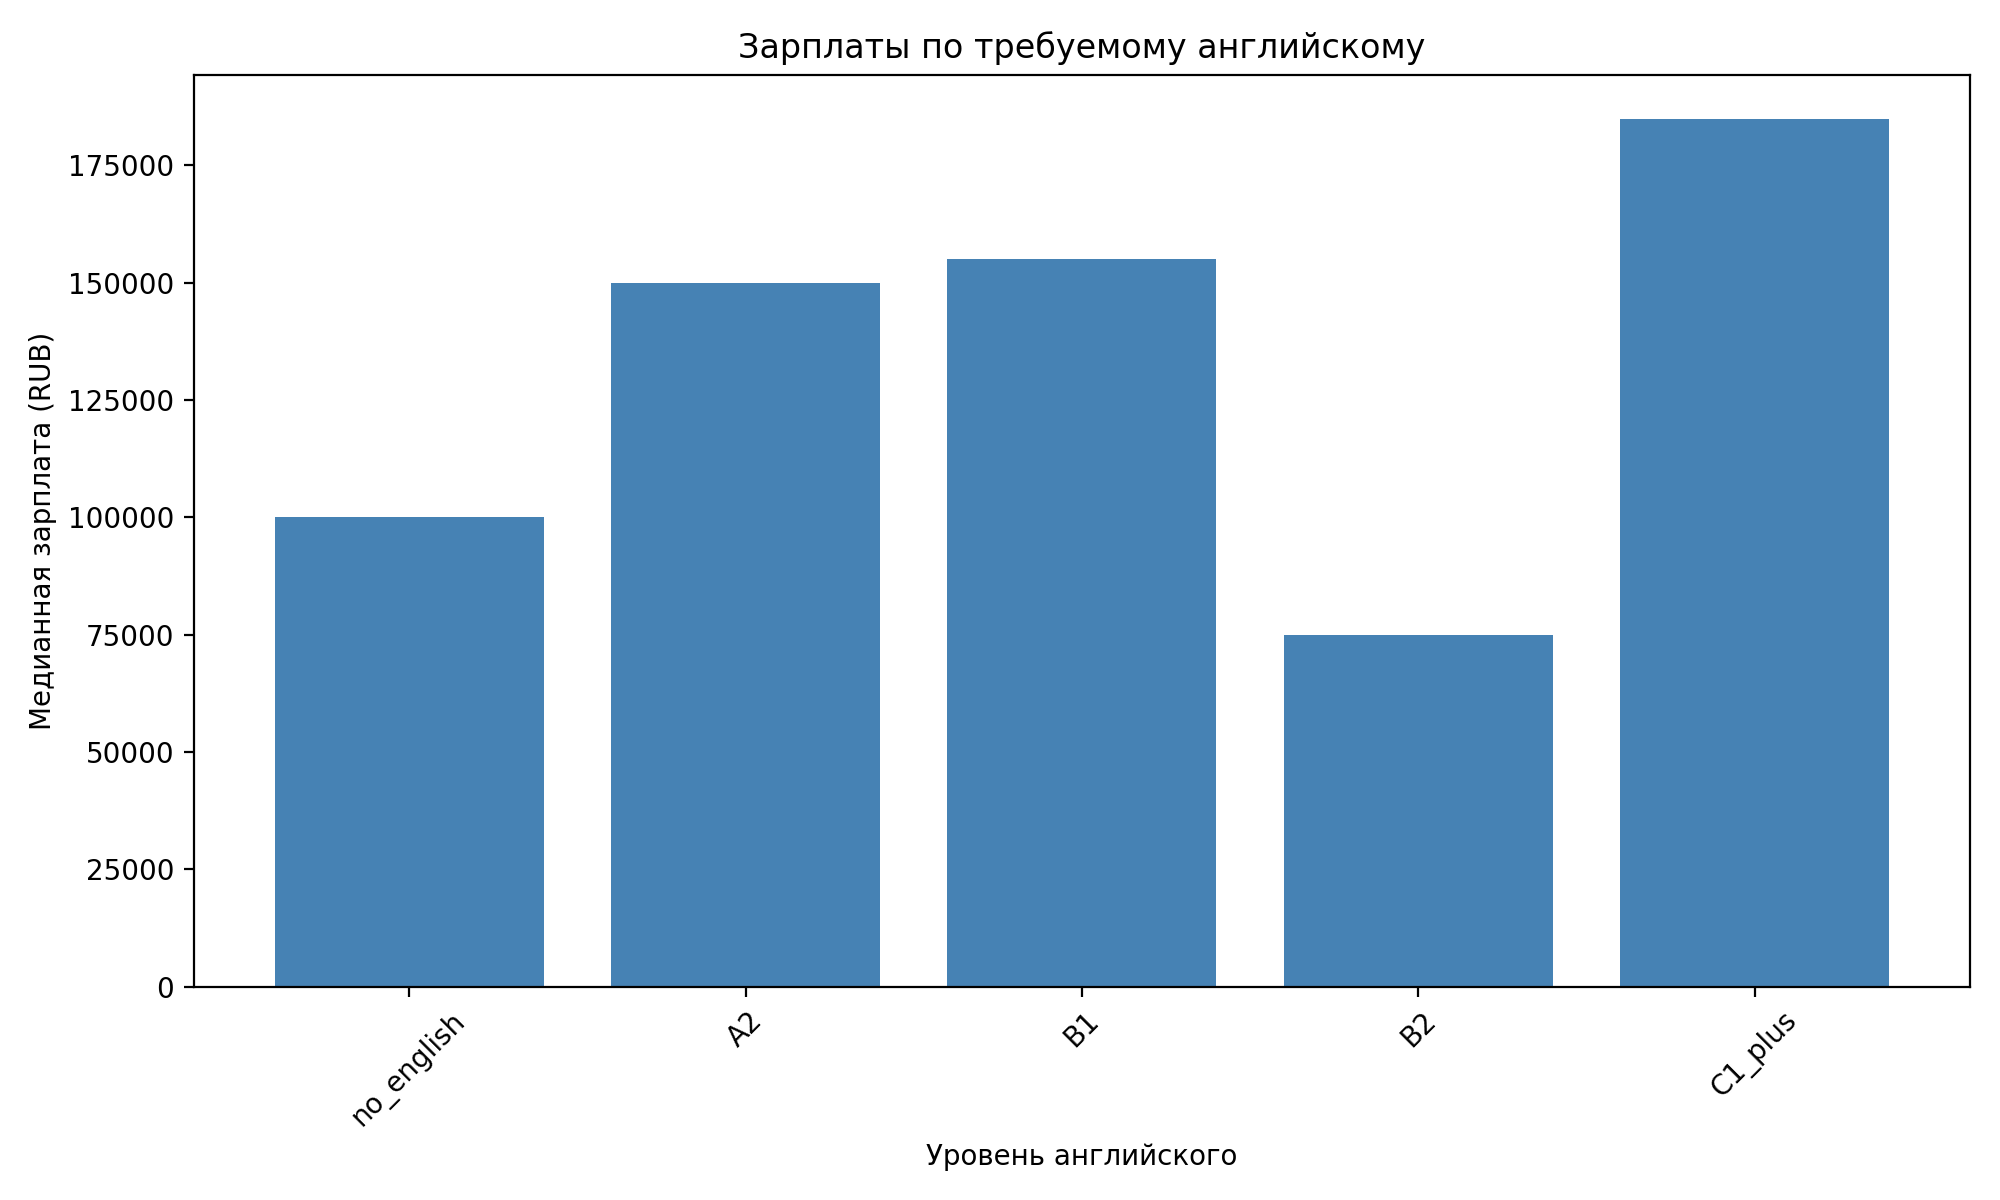

In [35]:
salary_english_path = viz.salary_by_english_level_plot(req_df)

display(Image(salary_english_path))


График: зарплаты по требуемому уровню английского.
- **Рынок:** явное требование английского встречается редко (B2+ всего 2.3%), медианы в этих сегментах 150–185k, но из-за малого объёма и 7.8% строк без уровня выводы требуют осторожности.
- **Skillra:** мотивируем улучшать английский для доступа к верхним вилкам и международным командам, но отмечаем низкую полноту метки.

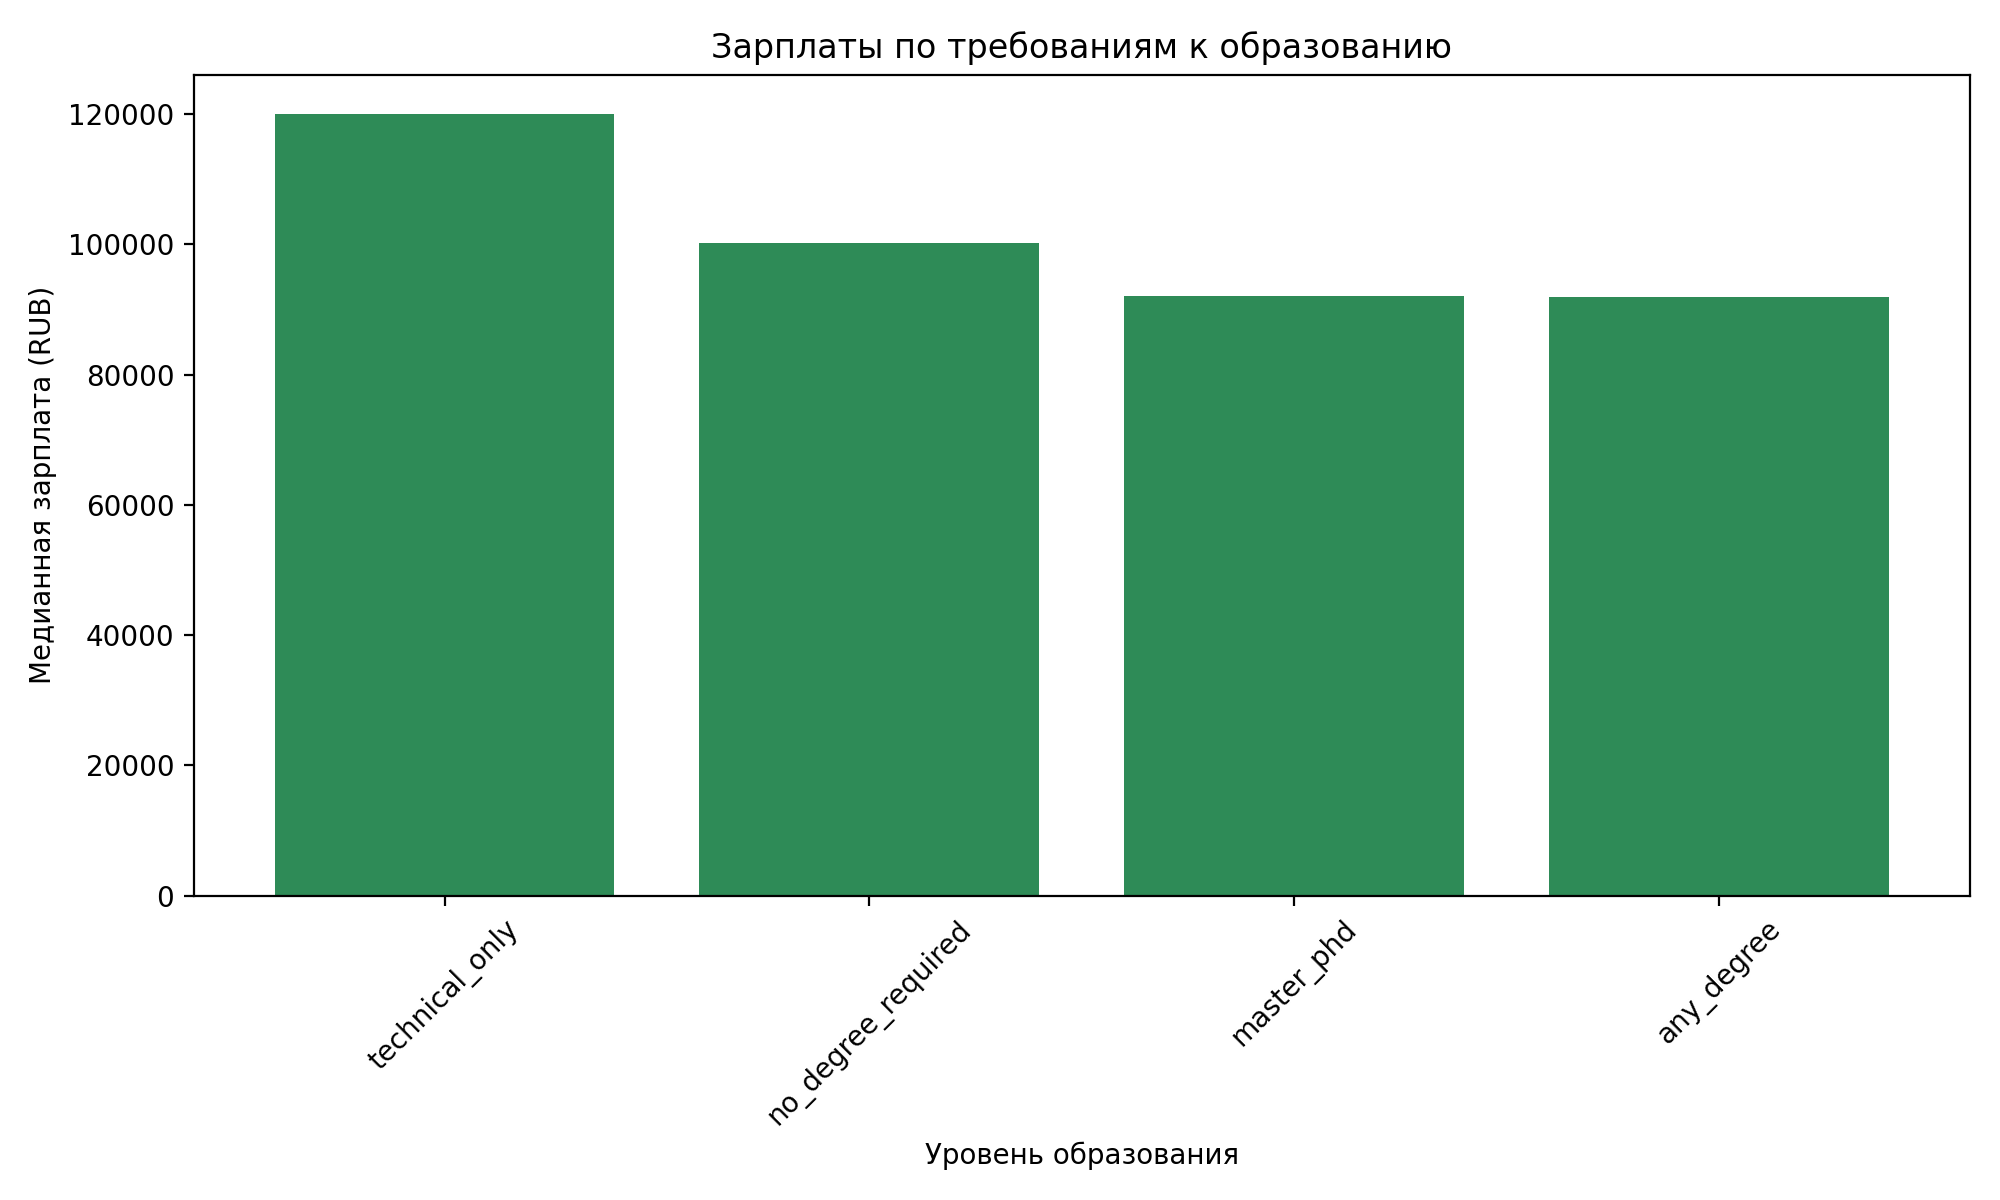

In [36]:
salary_edu_path = viz.salary_by_education_level_plot(req_df)

display(Image(salary_edu_path))


График: зарплаты по требованиям к образованию.
- **Рынок:** сильной премии за формальное образование нет, важнее навыки и релевантный опыт.
- **Skillra:** упор на доказуемые навыки и проекты, а не на диплом; это снижается барьер входа для свитчеров.

In [37]:
from IPython.display import Markdown, display

english_unknown_share = 1 - english_stats["share"].sum()
education_unknown_share = 1 - education_stats["share"].sum()
no_english_share = english_stats.loc[english_stats['english_level'] == 'no_english', 'share'].iat[0]
b2plus_share = english_stats.loc[english_stats['english_level'].isin(['B2', 'C1_plus'])]['share'].sum()
no_degree_share = education_stats.loc[education_stats['education_level'] == 'no_degree_required', 'share'].iat[0]
tech_degree_share = education_stats.loc[education_stats['education_level'] == 'technical_only', 'share'].iat[0]
any_degree_share = education_stats.loc[education_stats['education_level'] == 'any_degree', 'share'].iat[0]

req_md = Markdown(f"""
#### Выводы по требованиям
- Английский не требуется в {no_english_share:.1%} вакансий; уровни B2+ встречаются в {b2plus_share:.1%}. Unknown уровень — {english_unknown_share:.1%}, поэтому премии нужно трактовать аккуратно.
- Образование: без диплома {no_degree_share:.1%}, техническое высшее {tech_degree_share:.1%}, любое высшее {any_degree_share:.1%}; неизвестно — {education_unknown_share:.1%}.
- Эти требования сегментируют рынок, их стоит учитывать в продуктовых фильтрах.
""")
display(req_md)



#### Выводы по требованиям
- Английский не требуется в 84.7% вакансий; уровни B2+ встречаются в 2.3%. Unknown уровень — 7.8%, поэтому премии нужно трактовать аккуратно.
- Образование: без диплома 56.5%, техническое высшее 18.4%, любое высшее 16.7%; неизвестно — 7.8%.
- Эти требования сегментируют рынок, их стоит учитывать в продуктовых фильтрах.


### 3.5 Корреляционный анализ числовых признаков
Используем готовые функции `eda.correlation_matrix` и `viz.corr_heatmap`, чтобы понять связи между зарплатой и числовыми фичами.

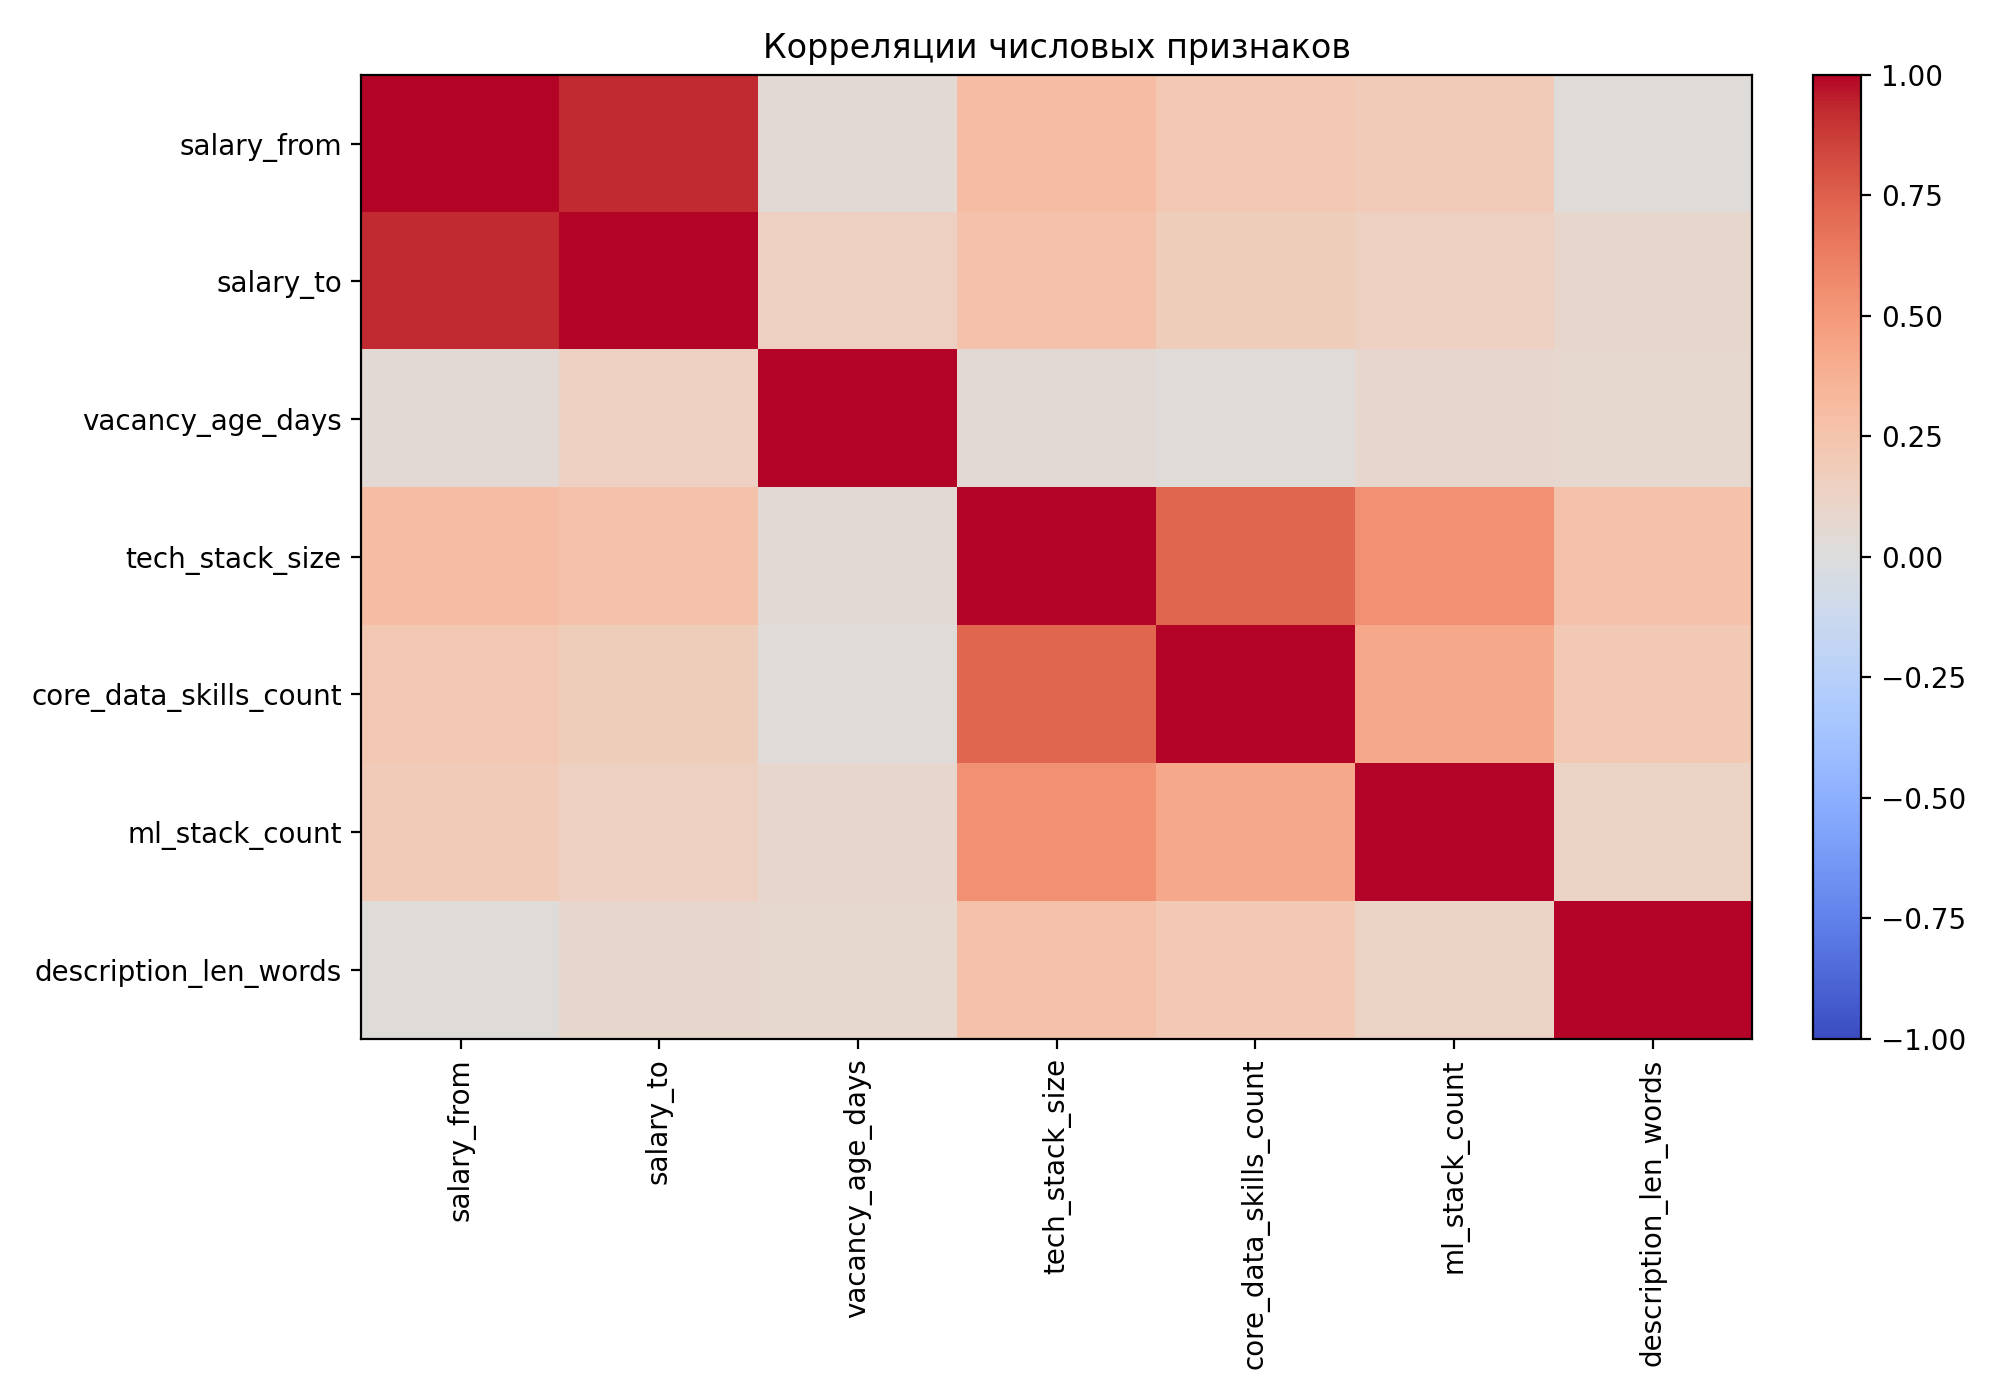

In [38]:
corr_cols = [
    col
    for col in [
        "salary_from",
        "salary_to",
        "vacancy_age_days",
        "tech_stack_size",
        "core_data_skills_count",
        "ml_stack_count",
        "description_len_words",
    ]
    if col in df_features.columns
]
correlations = eda.correlation_matrix(df_features, cols=corr_cols)
corr_fig_path = viz.corr_heatmap(correlations)

display(Image(corr_fig_path))


*Связь с зарплатой:* `salary_from` и `salary_to` ожидаемо коррелируют между собой, негативная связь с `vacancy_age_days` подчёркивает, что свежие вакансии быстрее набирают отклики.

*Выводы для рынка:* размер стека и длина описания умеренно положительно связаны с зарплатами.

*Skillra:* можно использовать эти связи в подсказках по улучшению резюме и в приоритизации вакансий для пользователей.

### 3.6 Инсайты EDA
- **Что мы сделали:** построили тепловые карты по зарплатам (грейд×город, роль×формат), разложили долю удалёнки, выгрузили топ работодателей/бенефитов/soft-skills, посмотрели корреляции.
- **Почему именно так:** инвесторам и пользователям важны премии по локации/формату и качество работодателей; корреляции показывают, какие числовые признаки двигают зарплату.
- **Основные выводы про рынок:** Москва/СПб дают ~56% вакансий и медиану до 275k для senior; удалёнка/гибрид присутствует в 57% вакансий (ML ~81% remote) при 34% `unknown` work_mode; финтех 17% и IT-продукты 12% держат премию, но 54% строк без домена; английский явно требуют лишь 15% вакансий, аналогично образование.
- **Что это даёт продукту Skillra:** формируем подсказки по целевым кластерам (например, data-ролям в крупных городах или remote fintech) и готовим аргументы для карьерного трекинга.
- **Мини-чек-лист:** EDA проходит на датасете 7 026×164 без изменения формы; собрали числовые сводки по зарплатам/форматам/ролям, долям remote и junior-friendly, топам работодателей и навыков.

## Этап 4. Визуализации и сводка
Используем готовые функции из `viz.py`, сохраняем графики в `reports/figures`. Графики покрывают зарплаты, форматы работы, навыковые тепловые карты, soft-skills и распределения.

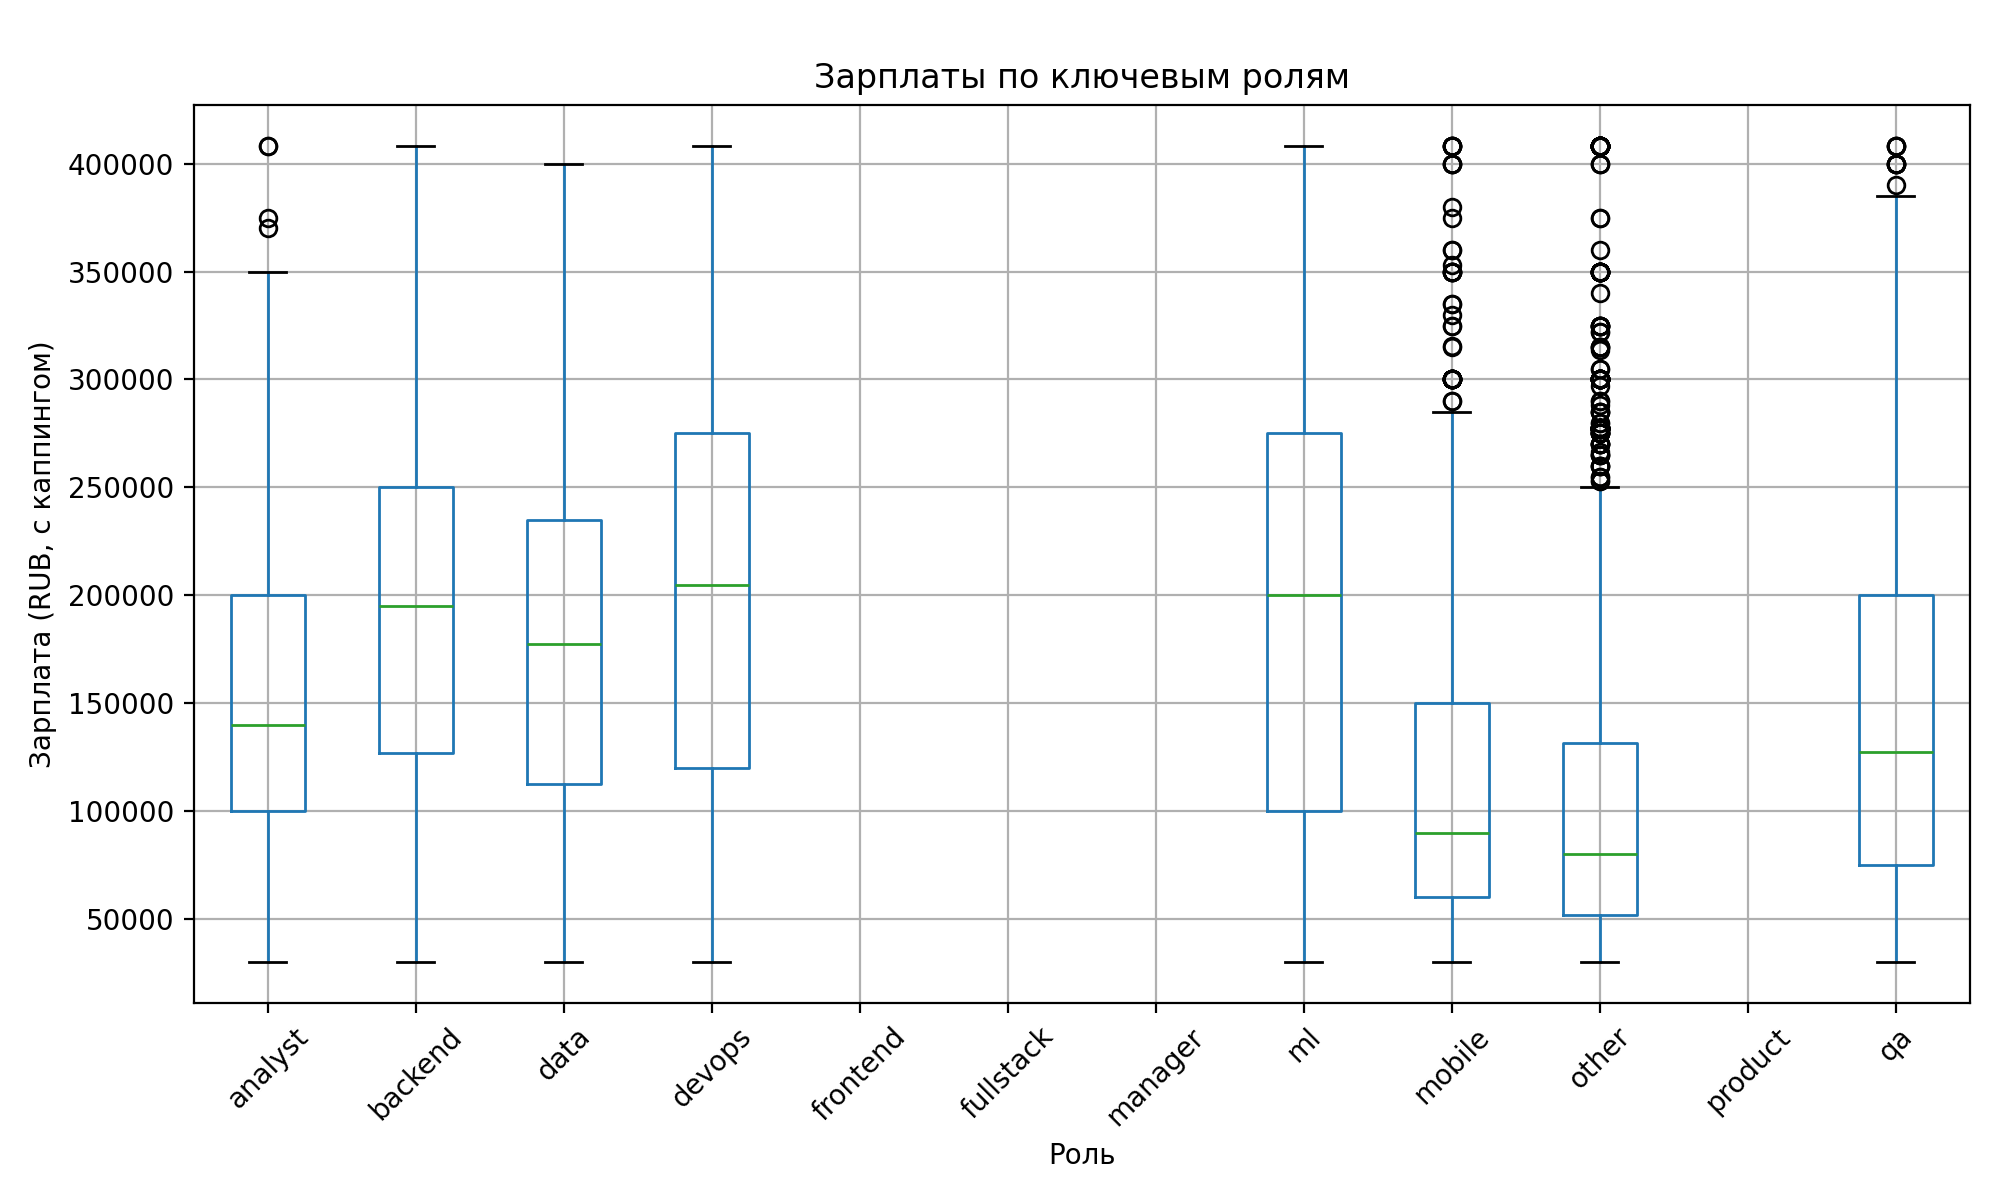

In [39]:
salary_role_path = viz.salary_by_role_box(df_features)

display(Image(salary_role_path))


Галерея: распределение зарплат по ролям.
- **Рынок:** разброс внутри ролей велик, но медианы держатся выше у ML/DS.
- **Skillra:** помогает пользователю понять вилки внутри выбранной роли и оценить ожидания.

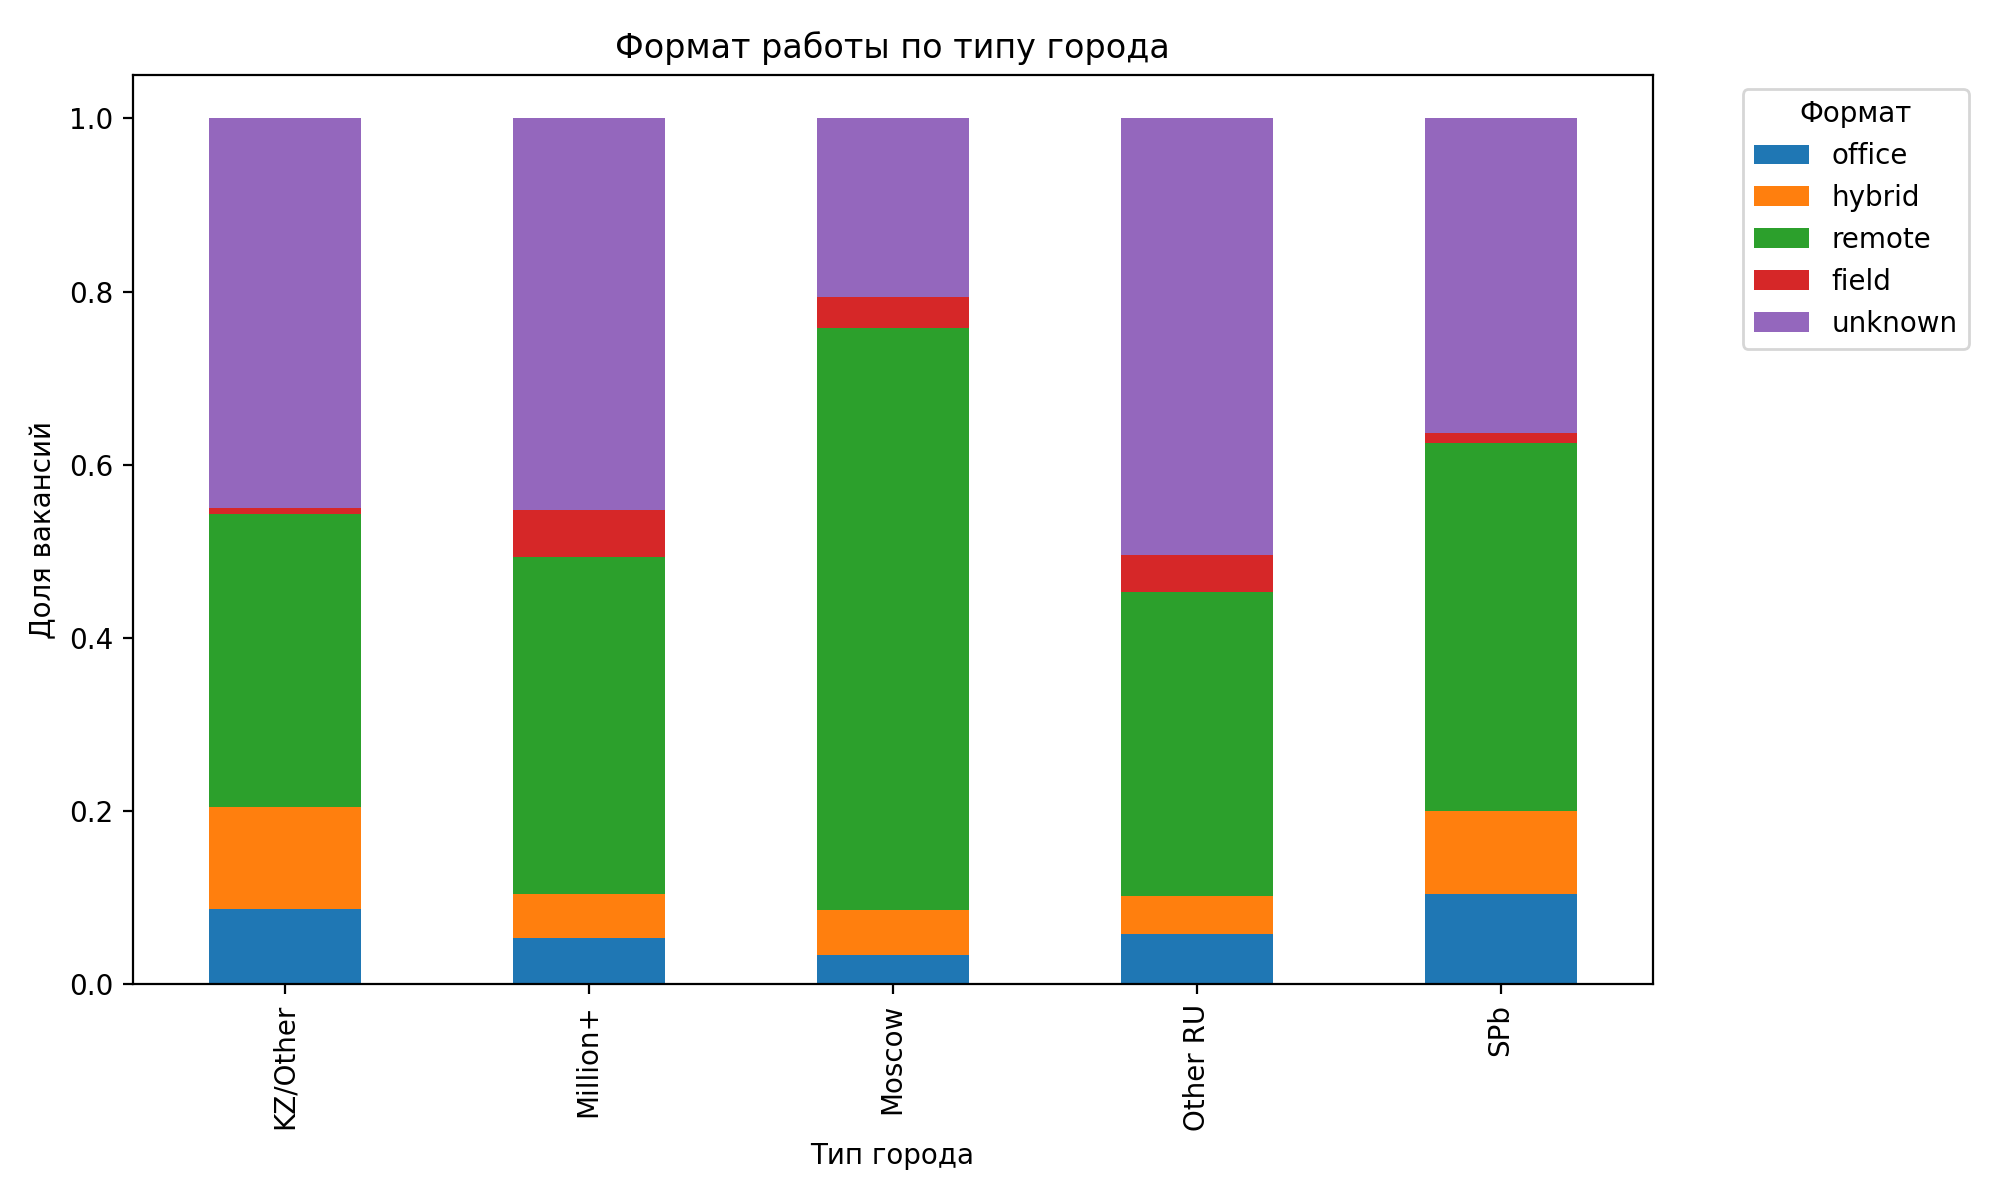

In [40]:
workmode_path = viz.work_mode_share_by_city(df_features)

display(Image(workmode_path))


Галерея: формат работы по типу города.
- **Рынок:** удалёнка концентрируется в столицах, в регионах преобладает офис/гибрид.
- **Skillra:** можно подсказывать форматы работы и релокацию/удалёнку в зависимости от города пользователя.

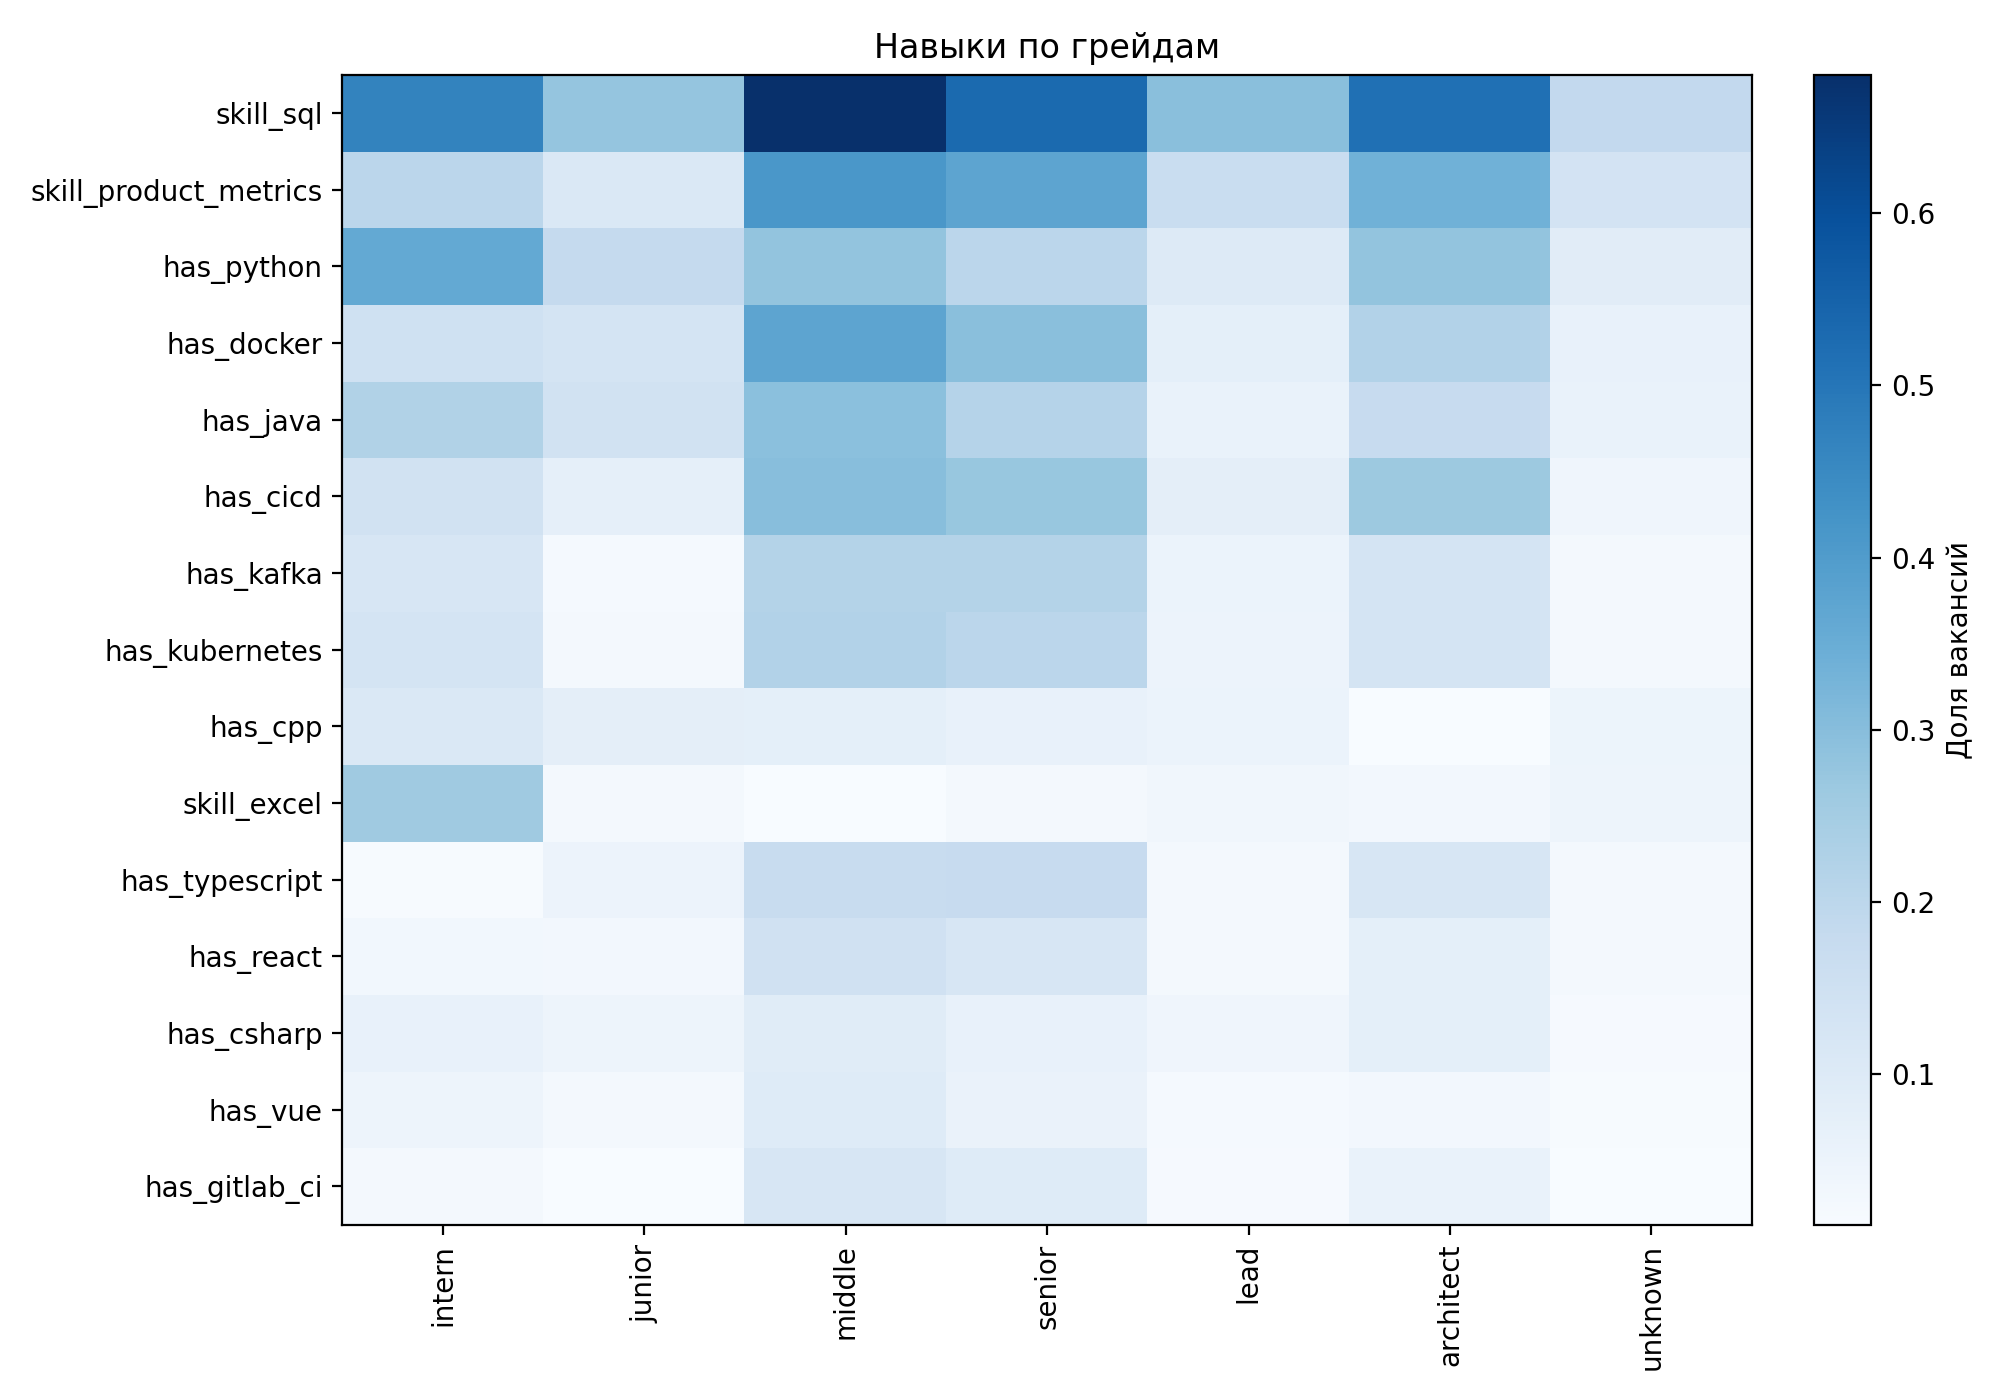

In [41]:
skill_heatmap_path = viz.heatmap_skills_by_grade(skill_share)

display(Image(skill_heatmap_path))


Галерея: навыки по грейдам.
- **Рынок:** у middle/senior шире стек и выше доля продвинутых skills.
- **Skillra:** подсвечиваем пользователю, какие навыки добавлять, чтобы перейти в следующий грейд.

### 4.1 Выводы по графикам
- **Что мы сделали:** собрали набор готовых графиков (боксплоты, bar+count, тепловые карты) прямо из кода `viz.py` и встроили в ноутбук.
- **Почему именно так:** хотим, чтобы ноутбук был self-contained и понятен инвестору: каждый график сразу отображается и сохраняется в `reports/figures`.
- **Основные выводы про рынок:** медианы и объёмы видны на одном экране, тепловые карты подчёркивают премии по локации/формату.
- **Что это даёт продукту Skillra:** готовы reusable-компоненты для веб-интерфейса (дашборд рынка) и презентаций.
- **Мини-чек-лист:** исходный датасет 7 026×164 остаётся неизменным, добавлены готовые артефакты в `reports/figures` (зарплаты по ролям, формат работы, heatmap навыков).
- **К какому следующему шагу это подводит:** переходим к персонализации (персоны) и масштабированию данных.

## Продуктовая часть: персоны и skill-gap
Персоны из контекста Skillra: студент (Junior DA/DS), свитчер в BI/продукт, middle аналитик. Используем `personas.analyze_persona` как основной API: он возвращает market summary, skill-gap и рекомендованные навыки.

In [42]:
personas_mod = importlib.reload(personas)
persona_objects = [
    personas_mod.DATA_STUDENT,
    personas_mod.SWITCHER_BI,
    personas_mod.MID_DATA_ANALYST,
]

persona_reports = {}
for p in persona_objects:
    analysis = personas_mod.analyze_persona(df_features, p, top_k=10)
    persona_reports[p.name] = analysis

    persona_profile = pd.DataFrame({
        "persona": [p.name],
        "description": [p.description],
        "goals": [", ".join(p.goals) if p.goals else "—"],
        "limitations": [", ".join(p.limitations) if p.limitations else "—"],
        "target_role": [p.target_role],
        "target_grade": [p.target_grade],
        "target_city_tier": [p.target_city_tier],
        "target_work_mode": [p.target_work_mode],
    })
    display(persona_profile)

    summary_df = pd.DataFrame([analysis["market_summary"]])
    display(summary_df)

    top_demand = analysis.get("top_skill_demand")
    if isinstance(top_demand, pd.DataFrame) and not top_demand.empty:
        display(top_demand.head(5))

    display(analysis["skill_gap"].head(10))
    top_reco = analysis["recommended_skills"][:5]
    print(f"Рекомендуем добрать: {', '.join(top_reco) if top_reco else 'нет явных гэпов'}")
    print('-' * 40)


,persona,description,goals,limitations,target_role,target_grade,target_city_tier,target_work_mode
0,data_student,"Магистрант по данным, целится в Junior DA/DS","Получить первую роль Junior DA/DS, Подтянуть P...","Неполная занятость из-за учёбы, Ориентация на ...",analyst,junior,None,None


,vacancy_count,min_market_n,salary_median,salary_q25,salary_q75,remote_share,junior_friendly_share
0,180,80,100000.0,80000.0,130000.0,0.444444,0.122222


,skill_name,market_share
0,skill_sql,0.388889
1,skill_product_metrics,0.133333
2,has_python,0.122222
3,skill_excel,0.083333
4,has_java,0.061111


,skill_name,market_share,persona_has,gap
0,skill_product_metrics,0.133333,False,True
1,has_java,0.061111,False,True
2,skill_sql,0.388889,True,False
3,has_python,0.122222,True,False
4,skill_excel,0.083333,True,False


Рекомендуем добрать: skill_product_metrics, has_java
----------------------------------------


,persona,description,goals,limitations,target_role,target_grade,target_city_tier,target_work_mode
0,switcher_bi,Свитчер в продуктовую/BI-аналитику,Перейти из смежной сферы в BI/продуктовую анал...,"Нужно быстро выйти на работу, Ставка на гибрид...",product,junior,None,None


,vacancy_count,min_market_n,salary_median,salary_q25,salary_q75,remote_share,junior_friendly_share
0,7026,80,105000.0,60000.0,180000.0,0.548107,0.359664


,skill_name,market_share
0,skill_sql,0.261315
1,skill_product_metrics,0.169371
2,has_python,0.121976
3,has_docker,0.102050
4,has_java,0.093083


,skill_name,market_share,persona_has,gap
0,skill_sql,0.261315,False,True
1,skill_product_metrics,0.169371,False,True
2,has_python,0.121976,False,True
3,has_docker,0.102050,False,True
4,has_java,0.093083,False,True
5,has_cicd,0.078565,False,True
6,has_kafka,0.054796,False,True
7,has_kubernetes,0.054227,False,True
8,has_cpp,0.053516,False,True


Рекомендуем добрать: skill_sql, skill_product_metrics, has_python, has_docker, has_java
----------------------------------------


,persona,description,goals,limitations,target_role,target_grade,target_city_tier,target_work_mode
0,mid_data_analyst,"Middle аналитик, хочет усилить hard-стек","Выйти на позиции middle+, Усилить ML/продвинут...","Рассматривает офис/гибрид, Хочет рост зарплаты",analyst,middle,None,None


,vacancy_count,min_market_n,salary_median,salary_q25,salary_q75,remote_share,junior_friendly_share
0,186,80,180000.0,140000.0,231000.0,0.569892,0.107527


,skill_name,market_share
0,skill_sql,0.413978
1,skill_product_metrics,0.311828
2,has_docker,0.172043
3,has_kubernetes,0.166667
4,has_kafka,0.155914


,skill_name,market_share,persona_has,gap
0,skill_product_metrics,0.311828,False,True
1,has_docker,0.172043,False,True
2,has_kubernetes,0.166667,False,True
3,has_kafka,0.155914,False,True
4,has_python,0.112903,False,True
5,has_ansible,0.086022,False,True
6,has_cpp,0.064516,False,True
7,has_cicd,0.059140,False,True
8,skill_clickhouse,0.053763,False,True
9,skill_sql,0.413978,True,False


Рекомендуем добрать: skill_product_metrics, has_docker, has_kubernetes, has_kafka, has_python
----------------------------------------


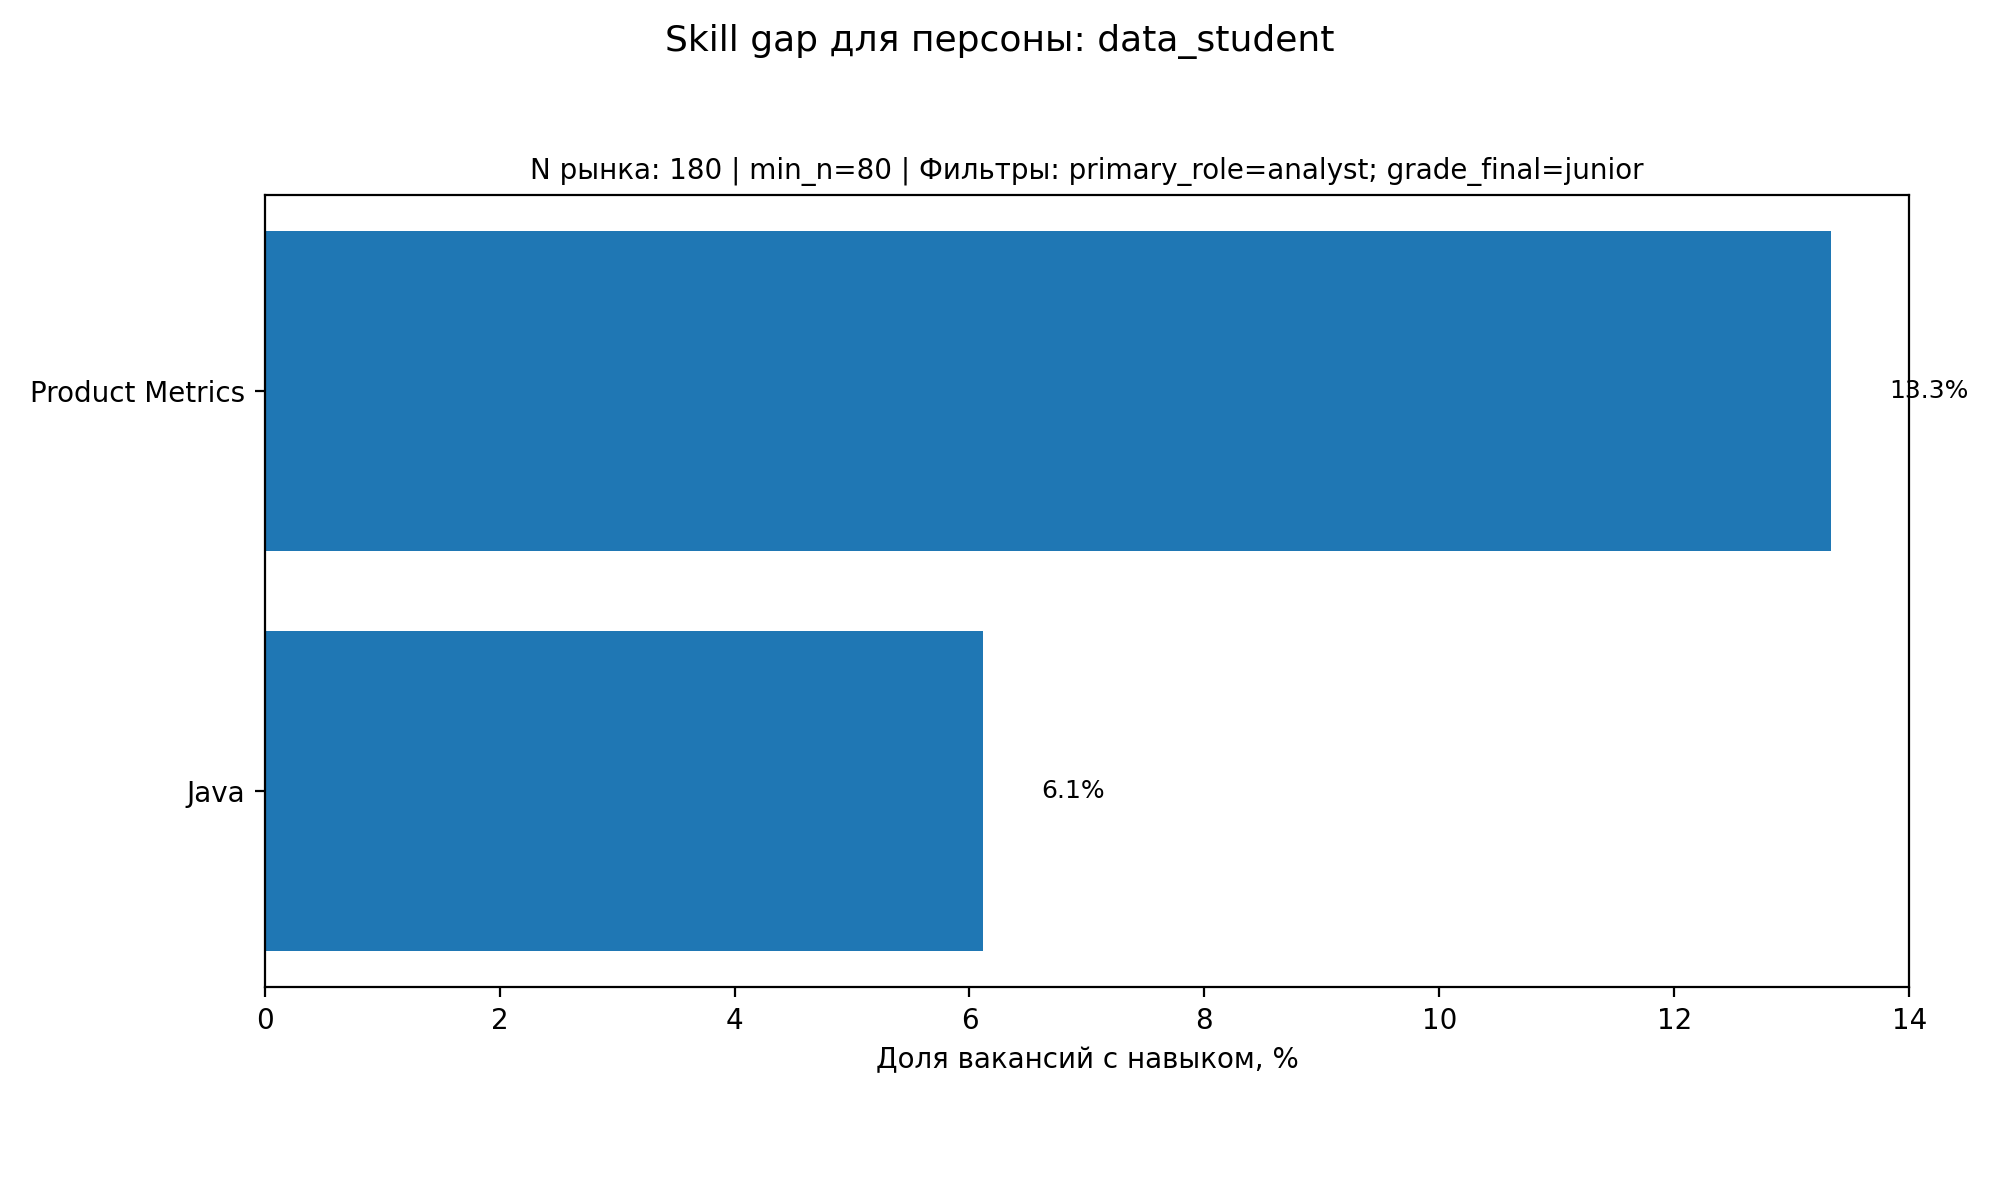

In [43]:
gap_student = persona_reports.get("data_student", {}).get("skill_gap")
path_gap_student = personas_mod.plot_persona_skill_gap(
    gap_student, personas_mod.DATA_STUDENT
)

display(Image(path_gap_student))


In [44]:
from IPython.display import Markdown, display

student_report = persona_reports.get("data_student", {})
student_gap = student_report.get("skill_gap", pd.DataFrame()).head(3)
student_market = student_report.get("market_summary", {})
student_skills = [row.skill_name for row in student_gap.itertuples()] if not student_gap.empty else []
student_md = Markdown(
    f"Skill-gap для персоны *data_student* (n={student_market.get('vacancy_count', 0)}): "
    + (", ".join(student_skills) if student_skills else "нет выраженных гэпов")
    + ". Remote доля — "
    + (f"{student_market.get('remote_share', 0):.1%}" if 'remote_share' in student_market else "—")
    + ", junior-friendly — "
    + (f"{student_market.get('junior_friendly_share', 0):.1%}" if 'junior_friendly_share' in student_market else "—")
    + "."
)
display(student_md)


Skill-gap для персоны *data_student* (n=180): skill_product_metrics, has_java, skill_sql. Remote доля — 44.4%, junior-friendly — 12.2%.

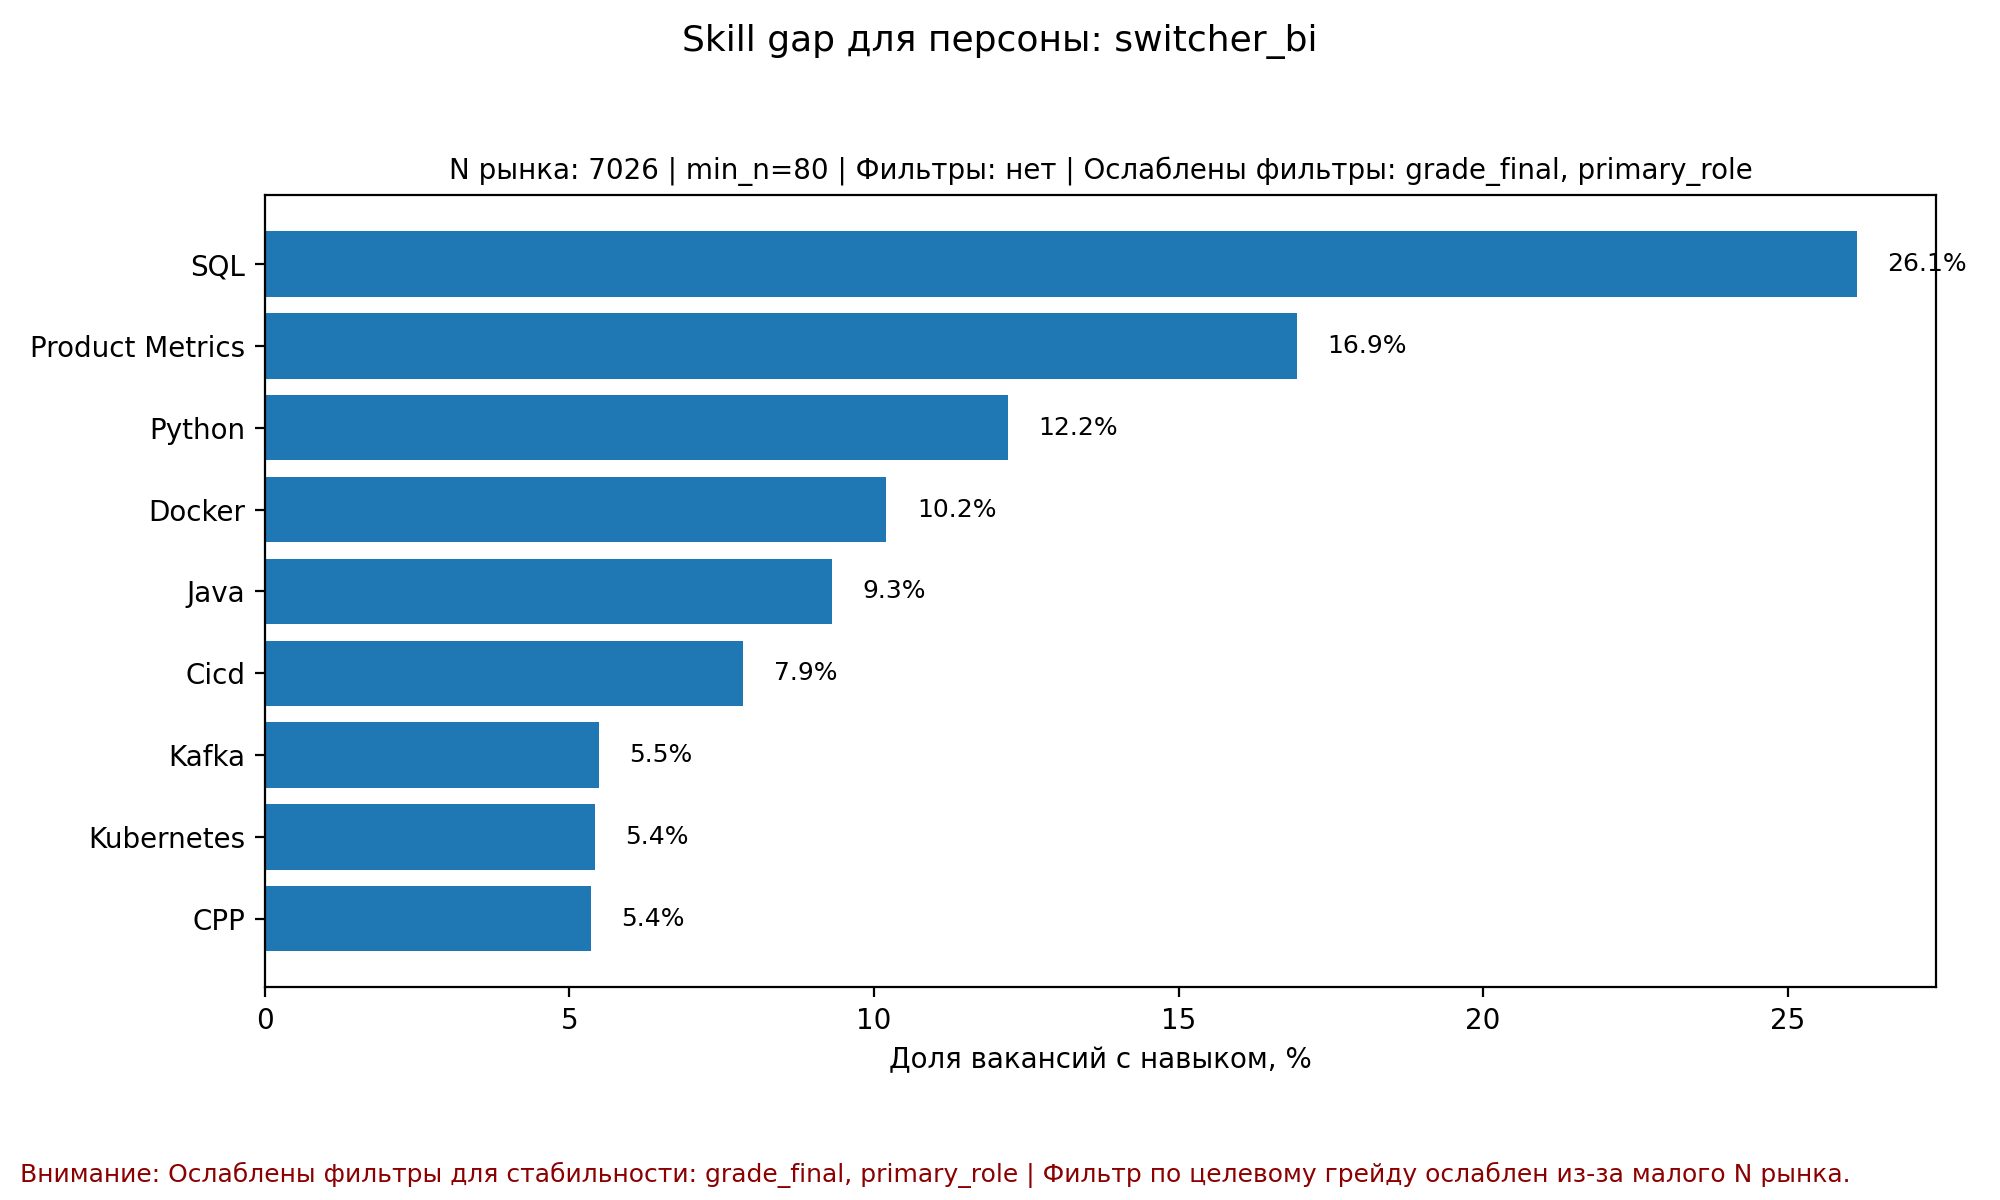

In [45]:
gap_switcher = persona_reports.get("switcher_bi", {}).get("skill_gap")
path_gap_switcher = personas_mod.plot_persona_skill_gap(
    gap_switcher, personas_mod.SWITCHER_BI
)

display(Image(path_gap_switcher))


In [46]:
from IPython.display import Markdown, display

bi_report = persona_reports.get("switcher_bi", {})
bi_gap = bi_report.get("skill_gap", pd.DataFrame()).head(3)
bi_market = bi_report.get("market_summary", {})
bi_skills = [row.skill_name for row in bi_gap.itertuples()] if not bi_gap.empty else []
bi_md = Markdown(
    f"Skill-gap для персоны *switcher_bi* (n={bi_market.get('vacancy_count', 0)}): "
    + (", ".join(bi_skills) if bi_skills else "нет выраженных гэпов")
    + f". Remote+hybrid — {bi_market.get('remote_share', 0):.1%}, junior-friendly — {bi_market.get('junior_friendly_share', 0):.1%}."
)
display(bi_md)


Skill-gap для персоны *switcher_bi* (n=7026): skill_sql, skill_product_metrics, has_python. Remote+hybrid — 54.8%, junior-friendly — 36.0%.

*Визуализация skill-gap даёт готовый виджет для личного кабинета Skillra: пользователь видит, какие навыки закрывают 
максимальную долю вакансий в целевом сегменте, и может кликнуть в рекомендации курсов/проектов.*

In [47]:
from IPython.display import Markdown, display

student_n = persona_reports.get("data_student", {}).get("market_summary", {}).get("vacancy_count", 0)
switcher_n = persona_reports.get("switcher_bi", {}).get("market_summary", {}).get("vacancy_count", 0)
mid_n = persona_reports.get("mid_data_analyst", {}).get("market_summary", {}).get("vacancy_count", 0)
summary_md = Markdown(f"""
### Выводы по персонам
- Студент DA/DS: сегмент n={student_n}, ключевые гэпы — топ-3 навыка из графика; remote {persona_reports['data_student']['market_summary'].get('remote_share', 0):.1%}.
- Свитчер BI: n={switcher_n}, приоритеты из графика; remote {persona_reports['switcher_bi']['market_summary'].get('remote_share', 0):.1%}.
- Mid аналитик: n={mid_n}, опираемся на видимые гэпы; выводы делаем только по отображённым навыкам.
""")
display(summary_md)



### Выводы по персонам
- Студент DA/DS: сегмент n=180, ключевые гэпы — топ-3 навыка из графика; remote 44.4%.
- Свитчер BI: n=7026, приоритеты из графика; remote 54.8%.
- Mid аналитик: n=186, опираемся на видимые гэпы; выводы делаем только по отображённым навыкам.


In [48]:
from IPython.display import Markdown, display

notes_md = Markdown("""
### Пояснения по персонам
- Все выводы основаны на графике skill-gap: обсуждаем только навыки, которые реально в топе гэпов.
- n сегментов явно указано; при уменьшении выборки ниже min_market_n анализ не проводим.
- Высокая доля unknown по грейдам/форматам учитывается при интерпретации.
""")
display(notes_md)



### Пояснения по персонам
- Все выводы основаны на графике skill-gap: обсуждаем только навыки, которые реально в топе гэпов.
- n сегментов явно указано; при уменьшении выборки ниже min_market_n анализ не проводим.
- Высокая доля unknown по грейдам/форматам учитывается при интерпретации.


## Итоговые выводы и чек-лист
### Выводы про рынок
- Зарплаты растут по грейду и укрупнённости города; в Москве медиана senior ~275k против 178k в регионах, удалёнка концентрируется в ролях data/ML (до 81%).
- Доменные лидеры (финтех ~17%, продуктовые IT ~12%) и топ работодатели держат медианы выше среднего, но 54% вакансий без домена — учитываем смещение.
- Требования к английскому/образованию редко жёсткие (только ~15–18% выборки с явными требованиями), поэтому рынок открыт для широкого пула кандидатов.
- Навыковая карта подтверждает спрос на SQL/BI для junior и продуктовых аналитиков, ML/infra — для senior; это отражено в skill-gap персонам.
- Корреляции показывают влияние размера стека и насыщенности описания на уровень вилки, что можно использовать в скоринге вакансий.

### Выводы для Skillra
- Готовые витрины (`hh_clean`, `hh_features`, `market_view`) позволяют строить карьерные рекомендации без ручной очистки.
- API `analyze_persona` даёт готовый блок для пользовательских сценариев (оценка сегмента, gap, next best skill).
- Самые ценные сегменты для продукта — data/ML и аналитика с высоким спросом на удалёнку и junior-friendly роли.
- Карта бенефитов/soft-skills по работодателям помогает подбирать целевые компании под цели пользователя.

### Чек-лист выполнения ТЗ
| Этап | Что сделано | Секция ноутбука |
| --- | --- | --- |
| 0. Данные | Парсер HH, raw head/info, профиль пропусков | Этап 0 |
| 1. Предобработка | Пропуски/булевы/дубликаты, `missing_share` | Этап 1 |
| 2. Признаки | `city_tier`, `work_mode`, стек, тексты, junior-friendly | Этап 2 |
| 3. EDA | Зарплаты, форматы, роли, навыки, домены, язык, образование, работодатели, корреляции | Этап 3 |
| 4. Визуализация | Графики зарплат/навыков/soft-skills/распределений | Этап 4 |
| Продуктовый слой | `analyze_persona`, skill-gap, рекомендации | Персоны |